# Setup

In [1]:
import logging
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, classification_report
from scipy.sparse import hstack
from nltk.corpus import stopwords
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, RepeatedKFold
from scipy.stats import sem
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

pd.set_option('display.max_colwidth', None)
plt.rcParams['figure.dpi'] = 500
logging.basicConfig(level=logging.WARNING, format='%(asctime)s - %(levelname)s - %(message)s')

# Printing confusion matrix
def plot_conf_mat(cm):
    class_names=['Negative', 'Neutral', 'Positive'] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, labels=[-1,0,1])
    plt.yticks(tick_marks, labels=class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

# Load data from the specified path
df = pd.read_feather("../Data/Data1.feather")

In [2]:
# Select features and target variable from the dataset
features = df[['text', 'base_url', 'company_names']]
target = df['sentiment']

# Split the dataset into training and testing subsets
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=42)

# Append custom stop words to the English stop words list
custom_stop_words = stopwords.words('english')
custom_stop_words.extend(['rt', 'ep'])

# TF-IDF Approach

In [3]:
# Initialize TF-IDF vectorizer for the 'text' column with custom stop words
tfidf_vectorizer_text = TfidfVectorizer(stop_words=custom_stop_words, max_features=1000)
features_train_tfidf_text = tfidf_vectorizer_text.fit_transform(features_train['text'])
features_test_tfidf_text = tfidf_vectorizer_text.transform(features_test['text'])

# Initialize TF-IDF vectorizer for the 'base_url' column
tfidf_vectorizer_url = TfidfVectorizer(stop_words=custom_stop_words, max_features=1000)
features_train_tfidf_url = tfidf_vectorizer_url.fit_transform(features_train['base_url'])
features_test_tfidf_url = tfidf_vectorizer_url.transform(features_test['base_url'])

# Initialize TF-IDF vectorizer for the 'company_names' column
tfidf_vectorizer_company_names = TfidfVectorizer(stop_words=custom_stop_words, max_features=1000)
features_train_tfidf_company_names = tfidf_vectorizer_company_names.fit_transform(features_train['company_names'])
features_test_tfidf_company_names = tfidf_vectorizer_company_names.transform(features_test['company_names'])

# Combine all TF-IDF feature matrices horizontally
features_train_tfidf_combined = hstack([features_train_tfidf_text, features_train_tfidf_url, features_train_tfidf_company_names])
features_test_tfidf_combined = hstack([features_test_tfidf_text, features_test_tfidf_url, features_test_tfidf_company_names])

## Vanilla Random Forest Classifier

In [12]:
# Define and train a Random Forest classifier
random_forest_classifier = RandomForestClassifier(random_state=50, oob_score=True)
random_forest_classifier.fit(features_train_tfidf_combined, target_train)

RandomForestClassifier(oob_score=True, random_state=50)

Accuracy: 0.9421951790311257

OOB Score: 0.9428387549730868

Classification Report: 
               precision    recall  f1-score   support

          -1       0.92      0.79      0.85       389
           0       0.94      0.97      0.96      2584
           1       0.95      0.93      0.94      1300

    accuracy                           0.94      4273
   macro avg       0.94      0.90      0.91      4273
weighted avg       0.94      0.94      0.94      4273


Confusion Matrix:
 

     -1     0     1
-1  306    69    14
0    21  2516    47
1     5    91  1204


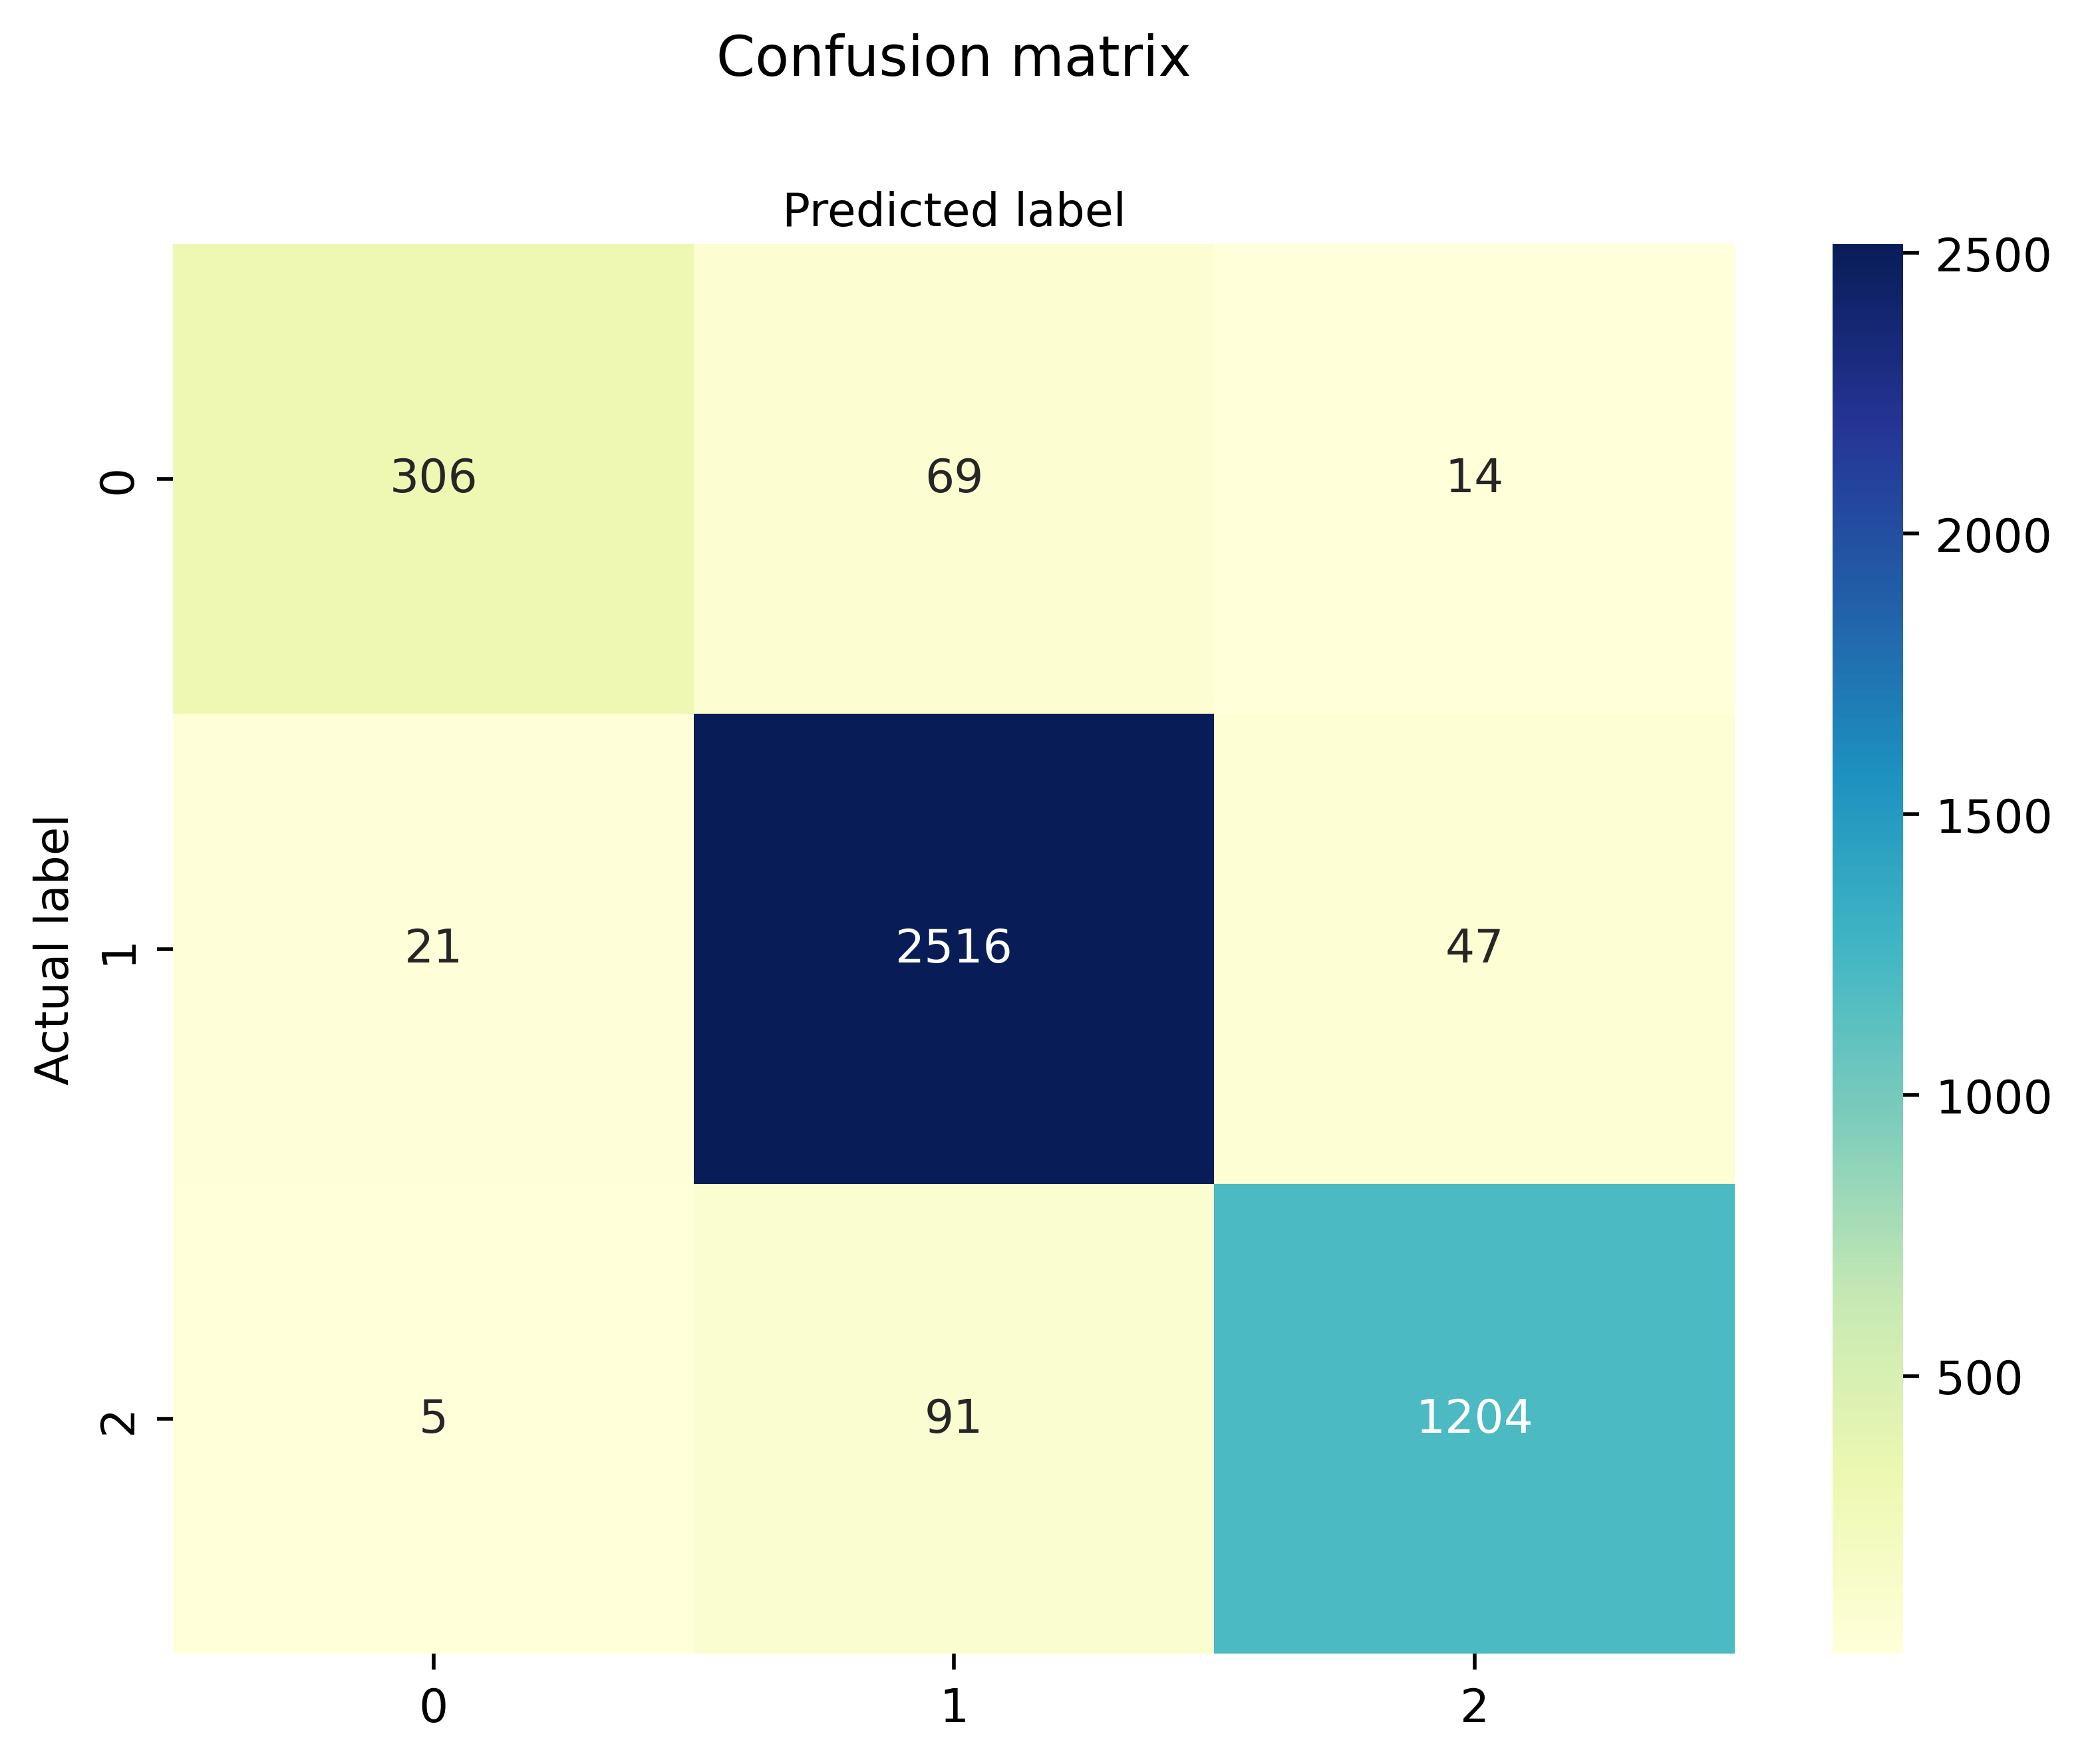

In [13]:
# Predict the sentiment on the test set and print accuracy
predictions = random_forest_classifier.predict(features_test_tfidf_combined)
accuracy = accuracy_score(target_test, predictions)
print(f"Accuracy: {accuracy}")

# Calculate OOB Score
oob_score = random_forest_classifier.oob_score_
print(f"\nOOB Score: {oob_score}")

# Detailed classification report
print("\nClassification Report: \n", classification_report(target_test, predictions))

# Print and Plot Confusion Matrix
cm = confusion_matrix(target_test, predictions)
df_cm = pd.DataFrame(cm, index=['-1', '0', '1'], columns=['-1', '0', '1'])
print("\nConfusion Matrix:\n", df_cm)
plot_conf_mat(cm)

## Random Forest Classifier with Feature Bagging

In [14]:
classifier_with_bagging = RandomForestClassifier(max_features='sqrt', oob_score=True)
classifier_with_bagging.fit(features_train_tfidf_combined, target_train)

RandomForestClassifier(oob_score=True)

Accuracy: 0.9428972618769015

OOB Score: 0.9433653171074187

Classification Report: 
               precision    recall  f1-score   support

          -1       0.92      0.80      0.85       389
           0       0.94      0.97      0.96      2584
           1       0.95      0.92      0.94      1300

    accuracy                           0.94      4273
   macro avg       0.94      0.90      0.92      4273
weighted avg       0.94      0.94      0.94      4273

Confusion Matrix:
      -1     0     1
-1  310    63    16
0    22  2517    45
1     6    92  1202


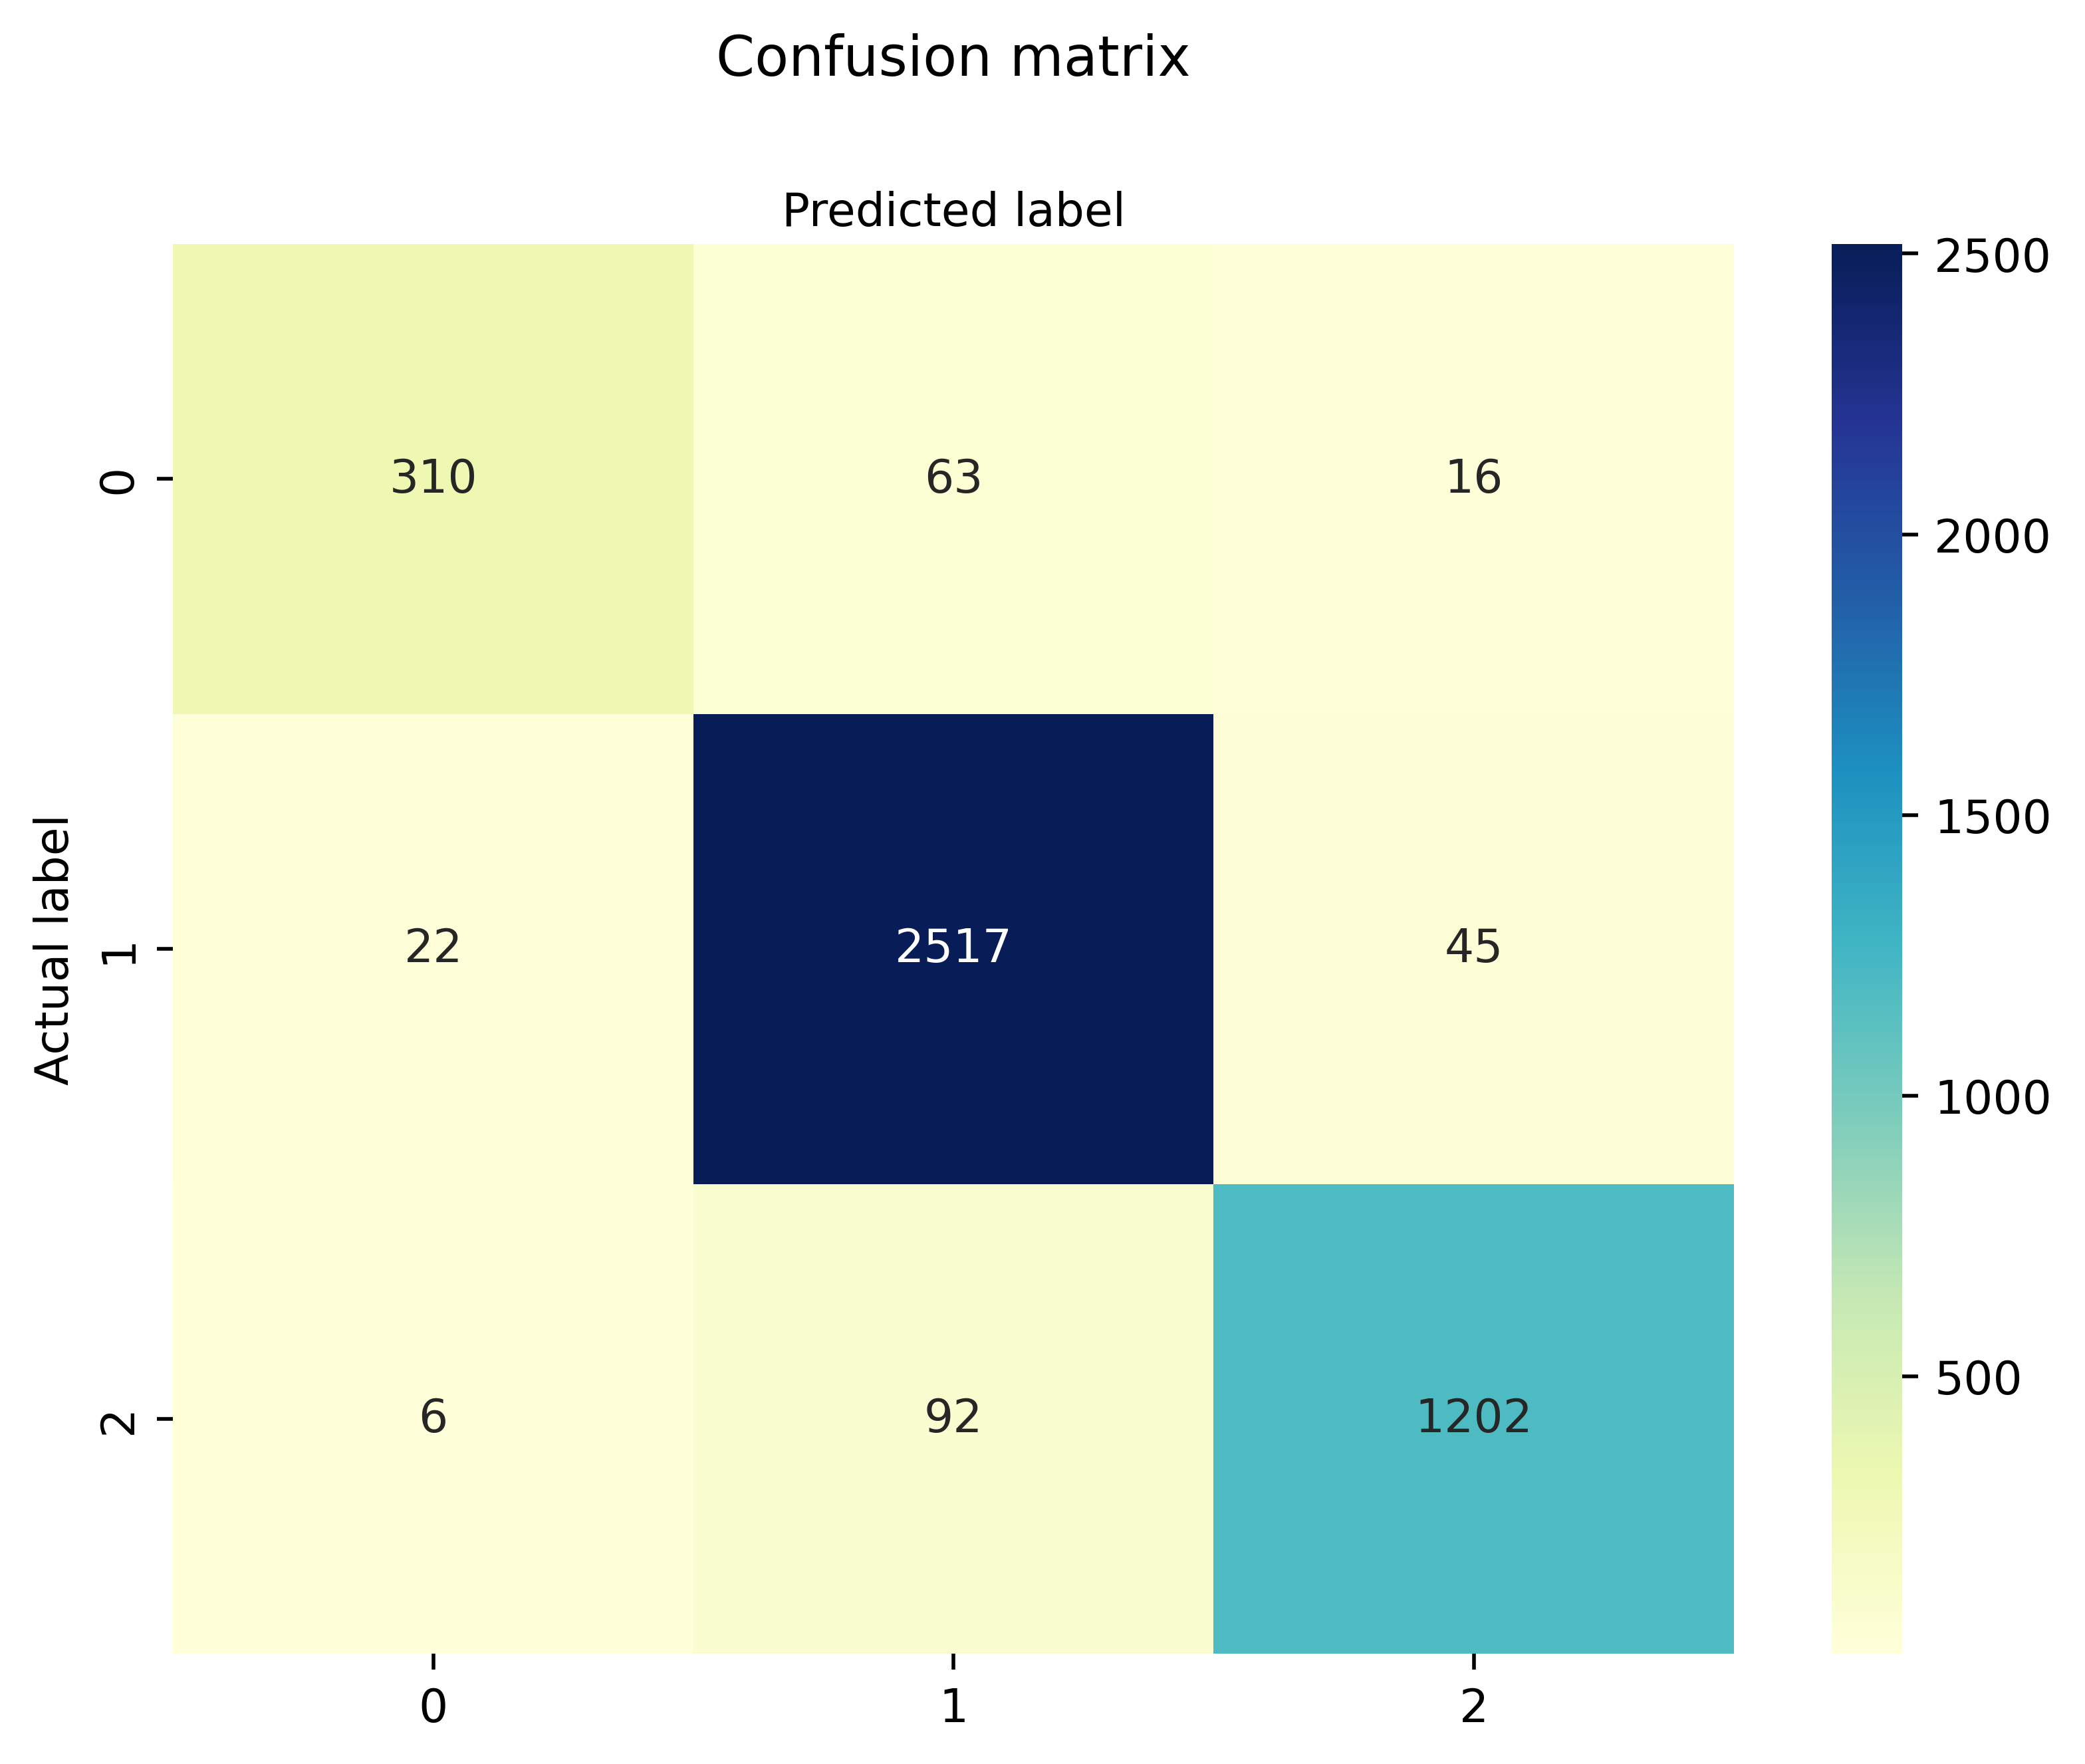

In [15]:
# Predict and evaluate the model
predictions_bagging = classifier_with_bagging.predict(features_test_tfidf_combined)
accuracy_bagging = accuracy_score(target_test, predictions_bagging)
print(f"Accuracy: {accuracy_bagging}")

# Calculate OOB Score
oob_score_bagging = classifier_with_bagging.oob_score_
print(f"\nOOB Score: {oob_score_bagging}")

# Detailed classification report for Bagging Classifier
print("\nClassification Report: \n", classification_report(target_test, predictions_bagging))

# Print and Plot Confusion Matrix for Bagging Classifier
cm_bagging = confusion_matrix(target_test, predictions_bagging)
df_cm_bagging = pd.DataFrame(cm_bagging, index=['-1', '0', '1'], columns=['-1', '0', '1'])
print("Confusion Matrix:\n", df_cm_bagging)
plot_conf_mat(cm_bagging)

## Gradient Boosting Classifier

In [16]:
# Gradient Boosting Classifier configuration and training
gradient_boosting_classifier = GradientBoostingClassifier(n_estimators=50, learning_rate=0.25, max_depth=10)
gradient_boosting_classifier.fit(features_train_tfidf_combined, target_train)

GradientBoostingClassifier(learning_rate=0.25, max_depth=10, n_estimators=50)

Accuracy: 0.9393868476480225

OOB Score: 0.976421717762696

Classification Report: 
               precision    recall  f1-score   support

          -1       0.87      0.78      0.82       389
           0       0.94      0.98      0.96      2584
           1       0.97      0.91      0.94      1300

    accuracy                           0.94      4273
   macro avg       0.92      0.89      0.91      4273
weighted avg       0.94      0.94      0.94      4273

Confusion Matrix:
      -1     0     1
-1  304    71    14
0    34  2523    27
1    12   101  1187


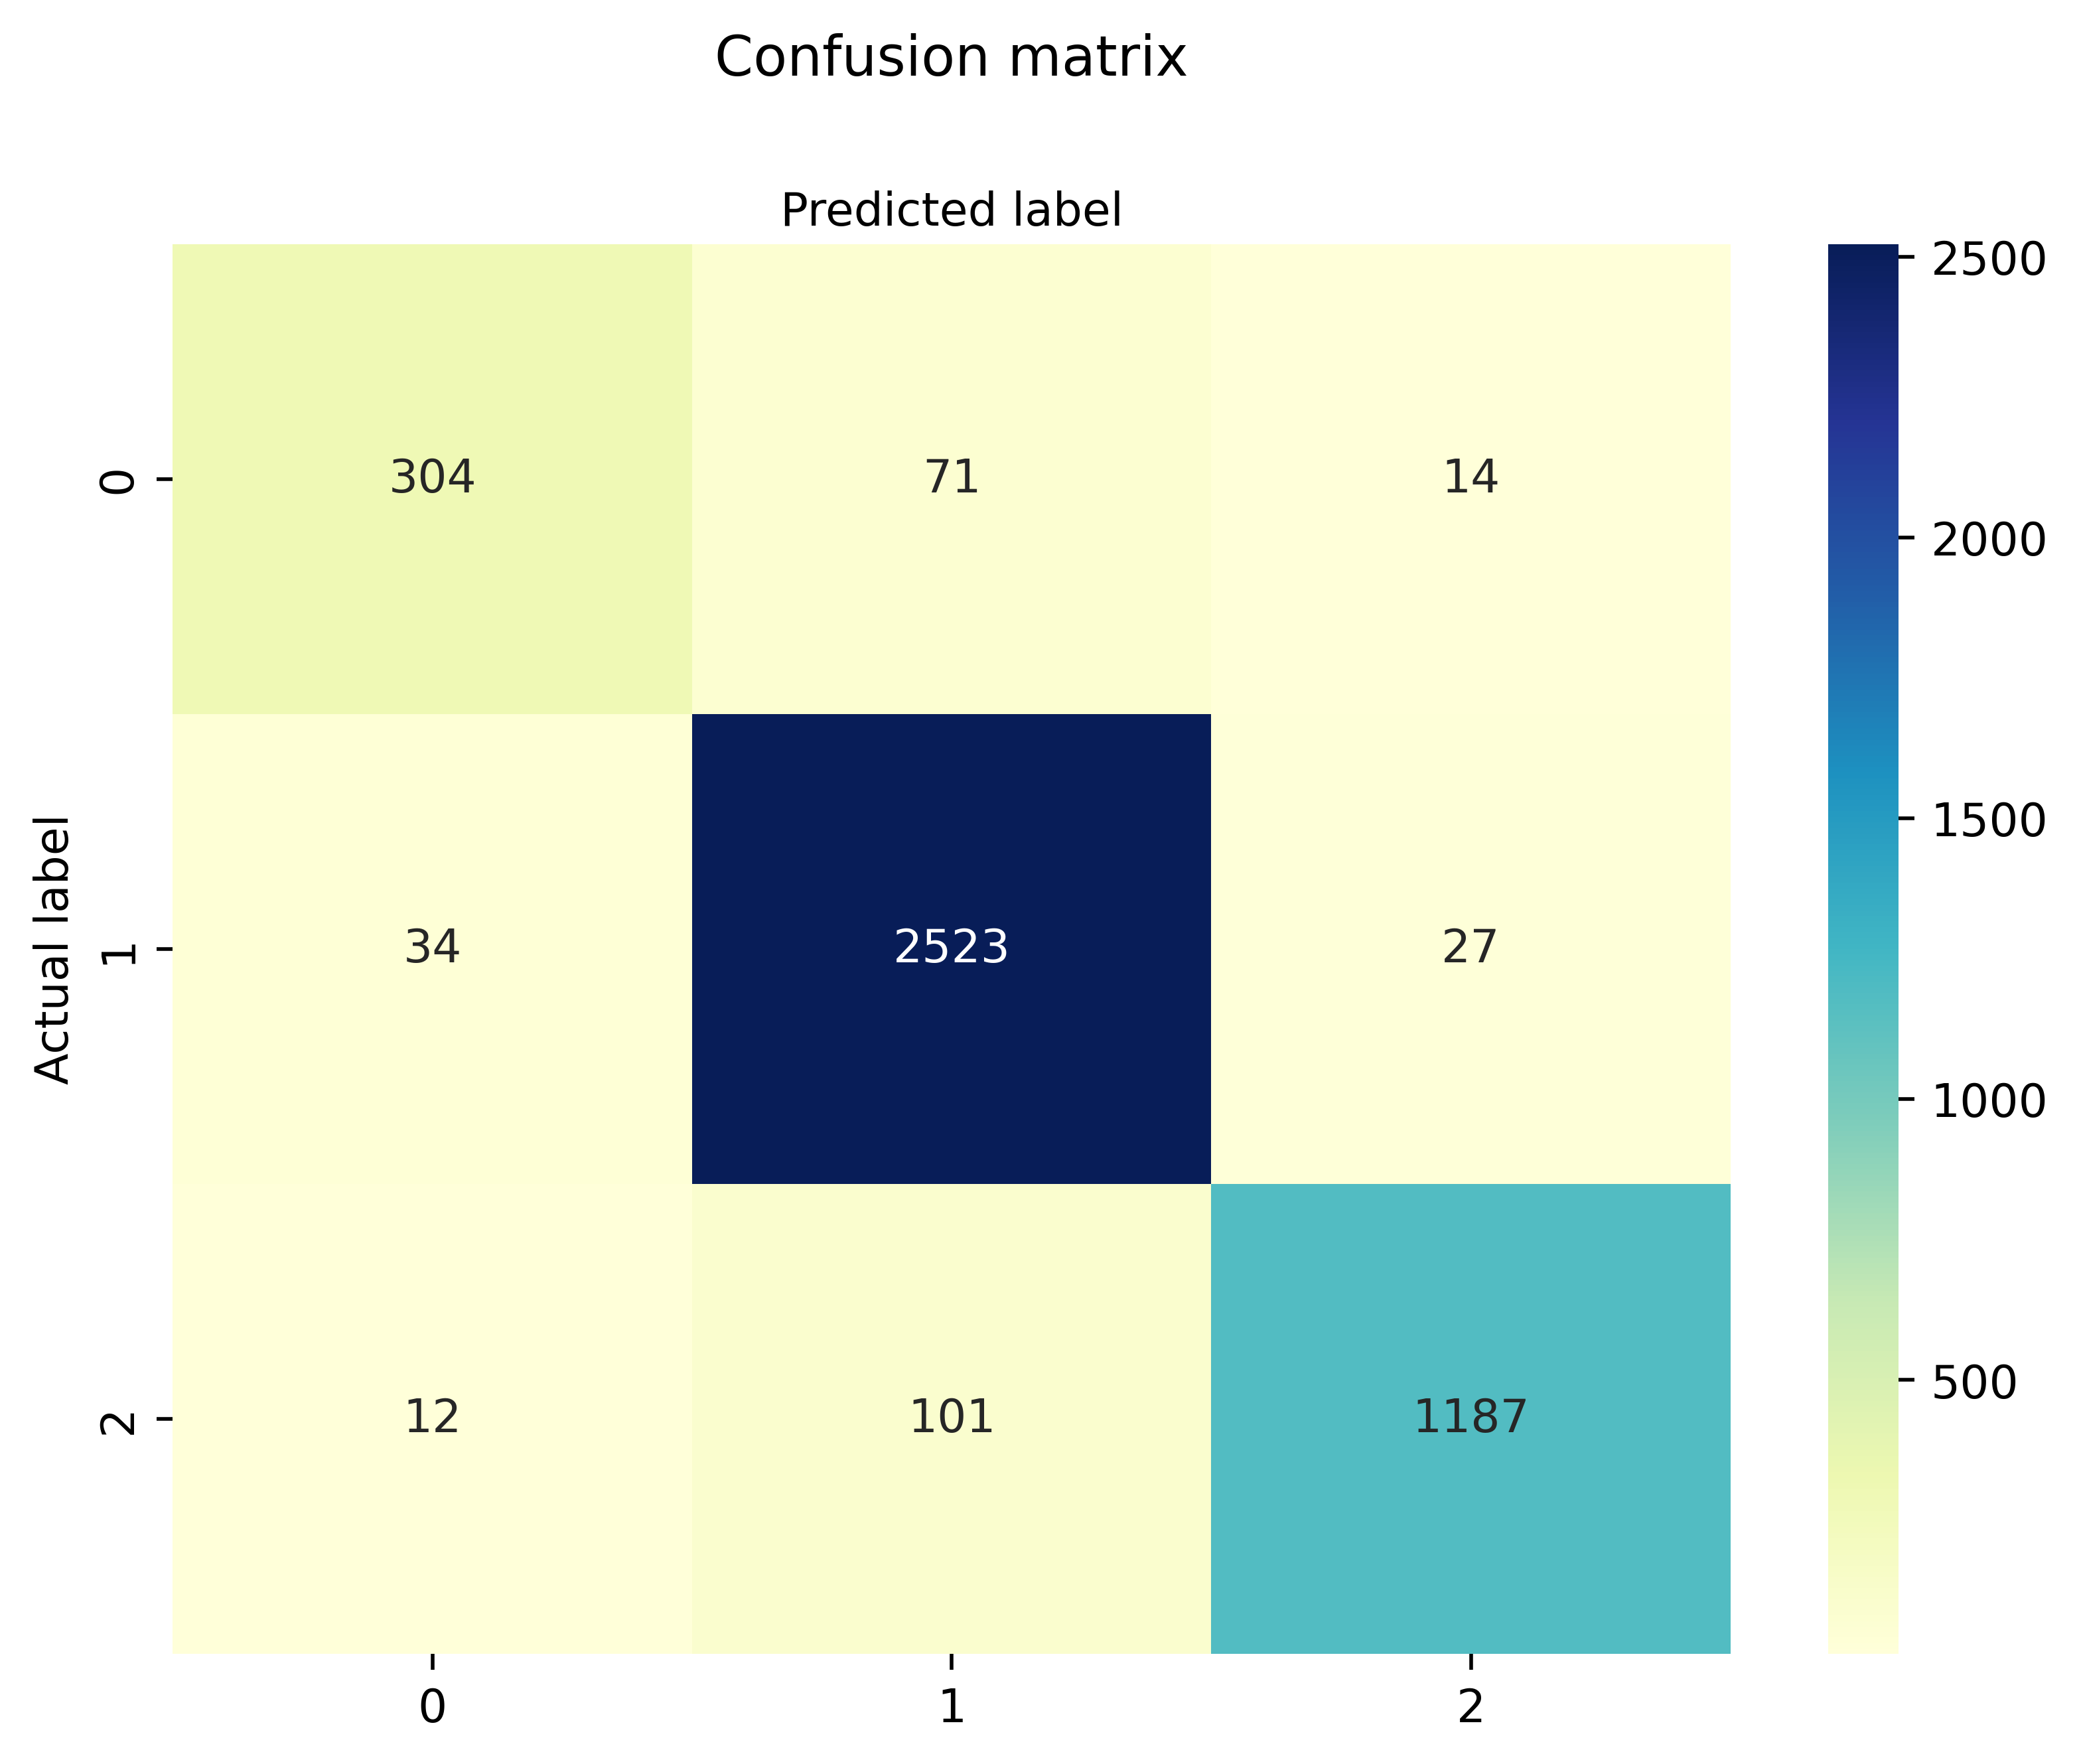

In [17]:
# Predict and evaluate the model
predictions_gb = gradient_boosting_classifier.predict(features_test_tfidf_combined)
accuracy_gb = accuracy_score(target_test, predictions_gb)
print(f"Accuracy: {accuracy_gb}")

# Calculate OOB Score
oob_score_gb = gradient_boosting_classifier.score(features_train_tfidf_combined, target_train)
print(f"\nOOB Score: {oob_score_gb}")

# Detailed classification report for Gradient Boosting Classifier
print("\nClassification Report: \n", classification_report(target_test, predictions_gb))

# Print and Plot Confusion Matrix for Gradient Boosting Classifier
cm_gb = confusion_matrix(target_test, predictions_gb)
df_cm_gb = pd.DataFrame(cm_gb, index=['-1', '0', '1'], columns=['-1', '0', '1'])
print("Confusion Matrix:\n", df_cm_gb)
plot_conf_mat(cm_gb)

## Voting Classifier

In [18]:
# Define individual Random Forest classifiers for a voting ensemble
rf_classifier1 = RandomForestClassifier(n_estimators=100)
rf_classifier2 = RandomForestClassifier(n_estimators=70)
rf_classifier3 = RandomForestClassifier(n_estimators=80)

# Create and train a Voting Classifier with the defined Random Forest models
voting_classifier = VotingClassifier(estimators=[
    ('rf1', rf_classifier1),
    ('rf2', rf_classifier2),
    ('rf3', rf_classifier3)
])
voting_classifier.fit(features_train_tfidf_combined, target_train)


VotingClassifier(estimators=[('rf1', RandomForestClassifier()),
                             ('rf2', RandomForestClassifier(n_estimators=70)),
                             ('rf3', RandomForestClassifier(n_estimators=80))])

Accuracy: 0.9426632342616429

OOB Score: 0.9992979171542242

Classification Report: 
               precision    recall  f1-score   support

          -1       0.92      0.79      0.85       389
           0       0.94      0.97      0.96      2584
           1       0.95      0.93      0.94      1300

    accuracy                           0.94      4273
   macro avg       0.94      0.90      0.92      4273
weighted avg       0.94      0.94      0.94      4273

Confusion Matrix:
      -1     0     1
-1  308    66    15
0    22  2514    48
1     4    90  1206


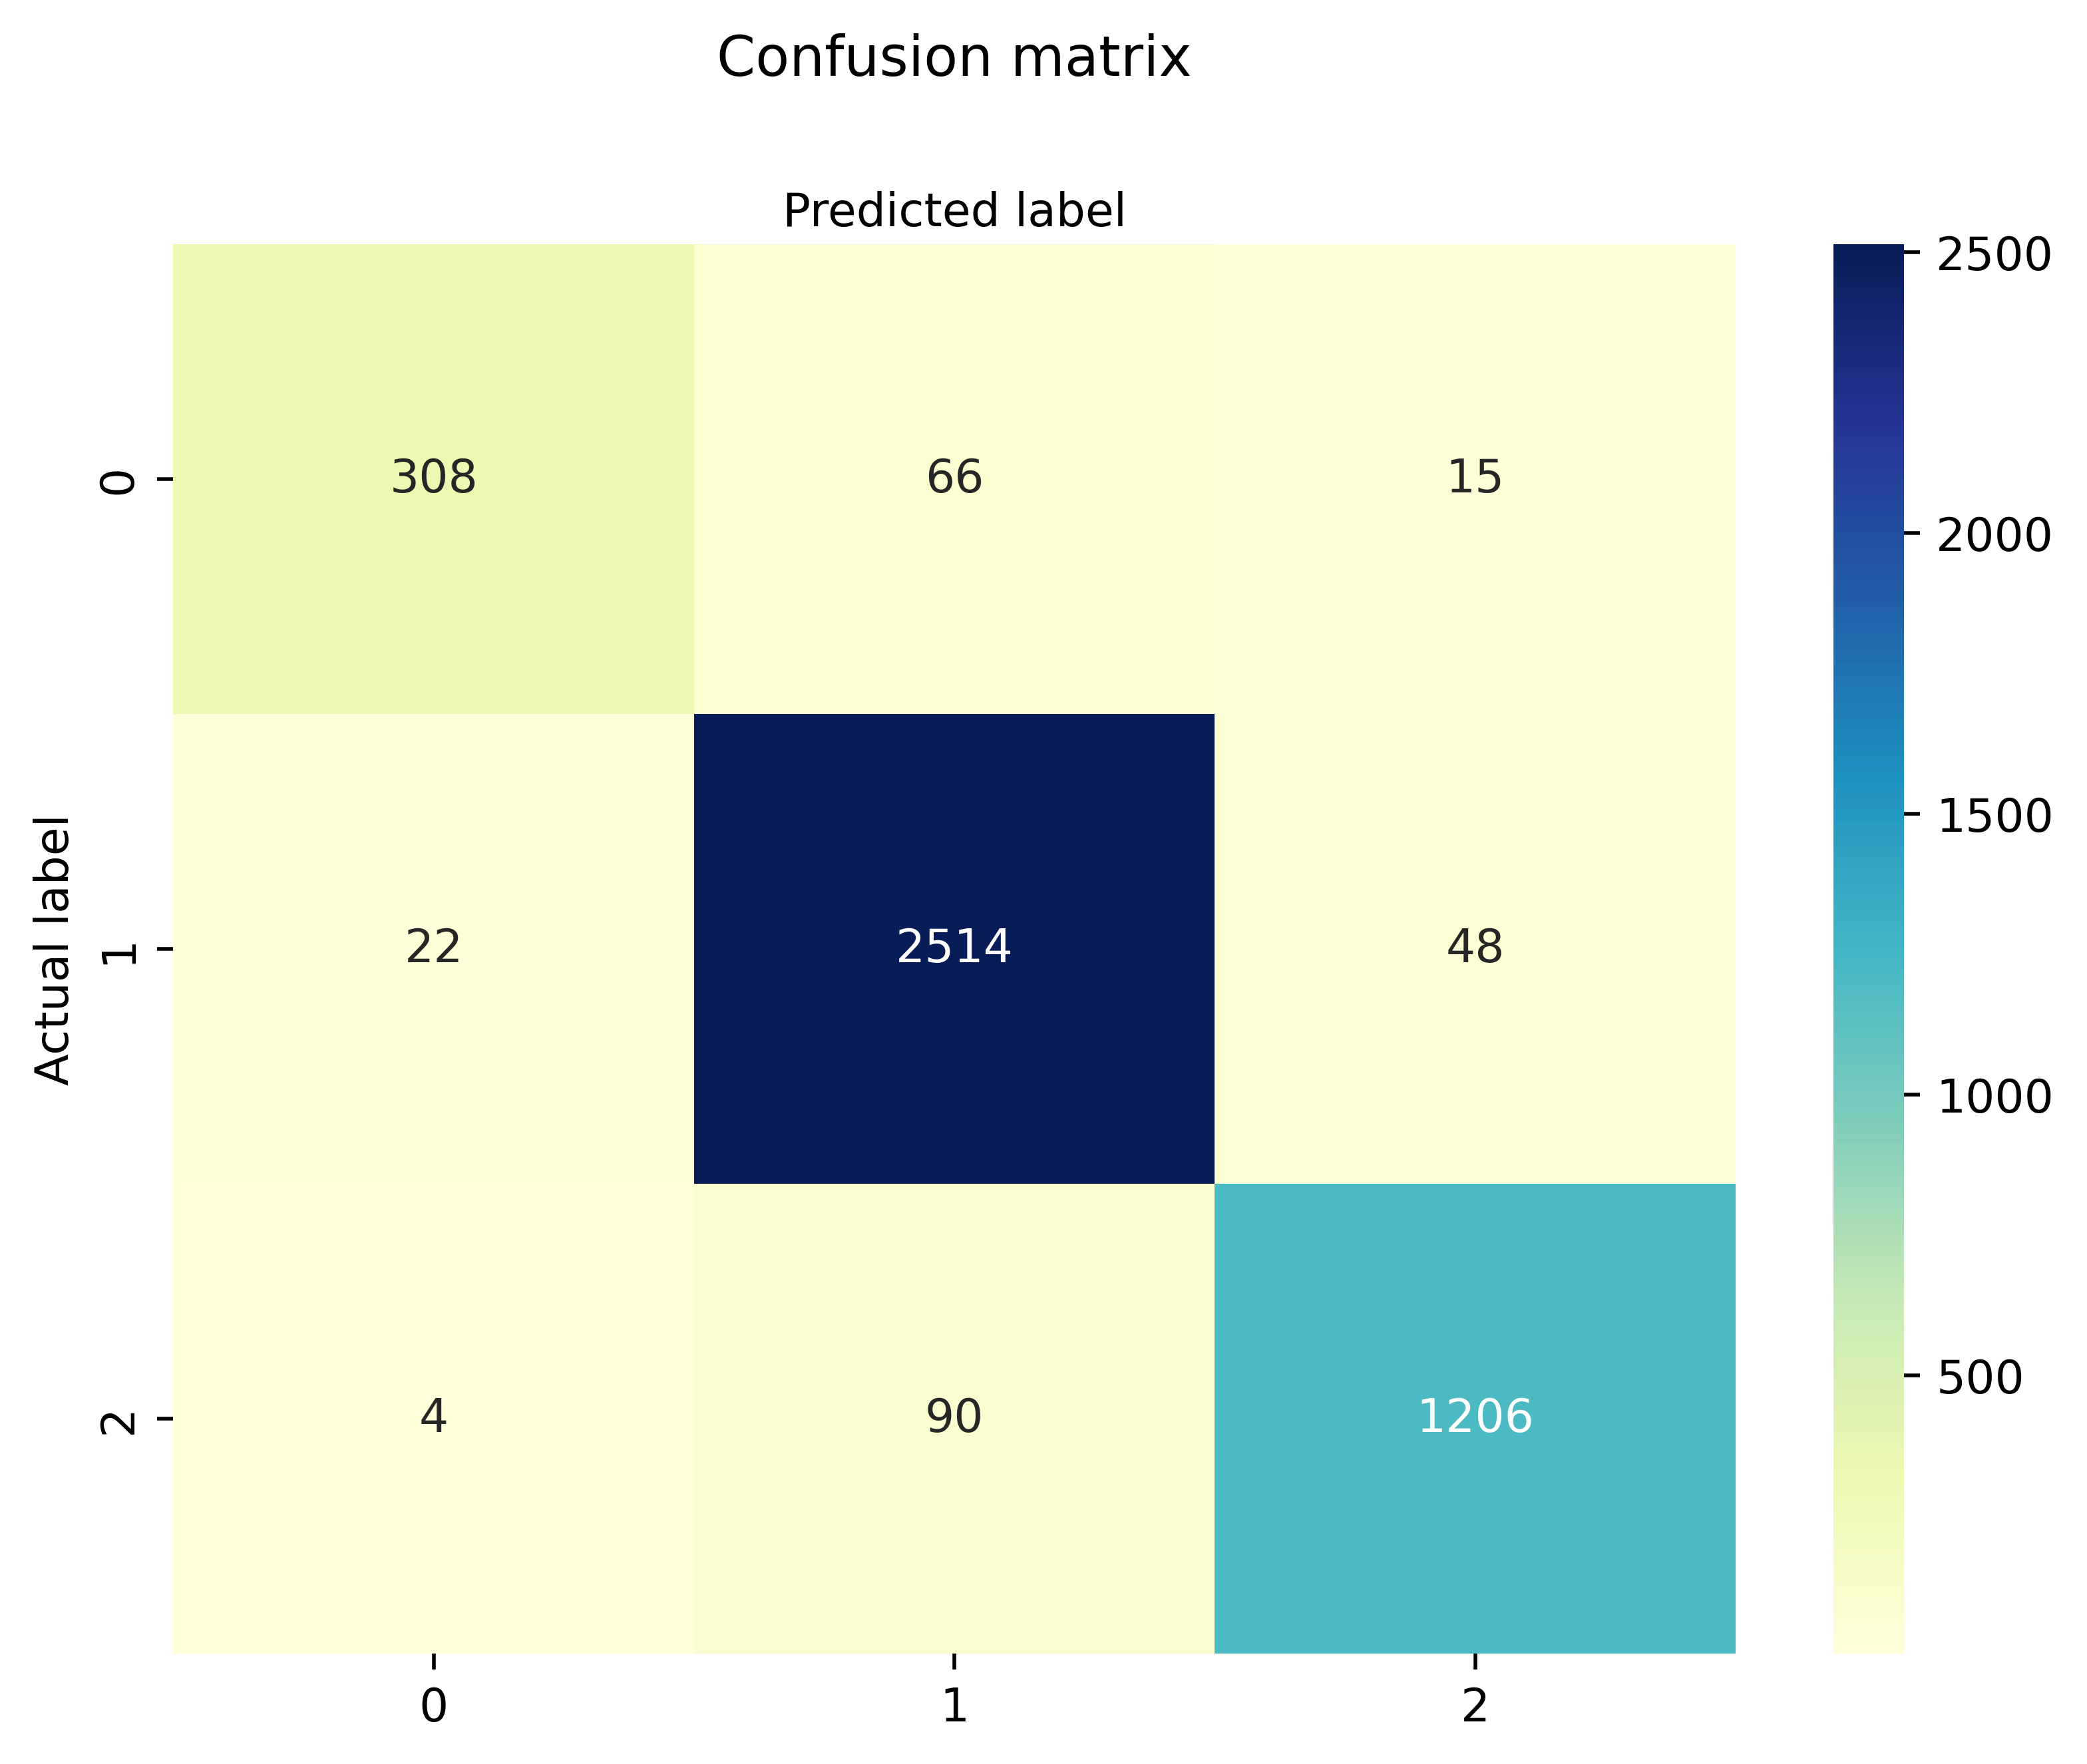

In [19]:
# Make predictions with the Voting Classifier and evaluate
predictions_voting = voting_classifier.predict(features_test_tfidf_combined)
accuracy_voting = accuracy_score(target_test, predictions_voting)
print(f"Accuracy: {accuracy_voting}")

# Calculate OOB Score
oob_score_voting = voting_classifier.score(features_train_tfidf_combined, target_train)
print(f"\nOOB Score: {oob_score_voting}")

# Detailed classification report for Voting Classifier
print("\nClassification Report: \n", classification_report(target_test, predictions_voting))

# Print and Plot Confusion Matrix for Voting Classifier
cm_voting = confusion_matrix(target_test, predictions_voting)
df_cm_voting = pd.DataFrame(cm_voting, index=['-1', '0', '1'], columns=['-1', '0', '1'])
print("Confusion Matrix:\n", df_cm_voting)
plot_conf_mat(cm_voting)

# BoW Approach

In [4]:
# Initialize TF-IDF vectorizer for the 'text' column with custom stop words
bow_vectorizer_text = CountVectorizer(stop_words=custom_stop_words, max_features=1000)
features_train_bow_text = bow_vectorizer_text.fit_transform(features_train['text'])
features_test_bow_text = bow_vectorizer_text.transform(features_test['text'])

# Initialize TF-IDF vectorizer for the 'base_url' column
bow_vectorizer_url = CountVectorizer(stop_words=custom_stop_words, max_features=1000)
features_train_bow_url = bow_vectorizer_url.fit_transform(features_train['base_url'])
features_test_bow_url = bow_vectorizer_url.transform(features_test['base_url'])

# Initialize TF-IDF vectorizer for the 'company_names' column
bow_vectorizer_company_names = CountVectorizer(stop_words=custom_stop_words, max_features=1000)
features_train_bow_company_names = bow_vectorizer_company_names.fit_transform(features_train['company_names'])
features_test_bow_company_names = bow_vectorizer_company_names.transform(features_test['company_names'])

# Combine all TF-IDF feature matrices horizontally
features_train_bow_combined = hstack([features_train_bow_text, features_train_bow_url, features_train_bow_company_names])
features_test_bow_combined = hstack([features_test_bow_text, features_test_bow_url, features_test_bow_company_names])

## Vanilla Random Forest Classifier

In [21]:
# Define and train a Random Forest classifier
random_forest_classifier = RandomForestClassifier(random_state=50, oob_score=True)
random_forest_classifier.fit(features_train_bow_combined, target_train)

RandomForestClassifier(oob_score=True, random_state=50)

Accuracy: 0.9466417037210391

OOB Score: 0.9437748654341213

Classification Report: 
               precision    recall  f1-score   support

          -1       0.92      0.81      0.86       389
           0       0.95      0.97      0.96      2584
           1       0.95      0.94      0.94      1300

    accuracy                           0.95      4273
   macro avg       0.94      0.91      0.92      4273
weighted avg       0.95      0.95      0.95      4273


Confusion Matrix:
      -1     0     1
-1  315    60    14
0    19  2514    51
1     7    77  1216


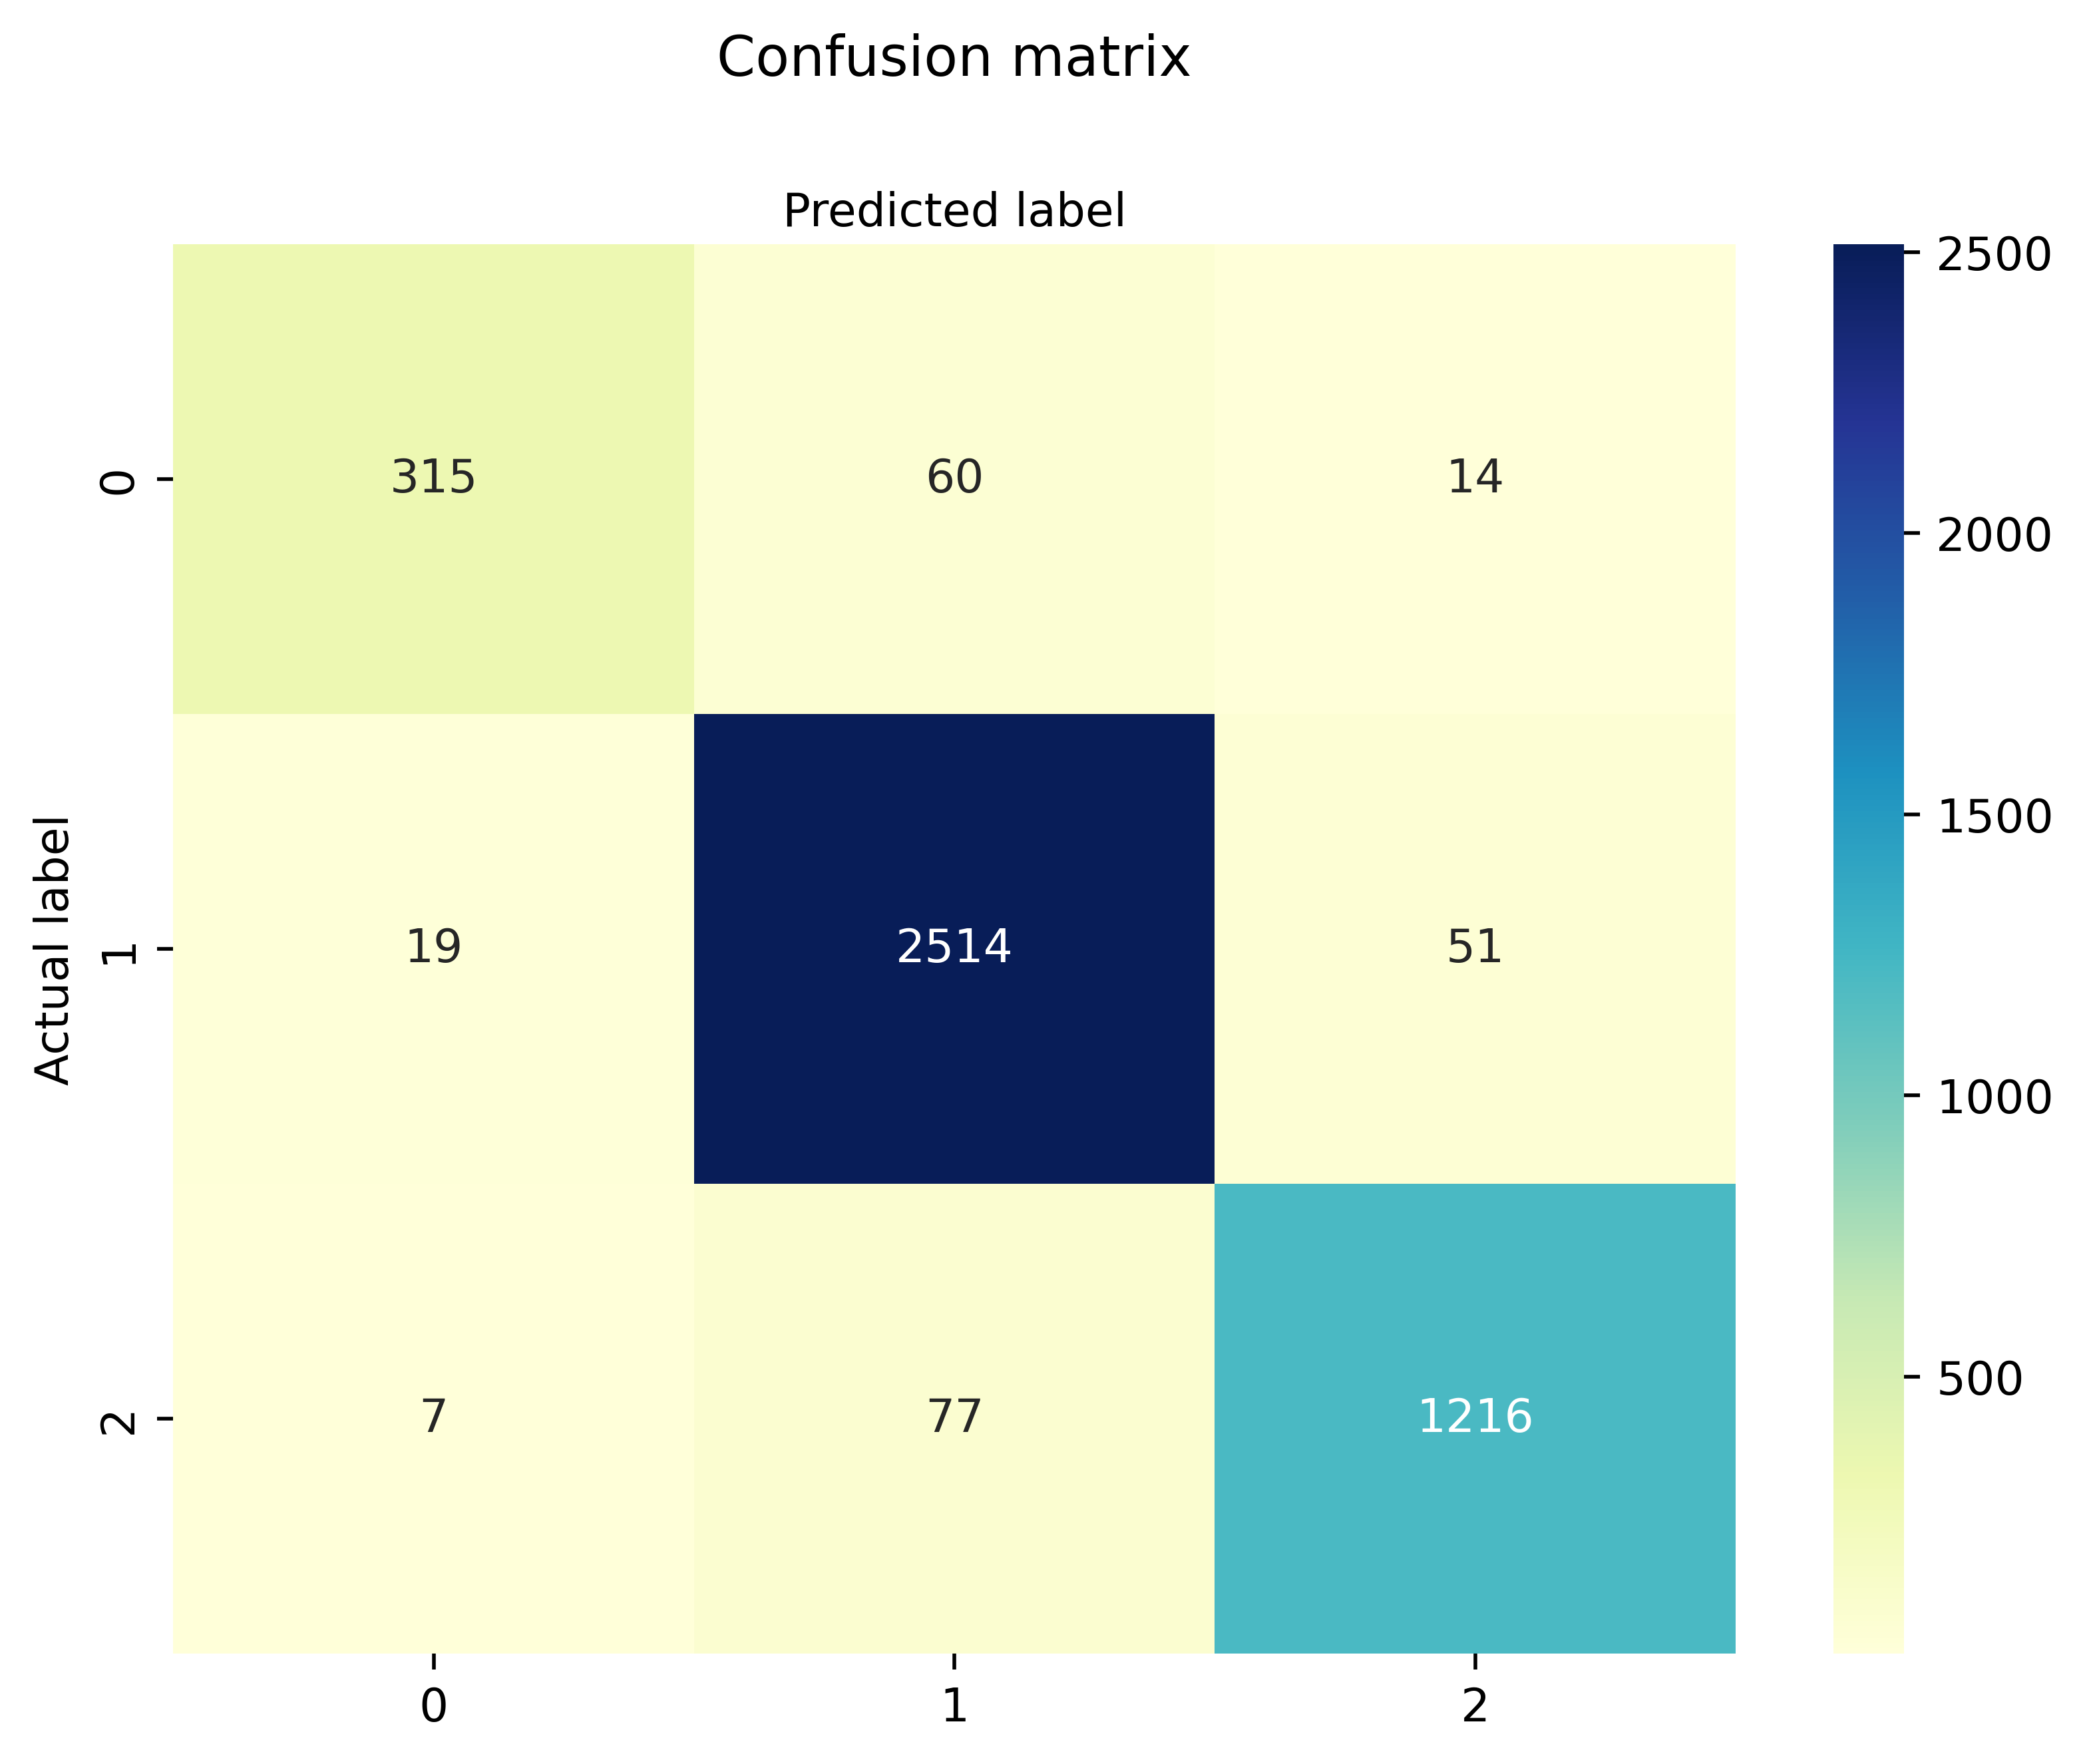

In [22]:
# Predict the sentiment on the test set and print accuracy
predictions = random_forest_classifier.predict(features_test_bow_combined)
accuracy = accuracy_score(target_test, predictions)
print(f"Accuracy: {accuracy}")

# Calculate OOB Score
oob_score = random_forest_classifier.oob_score_
print(f"\nOOB Score: {oob_score}")

# Detailed classification report
print("\nClassification Report: \n", classification_report(target_test, predictions))

# Print and Plot Confusion Matrix
cm = confusion_matrix(target_test, predictions)
df_cm = pd.DataFrame(cm, index=['-1', '0', '1'], columns=['-1', '0', '1'])
print("\nConfusion Matrix:\n", df_cm)
plot_conf_mat(cm)

## Random Forest Classifier with Feature Bagging

In [23]:
classifier_with_bagging = RandomForestClassifier(max_features='sqrt', oob_score=True)
classifier_with_bagging.fit(features_train_bow_combined, target_train)

RandomForestClassifier(oob_score=True)

Accuracy: 0.9459396208752633

OOB Score: 0.9452960449333021

Classification Report: 
               precision    recall  f1-score   support

          -1       0.93      0.79      0.86       389
           0       0.95      0.97      0.96      2584
           1       0.95      0.94      0.94      1300

    accuracy                           0.95      4273
   macro avg       0.94      0.90      0.92      4273
weighted avg       0.95      0.95      0.95      4273

Confusion Matrix:
      -1     0     1
-1  309    66    14
0    16  2514    54
1     6    75  1219


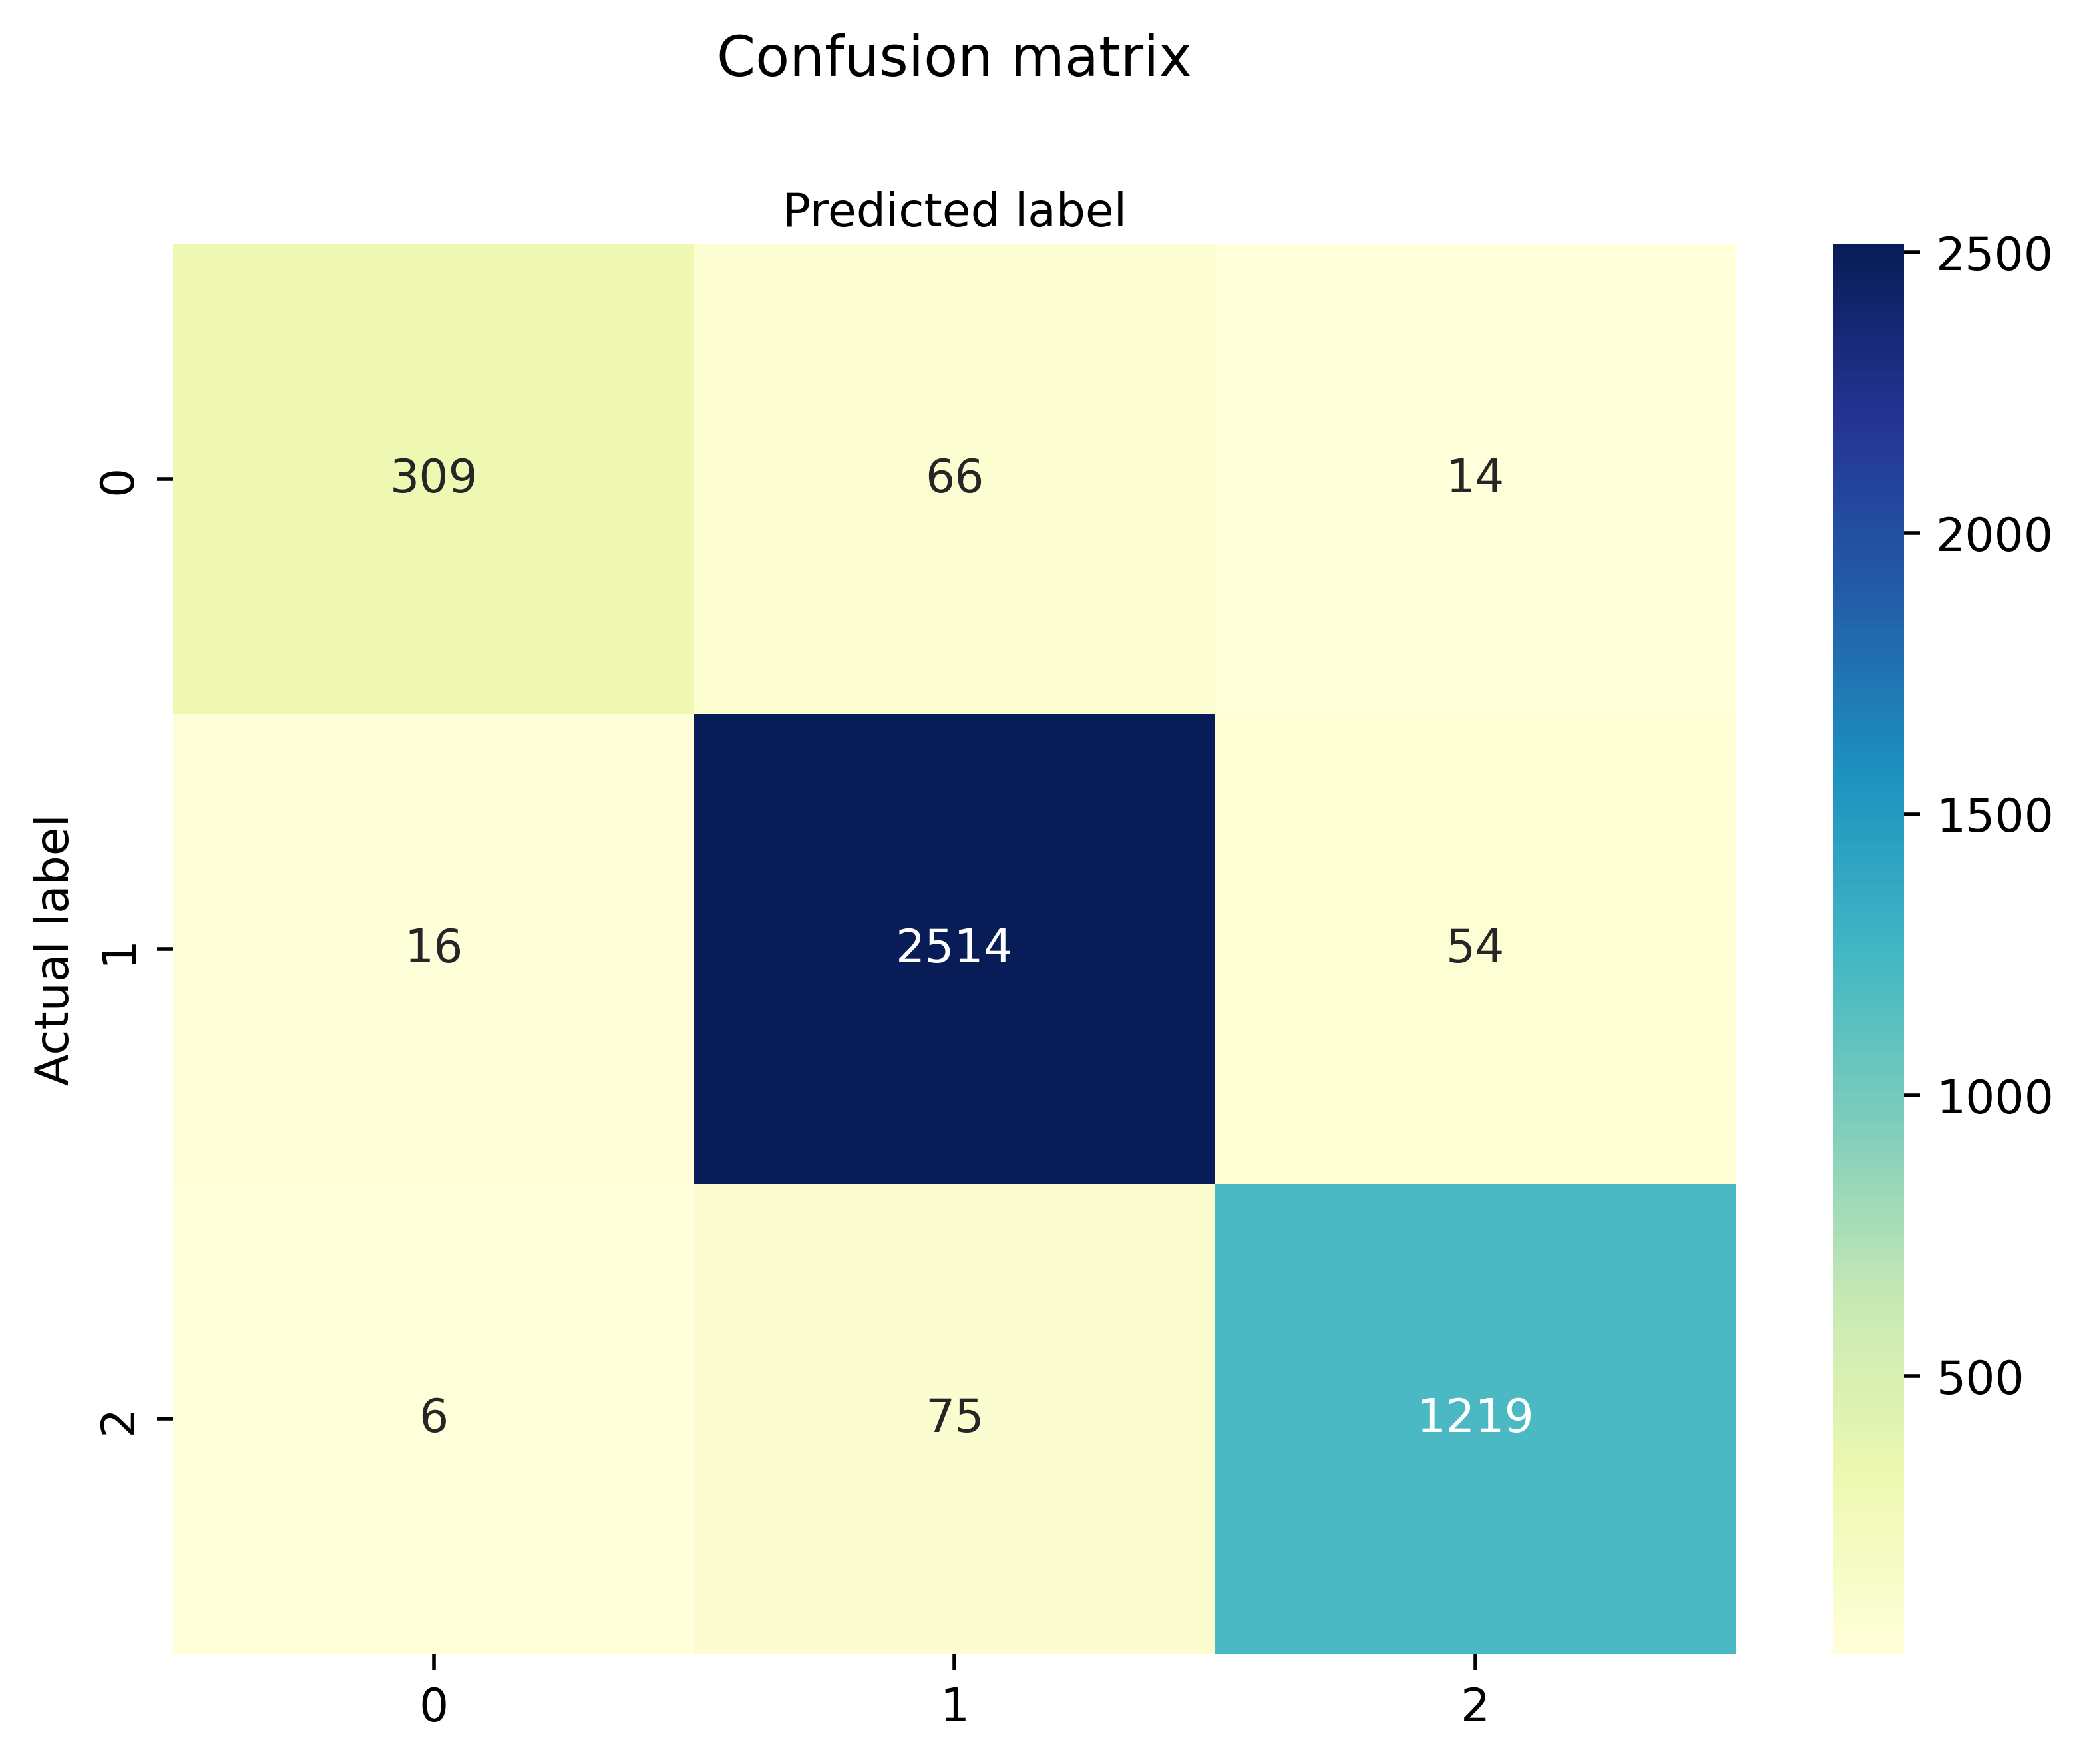

In [24]:
# Predict and evaluate the model
predictions_bagging = classifier_with_bagging.predict(features_test_bow_combined)
accuracy_bagging = accuracy_score(target_test, predictions_bagging)
print(f"Accuracy: {accuracy_bagging}")

# Calculate OOB Score
oob_score_bagging = classifier_with_bagging.oob_score_
print(f"\nOOB Score: {oob_score_bagging}")

# Detailed classification report for Bagging Classifier
print("\nClassification Report: \n", classification_report(target_test, predictions_bagging))

# Print and Plot Confusion Matrix for Bagging Classifier
cm_bagging = confusion_matrix(target_test, predictions_bagging)
df_cm_bagging = pd.DataFrame(cm_bagging, index=['-1', '0', '1'], columns=['-1', '0', '1'])
print("Confusion Matrix:\n", df_cm_bagging)
plot_conf_mat(cm_bagging)

## Gradient Boosting Classifier

In [25]:
# Gradient Boosting Classifier configuration and training
gradient_boosting_classifier = GradientBoostingClassifier(n_estimators=50, learning_rate=0.25, max_depth=10)
gradient_boosting_classifier.fit(features_train_bow_combined, target_train)

GradientBoostingClassifier(learning_rate=0.25, max_depth=10, n_estimators=50)

Accuracy: 0.9445354551837116

OOB Score: 0.9765387315703253

Classification Report: 
               precision    recall  f1-score   support

          -1       0.89      0.80      0.84       389
           0       0.94      0.98      0.96      2584
           1       0.96      0.92      0.94      1300

    accuracy                           0.94      4273
   macro avg       0.93      0.90      0.91      4273
weighted avg       0.94      0.94      0.94      4273

Confusion Matrix:
      -1     0     1
-1  310    66    13
0    28  2525    31
1    11    88  1201


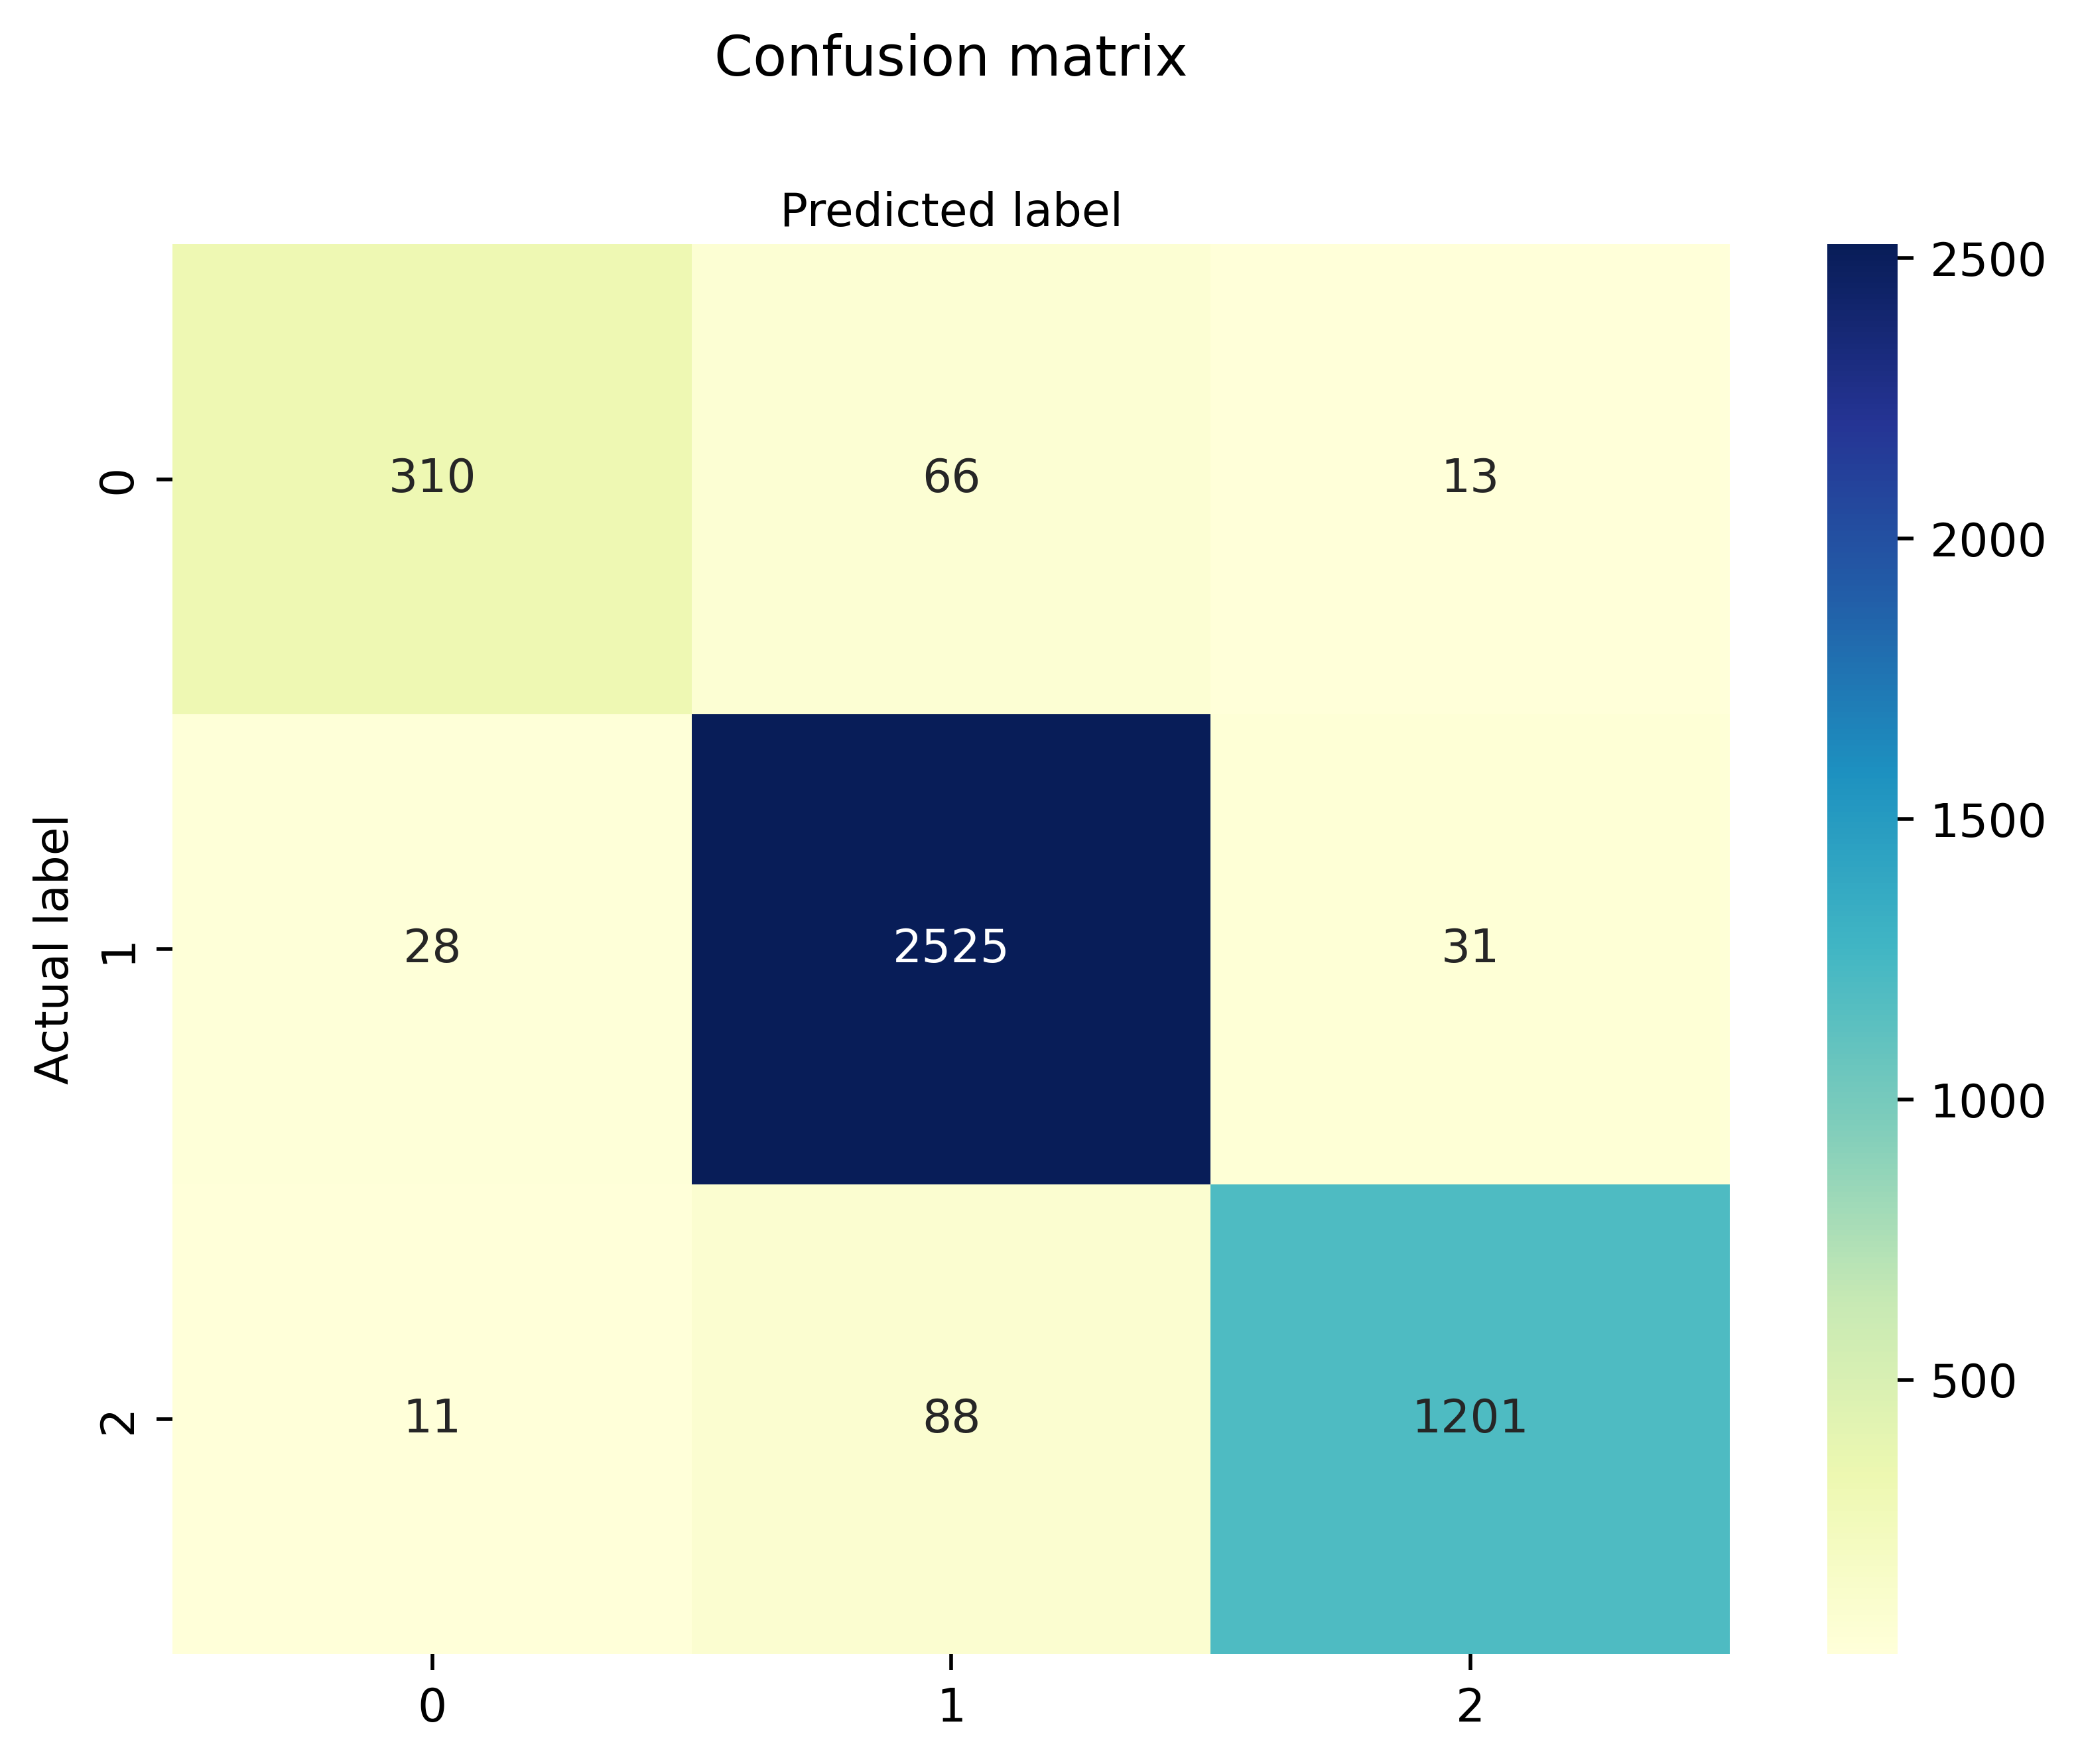

In [26]:
# Predict and evaluate the model
predictions_gb = gradient_boosting_classifier.predict(features_test_bow_combined)
accuracy_gb = accuracy_score(target_test, predictions_gb)
print(f"Accuracy: {accuracy_gb}")

# Calculate OOB Score
oob_score_gb = gradient_boosting_classifier.score(features_train_bow_combined, target_train)
print(f"\nOOB Score: {oob_score_gb}")

# Detailed classification report for Gradient Boosting Classifier
print("\nClassification Report: \n", classification_report(target_test, predictions_gb))

# Print and Plot Confusion Matrix for Gradient Boosting Classifier
cm_gb = confusion_matrix(target_test, predictions_gb)
df_cm_gb = pd.DataFrame(cm_gb, index=['-1', '0', '1'], columns=['-1', '0', '1'])
print("Confusion Matrix:\n", df_cm_gb)
plot_conf_mat(cm_gb)

## Voting Classifier

In [27]:
# Define individual Random Forest classifiers for a voting ensemble
rf_classifier1 = RandomForestClassifier(n_estimators=100)
rf_classifier2 = RandomForestClassifier(n_estimators=70)
rf_classifier3 = RandomForestClassifier(n_estimators=80)

# Create and train a Voting Classifier with the defined Random Forest models
voting_classifier = VotingClassifier(estimators=[
    ('rf1', rf_classifier1),
    ('rf2', rf_classifier2),
    ('rf3', rf_classifier3)
])
voting_classifier.fit(features_train_bow_combined, target_train)


VotingClassifier(estimators=[('rf1', RandomForestClassifier()),
                             ('rf2', RandomForestClassifier(n_estimators=70)),
                             ('rf3', RandomForestClassifier(n_estimators=80))])

Accuracy: 0.9466417037210391

OOB Score: 0.9993564240580388

Classification Report: 
               precision    recall  f1-score   support

          -1       0.94      0.79      0.85       389
           0       0.95      0.98      0.96      2584
           1       0.95      0.94      0.94      1300

    accuracy                           0.95      4273
   macro avg       0.94      0.90      0.92      4273
weighted avg       0.95      0.95      0.95      4273

Confusion Matrix:
      -1     0     1
-1  306    67    16
0    15  2520    49
1     6    75  1219


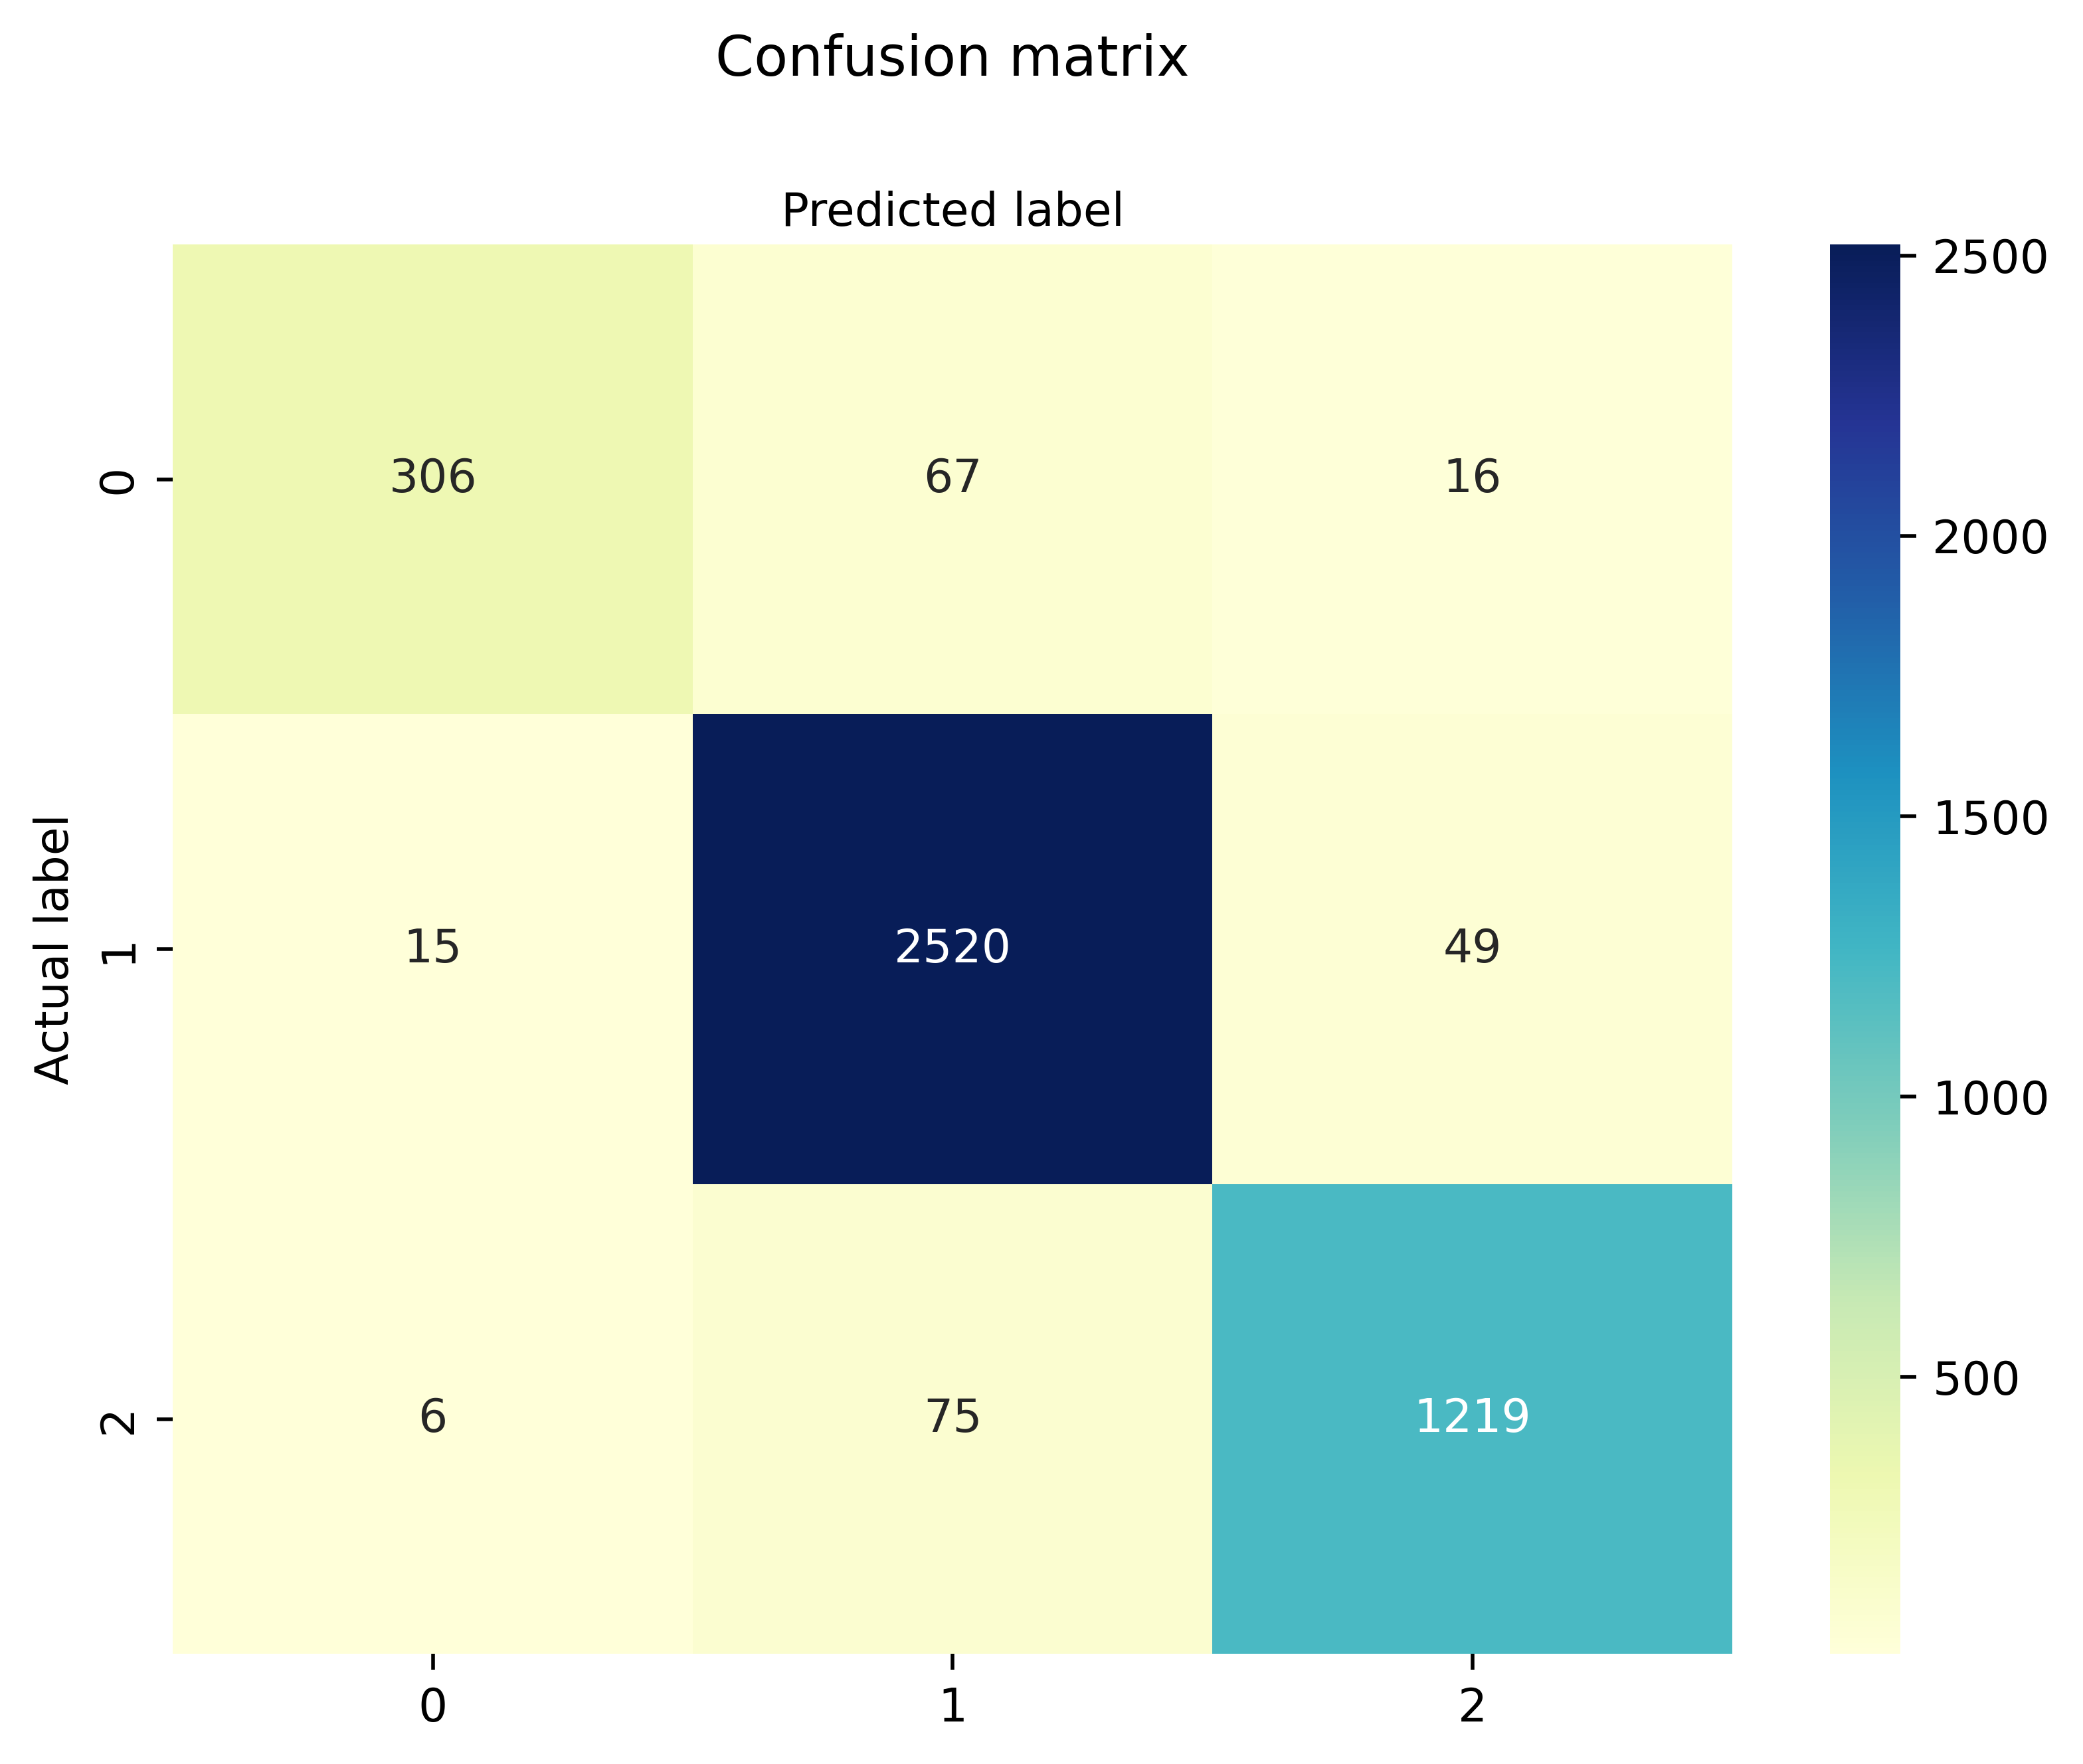

In [28]:
# Make predictions with the Voting Classifier and evaluate
predictions_voting = voting_classifier.predict(features_test_bow_combined)
accuracy_voting = accuracy_score(target_test, predictions_voting)
print(f"Accuracy: {accuracy_voting}")

# Calculate OOB Score
oob_score_voting = voting_classifier.score(features_train_bow_combined, target_train)
print(f"\nOOB Score: {oob_score_voting}")

# Detailed classification report for Voting Classifier
print("\nClassification Report: \n", classification_report(target_test, predictions_voting))

# Print and Plot Confusion Matrix for Voting Classifier
cm_voting = confusion_matrix(target_test, predictions_voting)
df_cm_voting = pd.DataFrame(cm_voting, index=['-1', '0', '1'], columns=['-1', '0', '1'])
print("Confusion Matrix:\n", df_cm_voting)
plot_conf_mat(cm_voting)

# Repeated K-Fold Cross Validation

## Vanilla Random Forest Classifier

In [7]:
def evaluate_model(features, target, num_repeats):
    # Initialize the RandomForest classifier with out-of-bag estimates
    model = RandomForestClassifier(random_state=50, oob_score=True)
    # Prepare the cross-validation procedure
    cv = RepeatedKFold(n_splits=10, n_repeats=num_repeats, random_state=1)
    # Evaluate the model
    scores = cross_val_score(model, features, target, scoring='accuracy', cv=cv, n_jobs=-1)
    # Fit the model to get the OOB score
    model.fit(features, target)
    return scores, model.oob_score_

In [8]:
# Evaluation parameters
repeats = range(1, 10)  # Number of repeats for cross-validation

### TF-IDF

Cross-Validation Repeats: 1, Mean Accuracy: 0.9431, SEM: 0.002, OOB Score: 0.9427
Cross-Validation Repeats: 2, Mean Accuracy: 0.9436, SEM: 0.001, OOB Score: 0.9427
Cross-Validation Repeats: 3, Mean Accuracy: 0.9433, SEM: 0.001, OOB Score: 0.9427
Cross-Validation Repeats: 4, Mean Accuracy: 0.9433, SEM: 0.001, OOB Score: 0.9427
Cross-Validation Repeats: 5, Mean Accuracy: 0.9432, SEM: 0.001, OOB Score: 0.9427
Cross-Validation Repeats: 6, Mean Accuracy: 0.9432, SEM: 0.001, OOB Score: 0.9427
Cross-Validation Repeats: 7, Mean Accuracy: 0.9432, SEM: 0.001, OOB Score: 0.9427
Cross-Validation Repeats: 8, Mean Accuracy: 0.9433, SEM: 0.001, OOB Score: 0.9427
Cross-Validation Repeats: 9, Mean Accuracy: 0.9432, SEM: 0.001, OOB Score: 0.9427


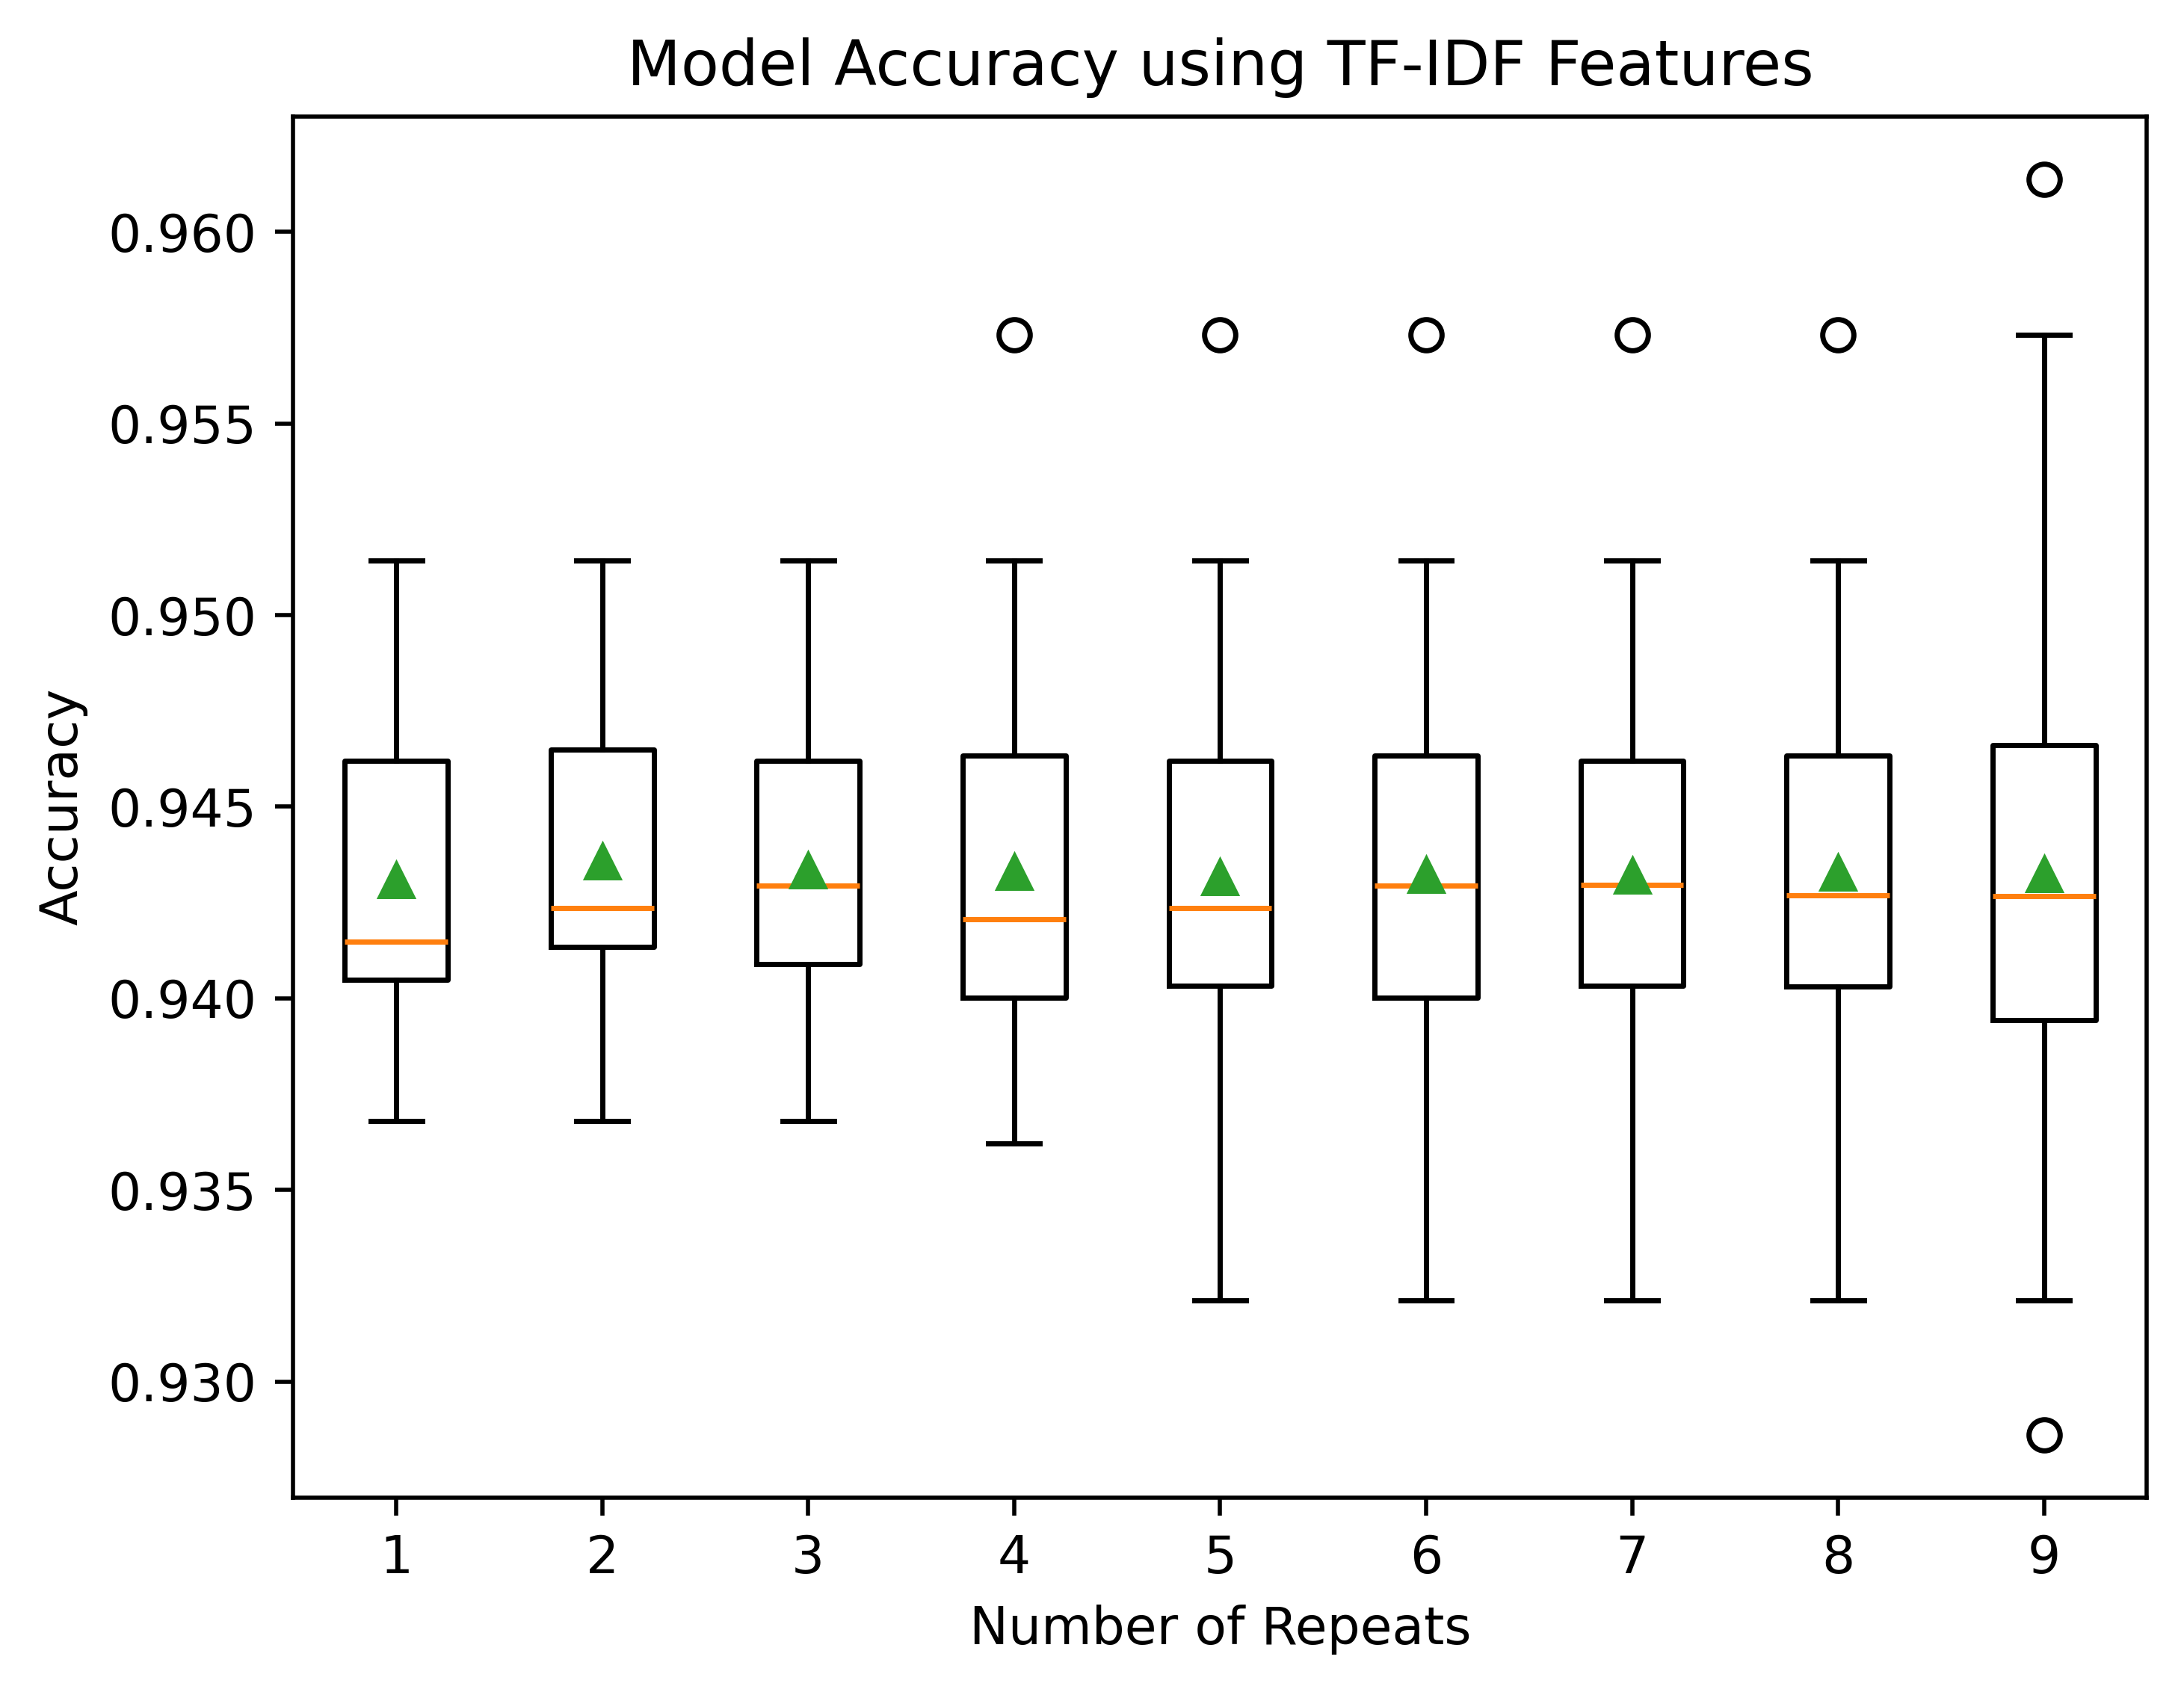

In [9]:
results = []  # List to store the results of each evaluation

# Evaluate the model using TF-IDF combined features
for r in repeats:
    # Evaluate the model using a specific number of repeats
    scores, oob_score = evaluate_model(features_train_tfidf_combined, target_train, r)
    # Summarize and print the mean accuracy, SEM, and OOB score
    print(f'Cross-Validation Repeats: {r}, Mean Accuracy: {np.mean(scores):.4f}, SEM: {sem(scores):.3f}, OOB Score: {oob_score:.4f}')
    # Store the results
    results.append(scores)

# Plot the results of the evaluations
plt.boxplot(results, labels=[str(r) for r in repeats], showmeans=True)
plt.title('Model Accuracy using TF-IDF Features')
plt.ylabel('Accuracy')
plt.xlabel('Number of Repeats')
plt.show()

# Save results
model = "rf_vanilla_tfidf"
results = pd.DataFrame(results)
results.to_csv(f'k-fold_results/1/{model}.csv', index=False)

### BoW

Cross-Validation Repeats: 1, Mean Accuracy: 0.9449, SEM: 0.001, OOB Score: 0.9439
Cross-Validation Repeats: 2, Mean Accuracy: 0.9449, SEM: 0.001, OOB Score: 0.9439
Cross-Validation Repeats: 3, Mean Accuracy: 0.9447, SEM: 0.001, OOB Score: 0.9439
Cross-Validation Repeats: 4, Mean Accuracy: 0.9448, SEM: 0.001, OOB Score: 0.9439
Cross-Validation Repeats: 5, Mean Accuracy: 0.9450, SEM: 0.001, OOB Score: 0.9439
Cross-Validation Repeats: 6, Mean Accuracy: 0.9451, SEM: 0.001, OOB Score: 0.9439
Cross-Validation Repeats: 7, Mean Accuracy: 0.9452, SEM: 0.001, OOB Score: 0.9439
Cross-Validation Repeats: 8, Mean Accuracy: 0.9453, SEM: 0.001, OOB Score: 0.9439
Cross-Validation Repeats: 9, Mean Accuracy: 0.9453, SEM: 0.001, OOB Score: 0.9439


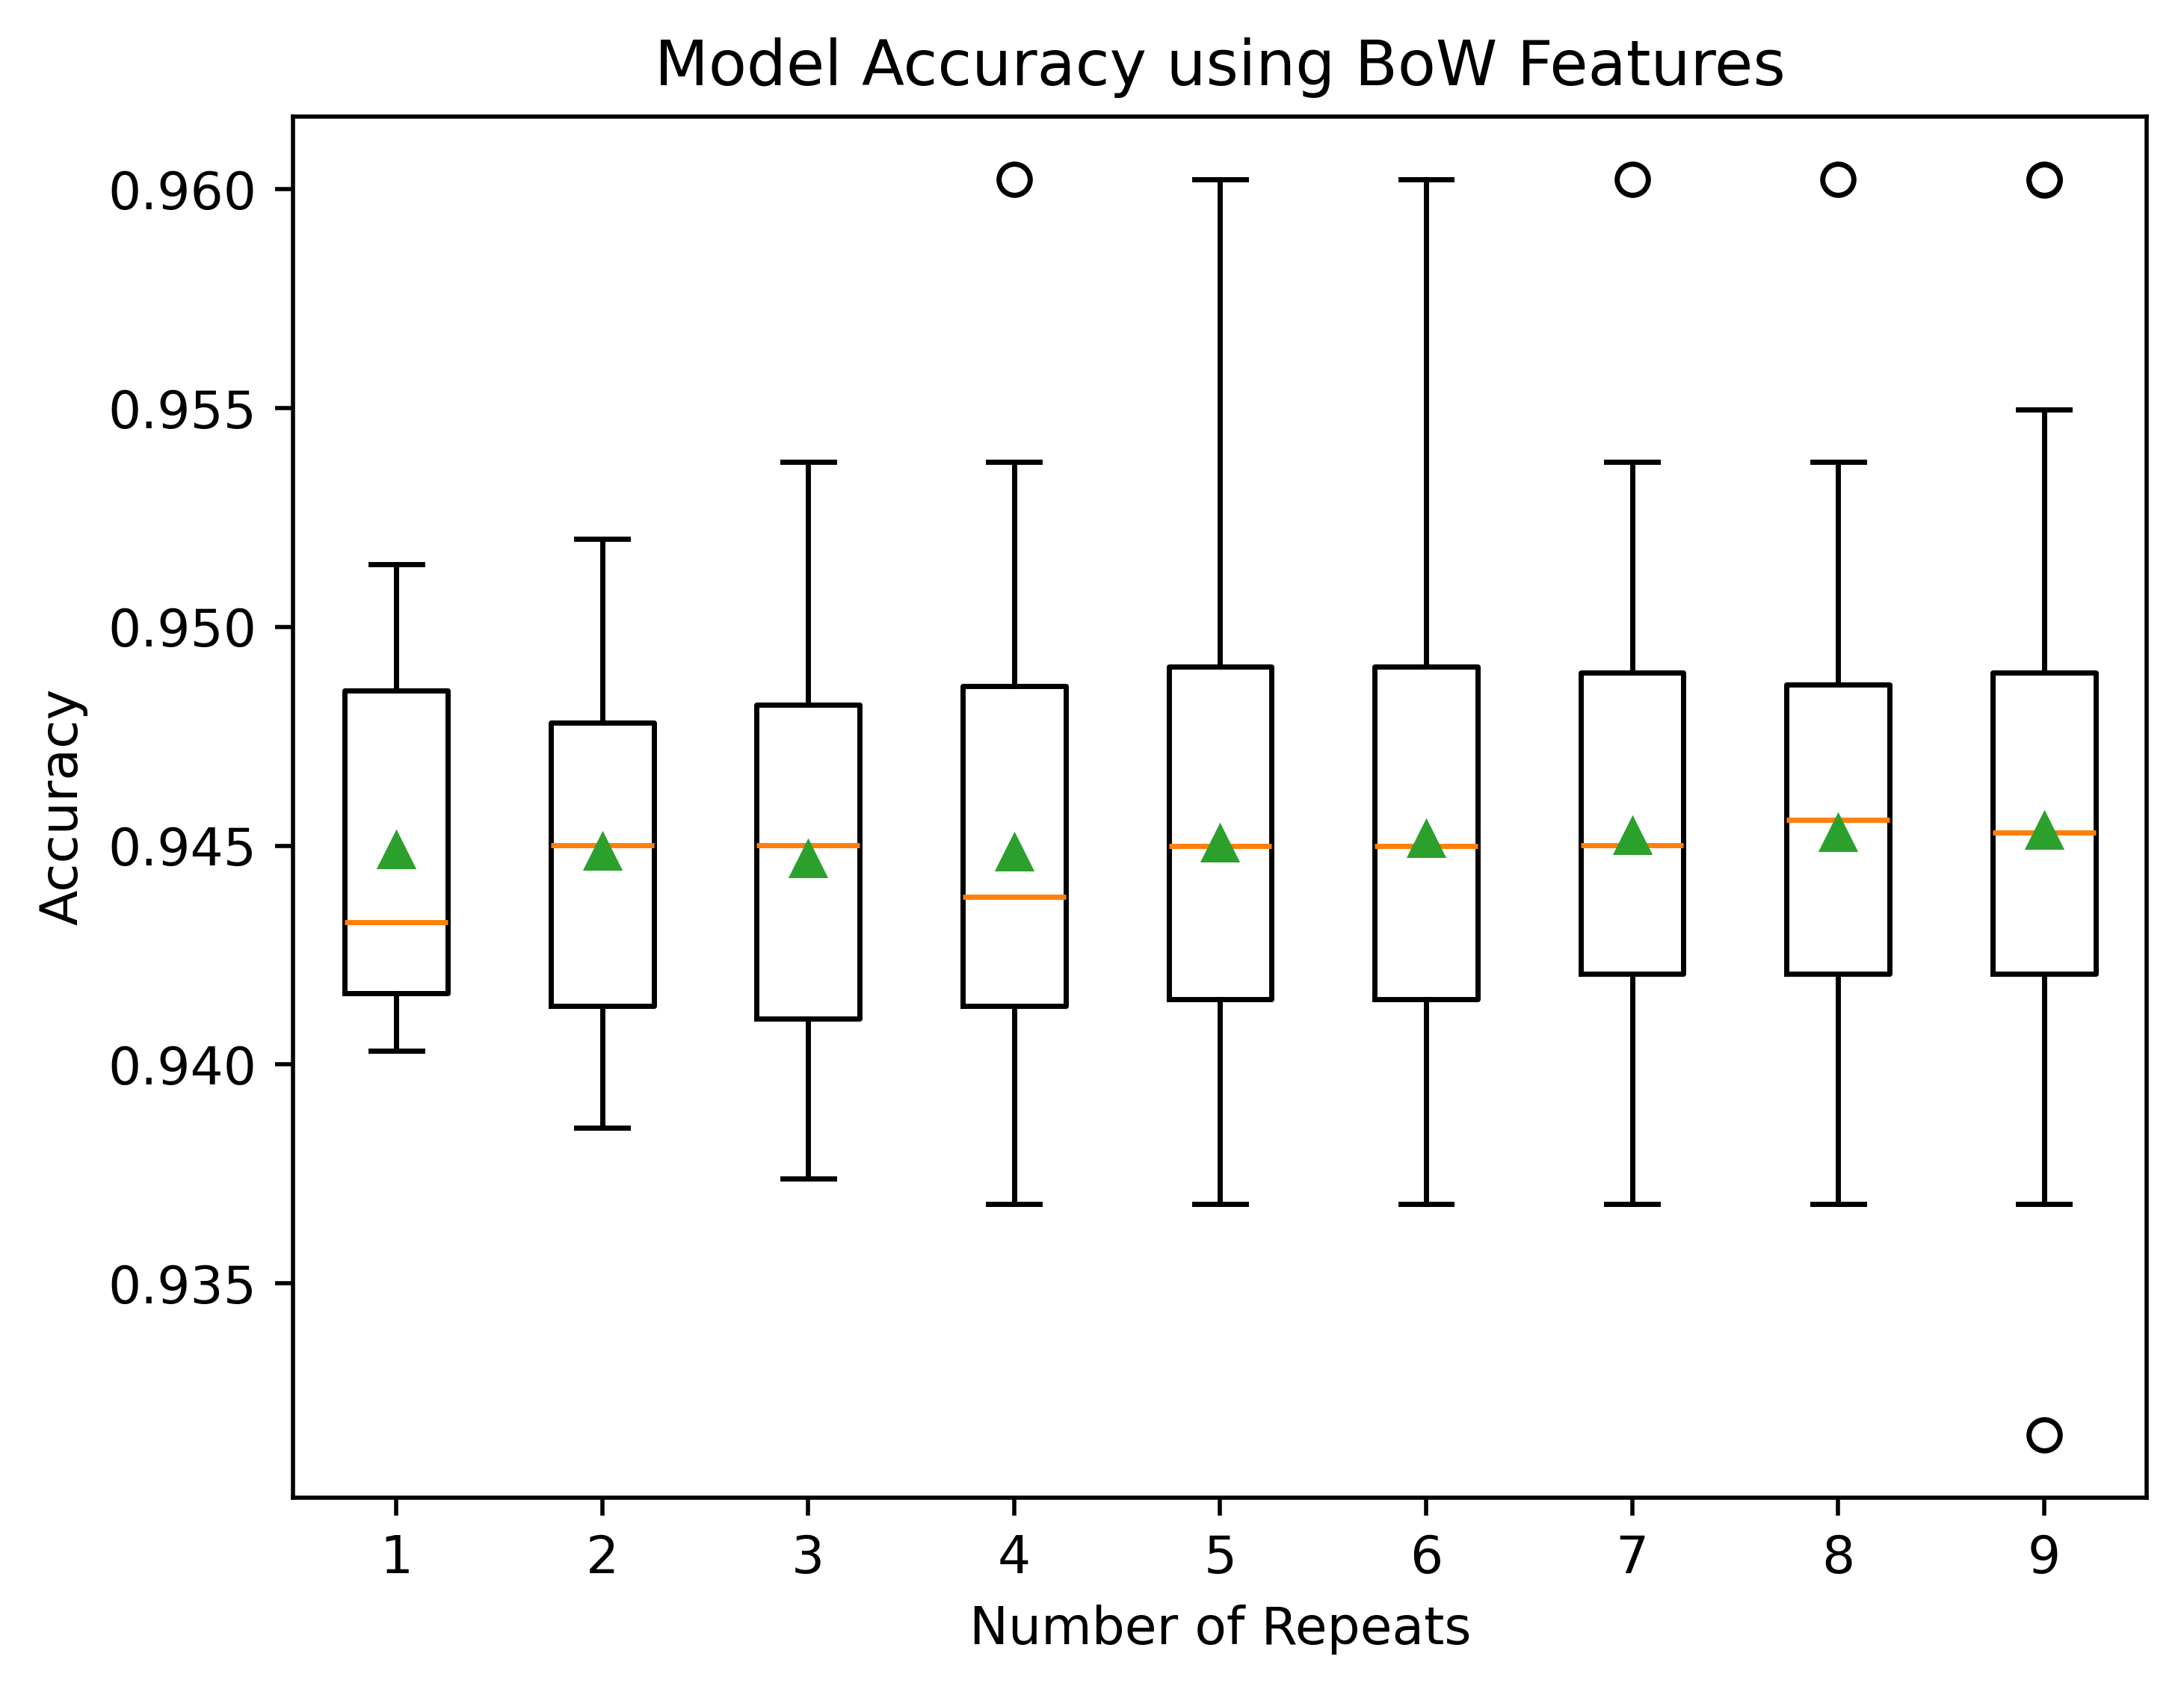

In [10]:
# Clear previous results
results = []

# Evaluate the model using BoW combined features
for r in repeats:
    # Evaluate the model using a specific number of repeats
    scores, oob_score = evaluate_model(features_train_bow_combined, target_train, r)
    # Summarize and print the mean accuracy, SEM, and OOB score
    print(f'Cross-Validation Repeats: {r}, Mean Accuracy: {np.mean(scores):.4f}, SEM: {sem(scores):.3f}, OOB Score: {oob_score:.4f}')
    # Store the results
    results.append(scores)

# Plot the results of the evaluations
plt.boxplot(results, labels=[str(r) for r in repeats], showmeans=True)
plt.title('Model Accuracy using BoW Features')
plt.ylabel('Accuracy')
plt.xlabel('Number of Repeats')
plt.show()

# Save results
model = "rf_vanilla_bow"
results = pd.DataFrame(results)
results.to_csv(f'k-fold_results/1/{model}.csv', index=False)

## Random Forest Classifier with Feature Bagging

### TF-IDF

In [11]:
def evaluate_model(features, target, num_repeats):
    # Initialize the RandomForest classifier with out-of-bag estimates
    model = RandomForestClassifier(max_features='sqrt', random_state=50, oob_score=True)
    # Prepare the cross-validation procedure
    cv = RepeatedKFold(n_splits=10, n_repeats=num_repeats, random_state=1)
    # Evaluate the model
    scores = cross_val_score(model, features, target, scoring='accuracy', cv=cv, n_jobs=-1)
    # Fit the model to get the OOB score
    model.fit(features, target)
    return scores, model.oob_score_

# Evaluation parameters
repeats = range(1, 10)  # Number of repeats for cross-validation

Cross-Validation Repeats: 1, Mean Accuracy: 0.9431, SEM: 0.002, OOB Score: 0.9427
Cross-Validation Repeats: 2, Mean Accuracy: 0.9436, SEM: 0.001, OOB Score: 0.9427
Cross-Validation Repeats: 3, Mean Accuracy: 0.9433, SEM: 0.001, OOB Score: 0.9427
Cross-Validation Repeats: 4, Mean Accuracy: 0.9433, SEM: 0.001, OOB Score: 0.9427
Cross-Validation Repeats: 5, Mean Accuracy: 0.9432, SEM: 0.001, OOB Score: 0.9427
Cross-Validation Repeats: 6, Mean Accuracy: 0.9432, SEM: 0.001, OOB Score: 0.9427
Cross-Validation Repeats: 7, Mean Accuracy: 0.9432, SEM: 0.001, OOB Score: 0.9427
Cross-Validation Repeats: 8, Mean Accuracy: 0.9433, SEM: 0.001, OOB Score: 0.9427
Cross-Validation Repeats: 9, Mean Accuracy: 0.9432, SEM: 0.001, OOB Score: 0.9427


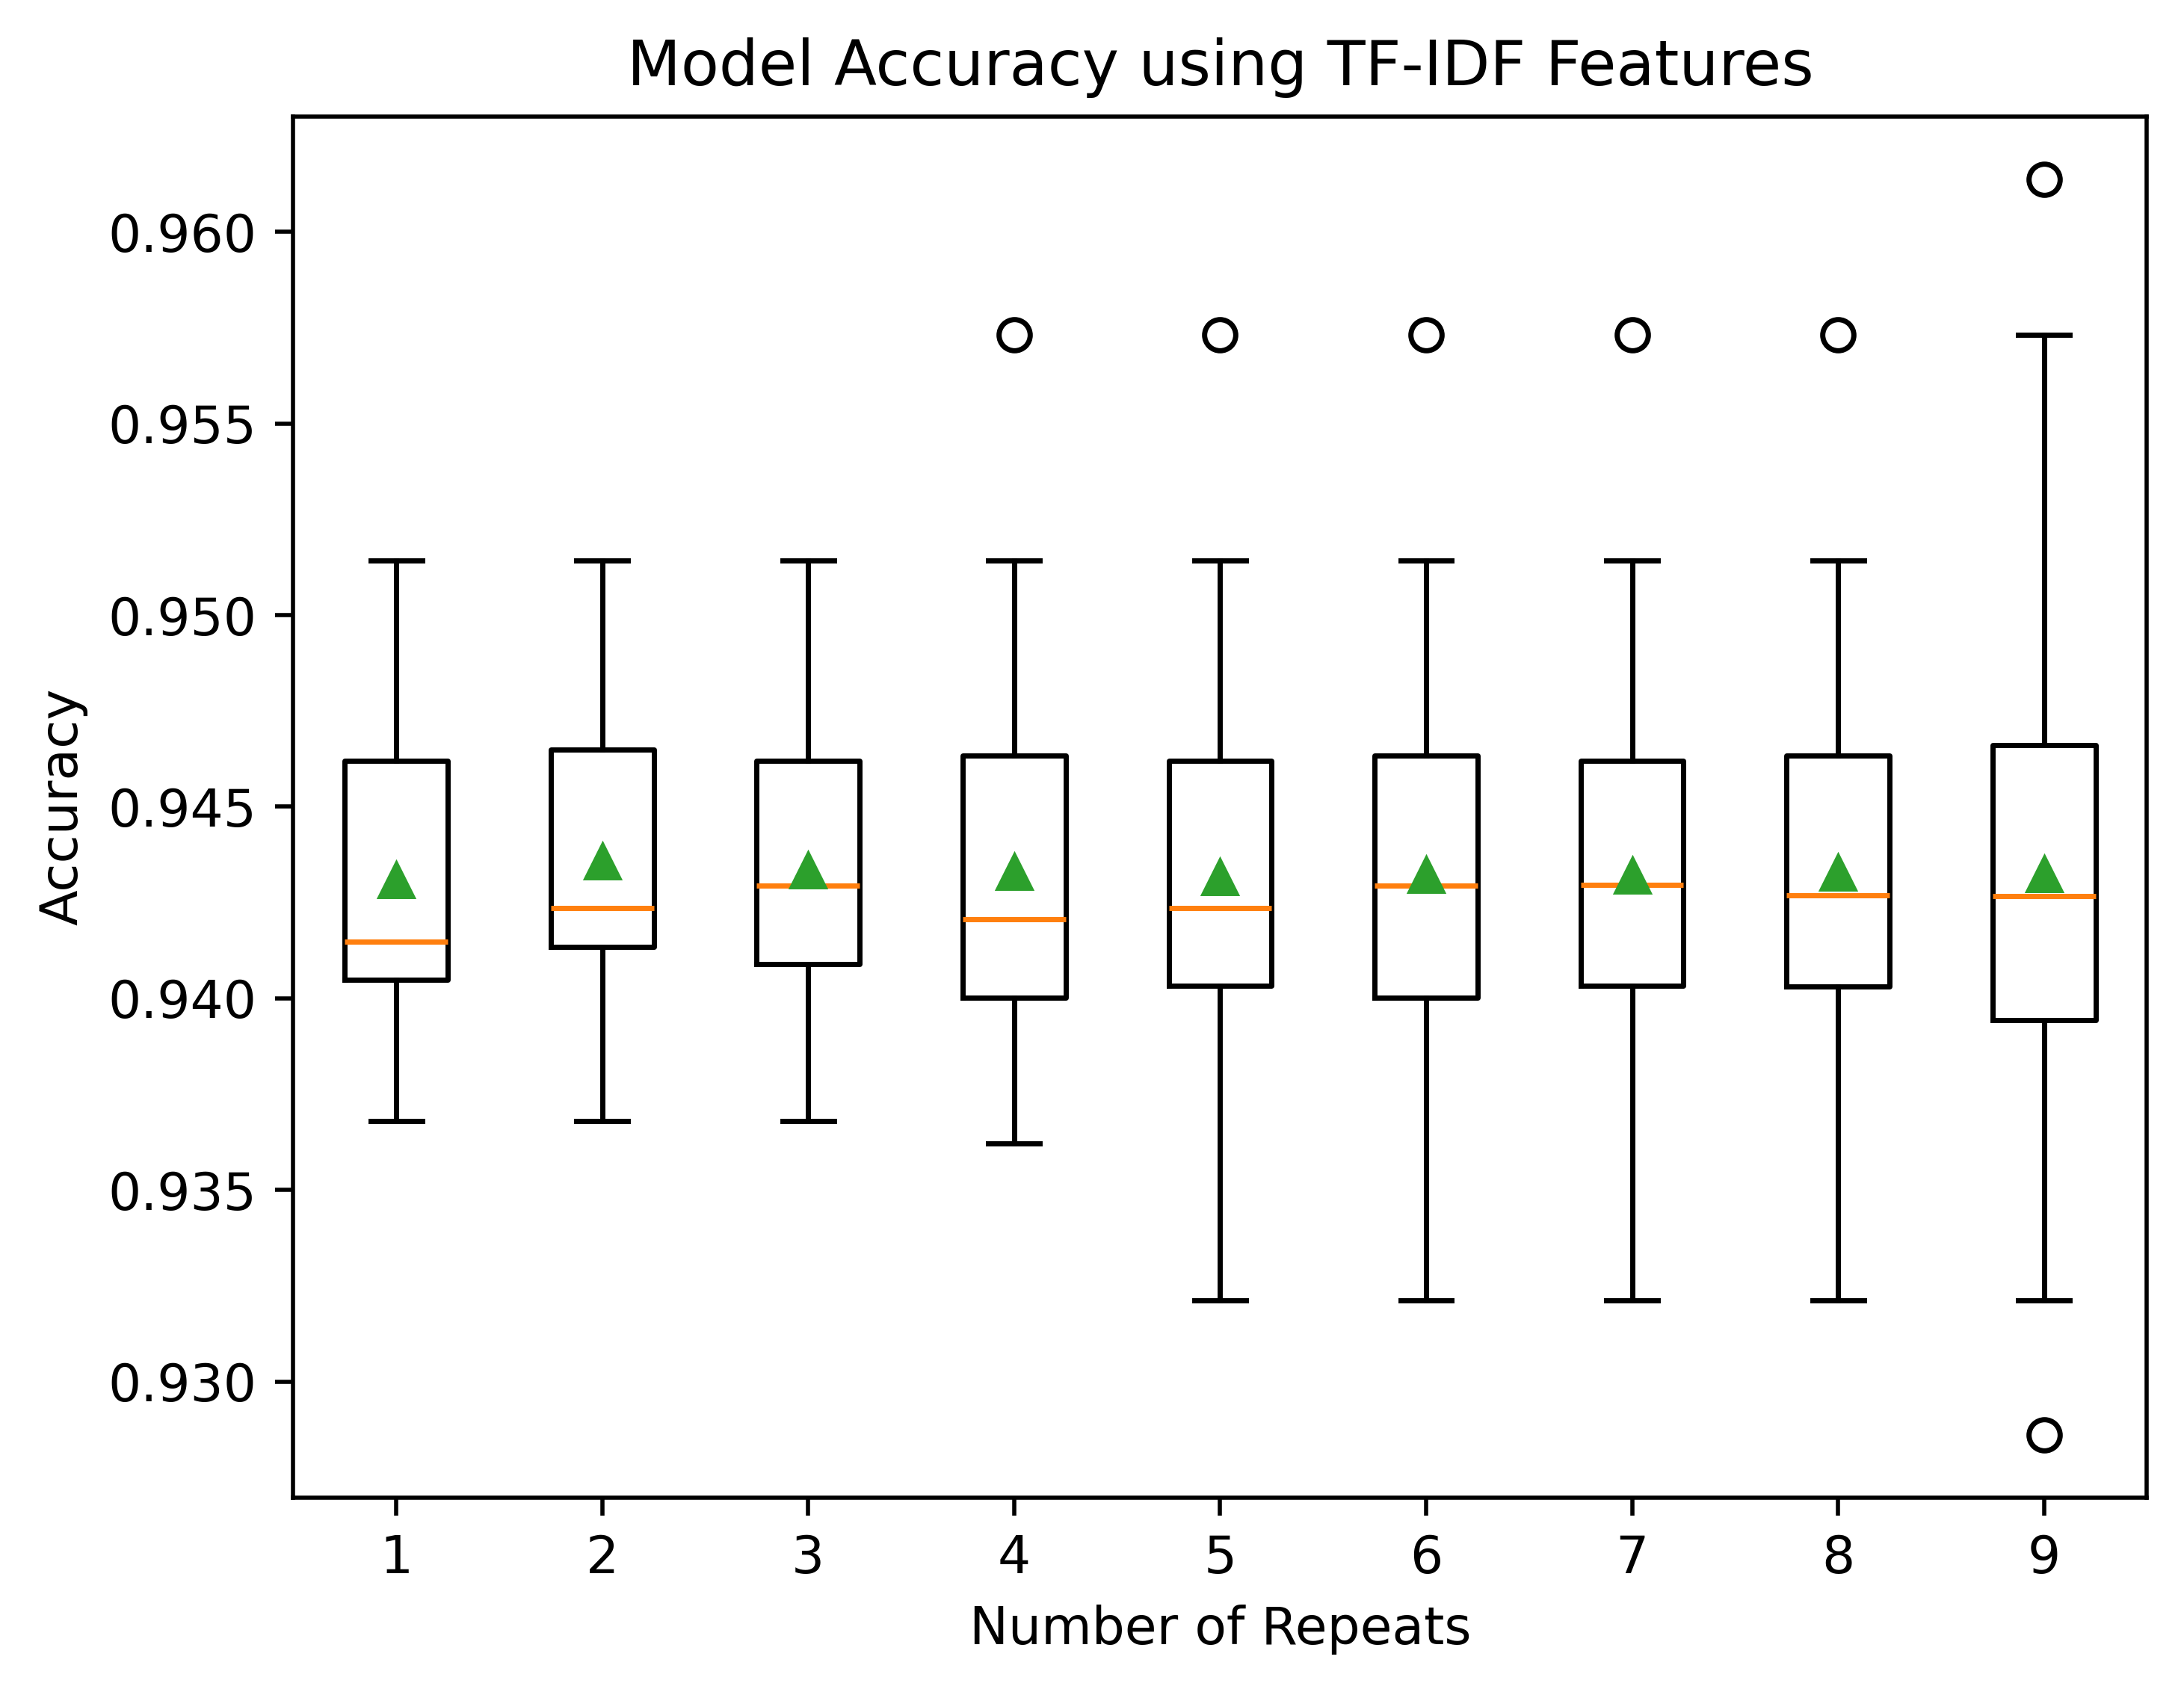

In [12]:
results = []  # List to store the results of each evaluation

# Evaluate the model using TF-IDF combined features
for r in repeats:
    # Evaluate the model using a specific number of repeats
    scores, oob_score = evaluate_model(features_train_tfidf_combined, target_train, r)
    # Summarize and print the mean accuracy, SEM, and OOB score
    print(f'Cross-Validation Repeats: {r}, Mean Accuracy: {np.mean(scores):.4f}, SEM: {sem(scores):.3f}, OOB Score: {oob_score:.4f}')
    # Store the results
    results.append(scores)

# Plot the results of the evaluations
plt.boxplot(results, labels=[str(r) for r in repeats], showmeans=True)
plt.title('Model Accuracy using TF-IDF Features')
plt.ylabel('Accuracy')
plt.xlabel('Number of Repeats')
plt.show()

# Save results
model = "rf_random_tfidf"
results = pd.DataFrame(results)
results.to_csv(f'k-fold_results/1/{model}.csv', index=False)

### BoW

Cross-Validation Repeats: 1, Mean Accuracy: 0.9449, SEM: 0.001, OOB Score: 0.9439
Cross-Validation Repeats: 2, Mean Accuracy: 0.9449, SEM: 0.001, OOB Score: 0.9439
Cross-Validation Repeats: 3, Mean Accuracy: 0.9447, SEM: 0.001, OOB Score: 0.9439
Cross-Validation Repeats: 4, Mean Accuracy: 0.9448, SEM: 0.001, OOB Score: 0.9439
Cross-Validation Repeats: 5, Mean Accuracy: 0.9450, SEM: 0.001, OOB Score: 0.9439
Cross-Validation Repeats: 6, Mean Accuracy: 0.9451, SEM: 0.001, OOB Score: 0.9439
Cross-Validation Repeats: 7, Mean Accuracy: 0.9452, SEM: 0.001, OOB Score: 0.9439
Cross-Validation Repeats: 8, Mean Accuracy: 0.9453, SEM: 0.001, OOB Score: 0.9439
Cross-Validation Repeats: 9, Mean Accuracy: 0.9453, SEM: 0.001, OOB Score: 0.9439


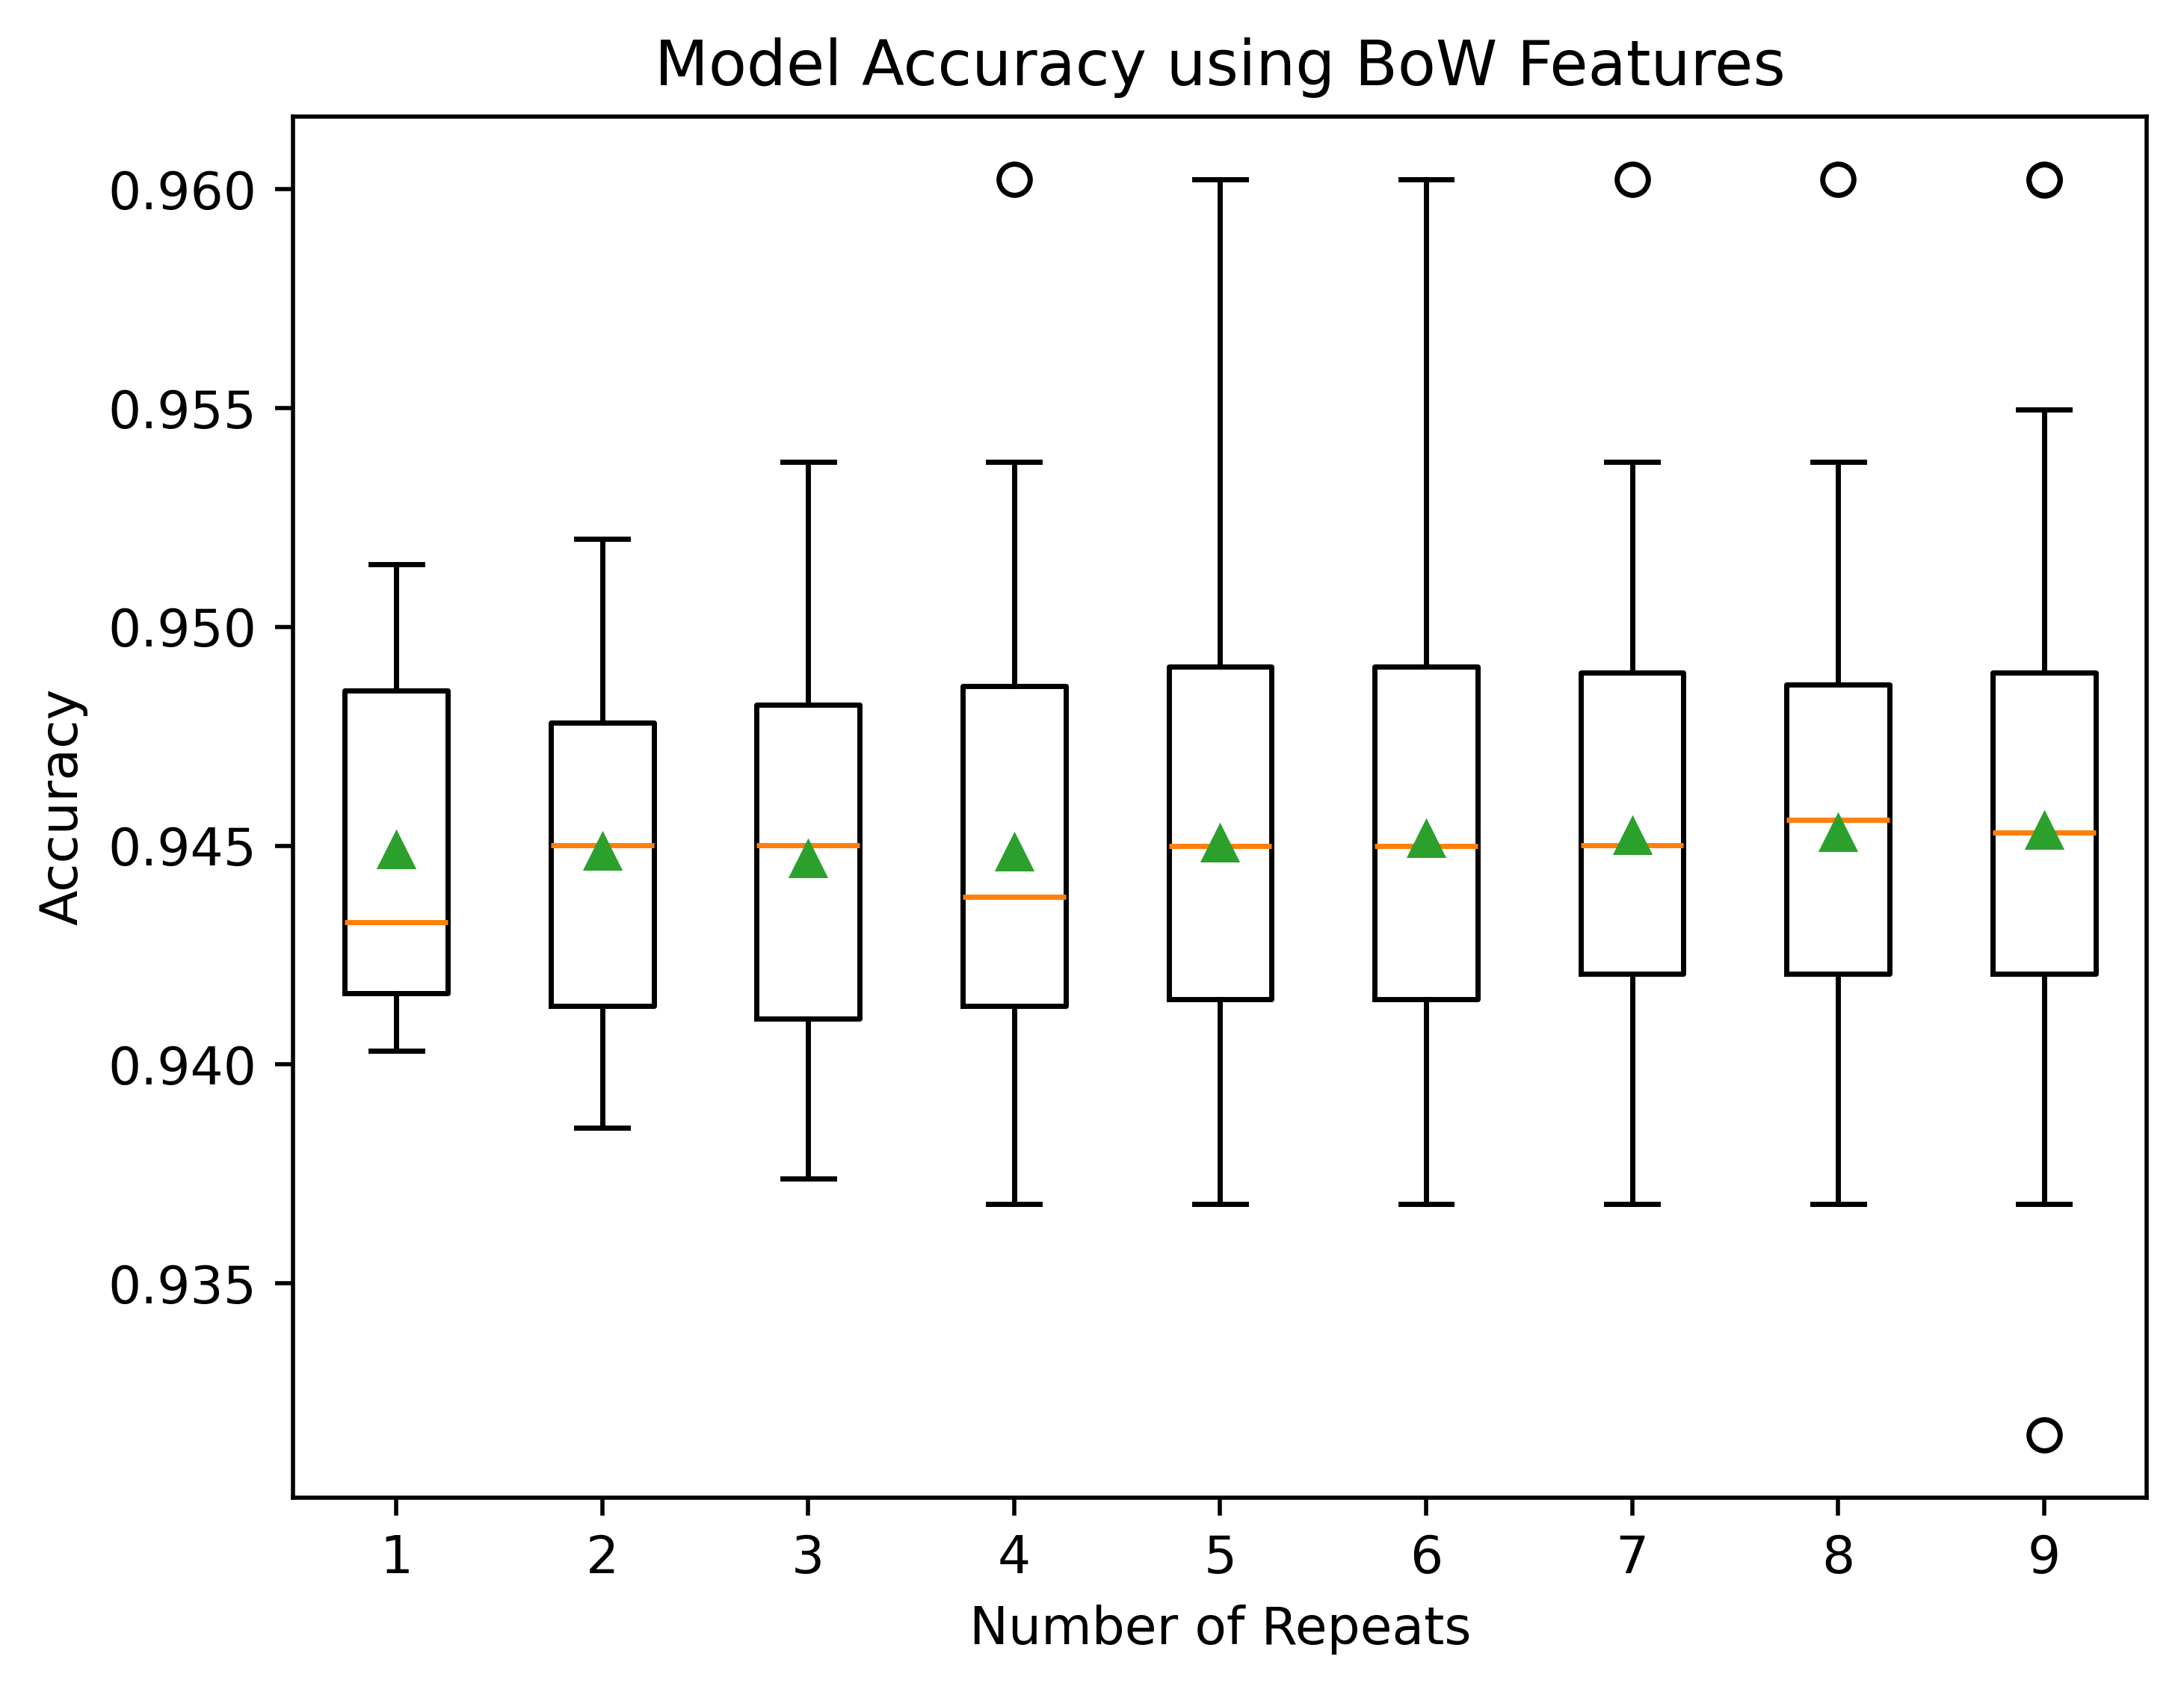

In [13]:
results = []  # List to store the results of each evaluation

# Evaluate the model using BoW combined features
for r in repeats:
    # Evaluate the model using a specific number of repeats
    scores, oob_score = evaluate_model(features_train_bow_combined, target_train, r)
    # Summarize and print the mean accuracy, SEM, and OOB score
    print(f'Cross-Validation Repeats: {r}, Mean Accuracy: {np.mean(scores):.4f}, SEM: {sem(scores):.3f}, OOB Score: {oob_score:.4f}')
    # Store the results
    results.append(scores)

# Plot the results of the evaluations
plt.boxplot(results, labels=[str(r) for r in repeats], showmeans=True)
plt.title('Model Accuracy using BoW Features')
plt.ylabel('Accuracy')
plt.xlabel('Number of Repeats')
plt.show()

# Save results
model = "rf_random_bow"
results = pd.DataFrame(results)
results.to_csv(f'k-fold_results/1/{model}.csv', index=False)

## Gradient Boosting Classifier

### TF-IDF

In [14]:
def evaluate_model(features, target, num_repeats):
    # Initialize the Gradient Boosting classifier
    model = GradientBoostingClassifier(n_estimators=50, learning_rate=0.25, max_depth=10)
    # Prepare the cross-validation procedure
    cv = RepeatedKFold(n_splits=10, n_repeats=num_repeats, random_state=1)
    # Evaluate the model
    scores = cross_val_score(model, features, target, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

# Evaluation parameters
repeats = range(1, 10)  # Number of repeats for cross-validation

Cross-Validation Repeats: 1, Mean Accuracy: 0.9410, SEM: 0.001
Cross-Validation Repeats: 2, Mean Accuracy: 0.9393, SEM: 0.001
Cross-Validation Repeats: 3, Mean Accuracy: 0.9393, SEM: 0.001
Cross-Validation Repeats: 4, Mean Accuracy: 0.9395, SEM: 0.001
Cross-Validation Repeats: 5, Mean Accuracy: 0.9393, SEM: 0.001
Cross-Validation Repeats: 6, Mean Accuracy: 0.9399, SEM: 0.001
Cross-Validation Repeats: 7, Mean Accuracy: 0.9395, SEM: 0.001
Cross-Validation Repeats: 8, Mean Accuracy: 0.9392, SEM: 0.001
Cross-Validation Repeats: 9, Mean Accuracy: 0.9393, SEM: 0.001


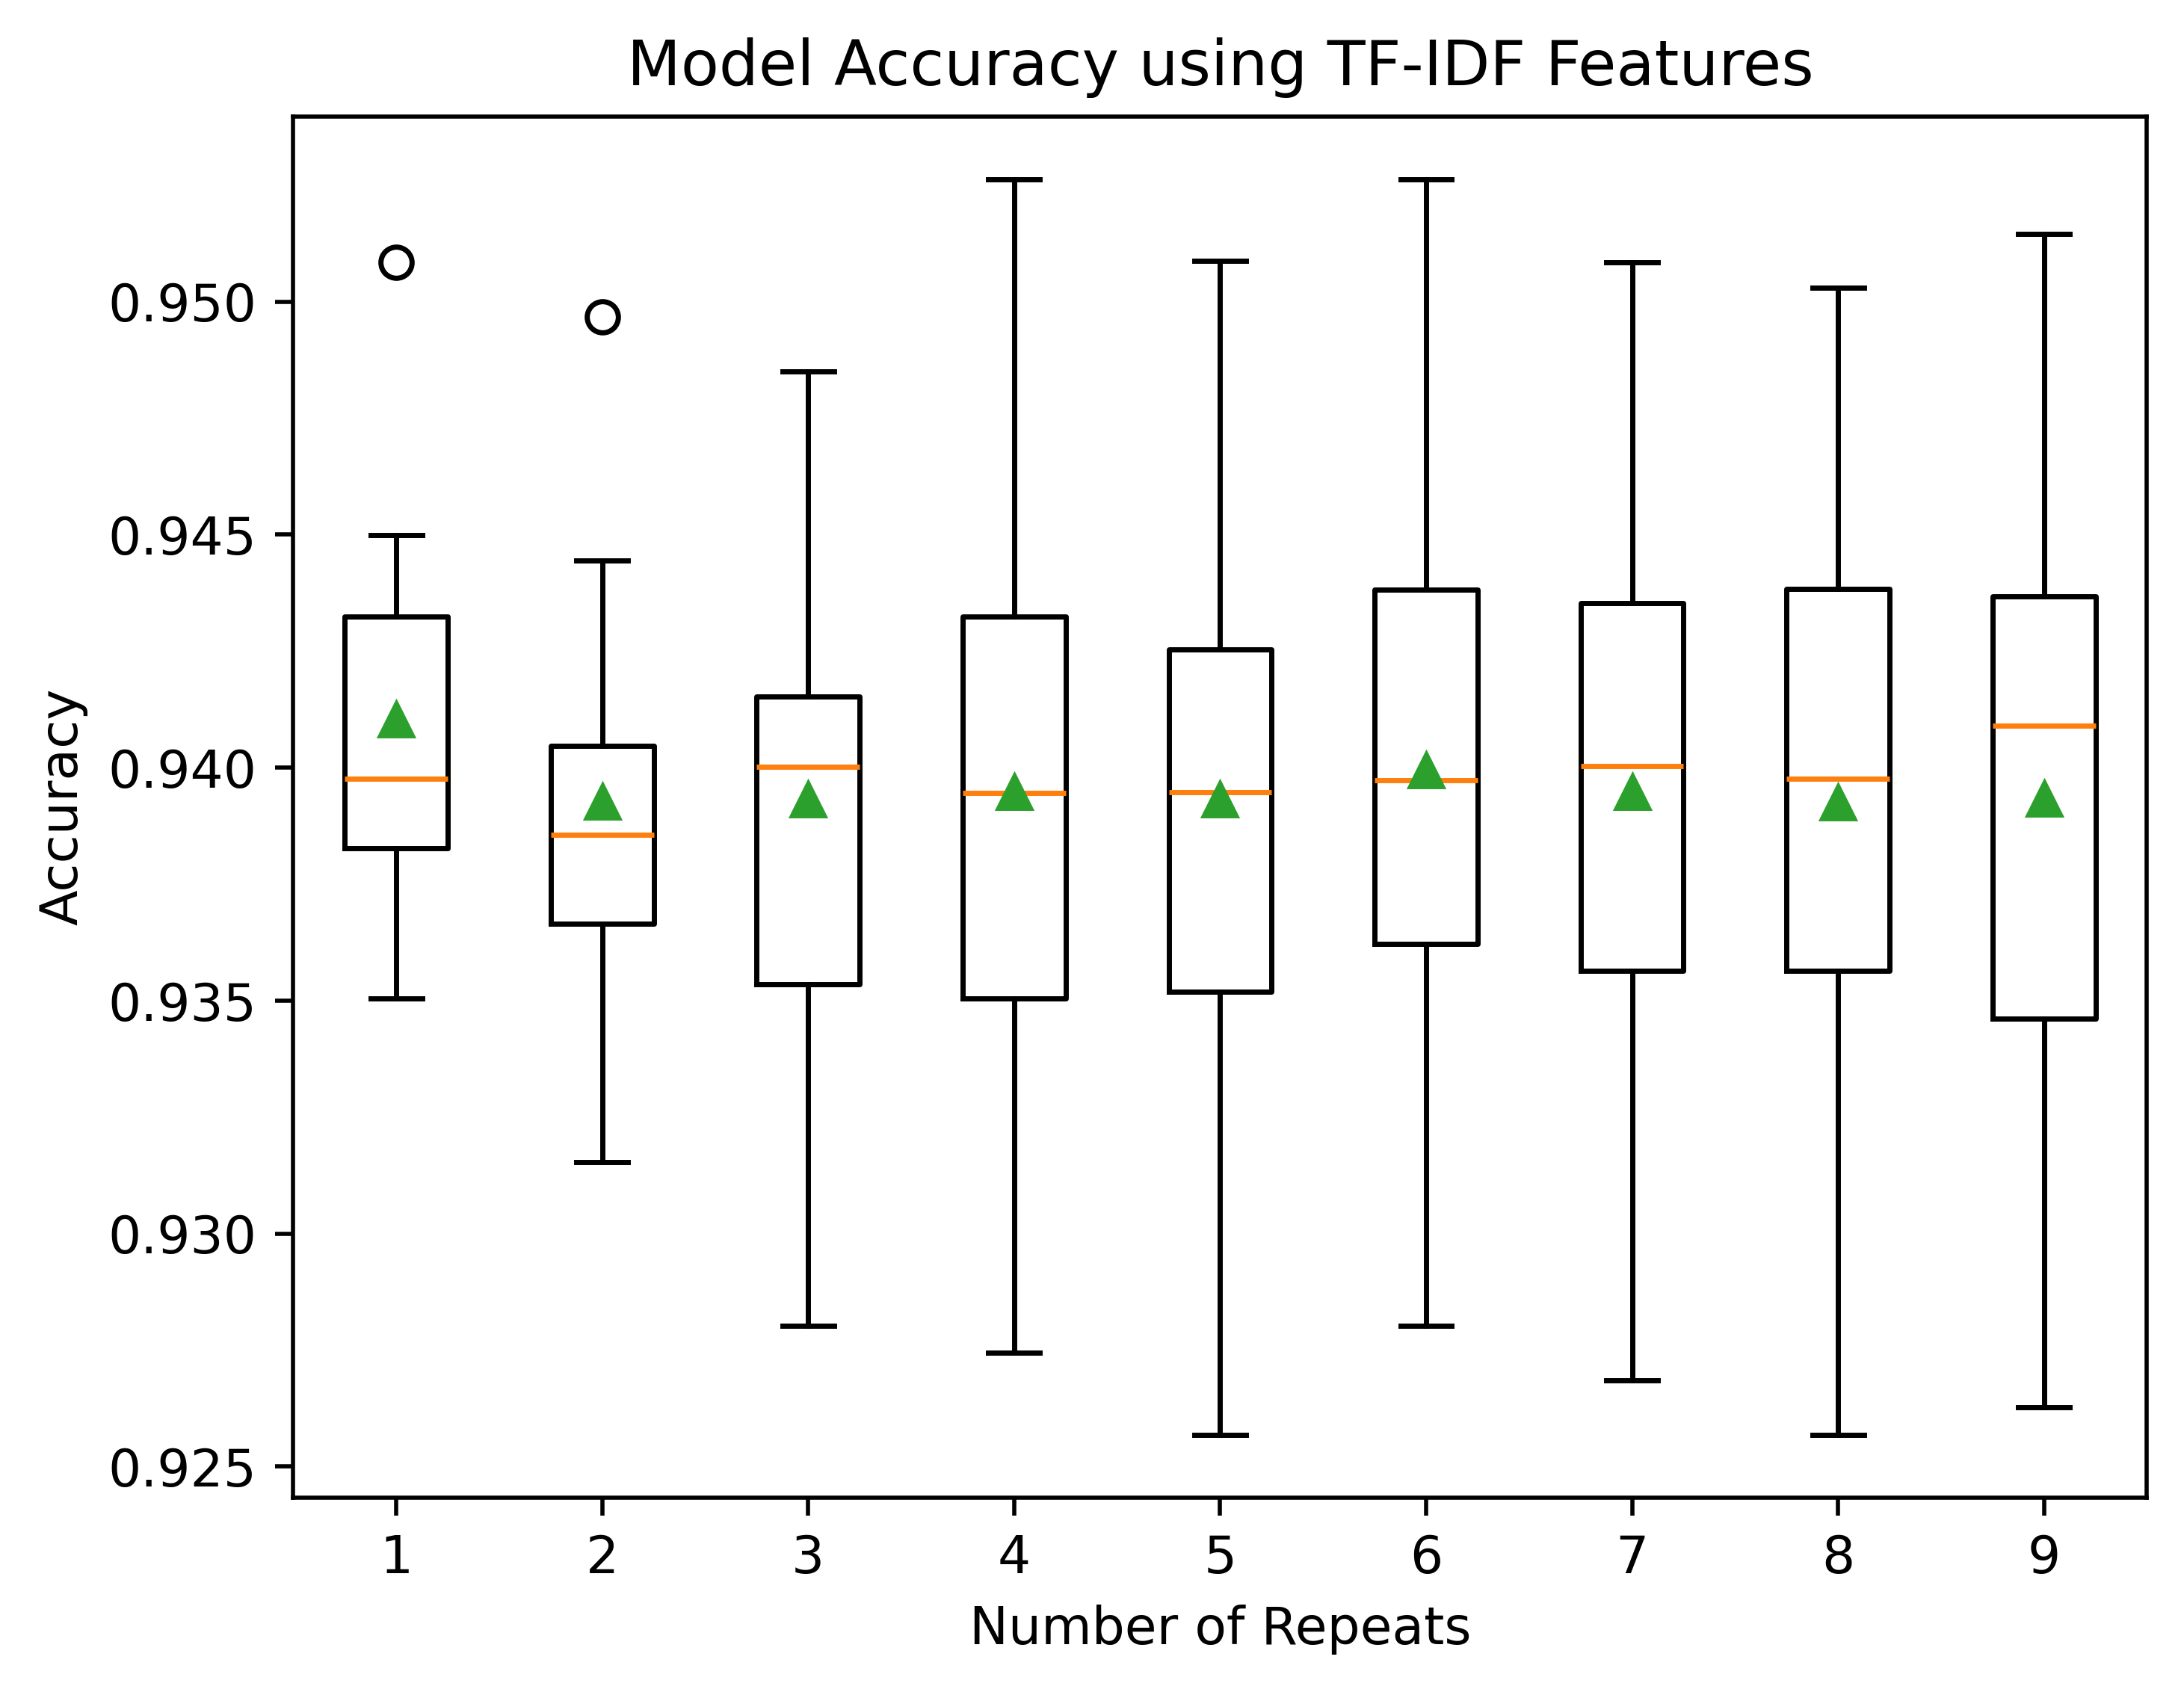

In [15]:
results = []  # List to store the results of each evaluation
mean_scores = []  # Store mean scores to summarize

# Evaluate the model using TF-IDF combined features
for r in repeats:
    # Evaluate the model using a specific number of repeats
    scores = evaluate_model(features_train_tfidf_combined, target_train, r)
    # Summarize and print the mean accuracy and SEM
    mean_accuracy = np.mean(scores)
    accuracy_sem = sem(scores)
    print(f'Cross-Validation Repeats: {r}, Mean Accuracy: {mean_accuracy:.4f}, SEM: {accuracy_sem:.3f}')
    # Store the results
    results.append(scores)
    mean_scores.append(mean_accuracy)

# Plot the results of the evaluations
plt.boxplot(results, labels=[str(r) for r in repeats], showmeans=True)
plt.title('Model Accuracy using TF-IDF Features')
plt.ylabel('Accuracy')
plt.xlabel('Number of Repeats')
plt.show()

# Save results
model = "rf_gradient_tfidf"
results = pd.DataFrame(results)
results.to_csv(f'k-fold_results/1/{model}.csv', index=False)

### BoW

Cross-Validation Repeats: 1, Mean Accuracy: 0.9471, SEM: 0.002
Cross-Validation Repeats: 2, Mean Accuracy: 0.9454, SEM: 0.001
Cross-Validation Repeats: 3, Mean Accuracy: 0.9452, SEM: 0.001
Cross-Validation Repeats: 4, Mean Accuracy: 0.9451, SEM: 0.001
Cross-Validation Repeats: 5, Mean Accuracy: 0.9451, SEM: 0.001
Cross-Validation Repeats: 6, Mean Accuracy: 0.9455, SEM: 0.001
Cross-Validation Repeats: 7, Mean Accuracy: 0.9451, SEM: 0.001
Cross-Validation Repeats: 8, Mean Accuracy: 0.9451, SEM: 0.001
Cross-Validation Repeats: 9, Mean Accuracy: 0.9451, SEM: 0.001


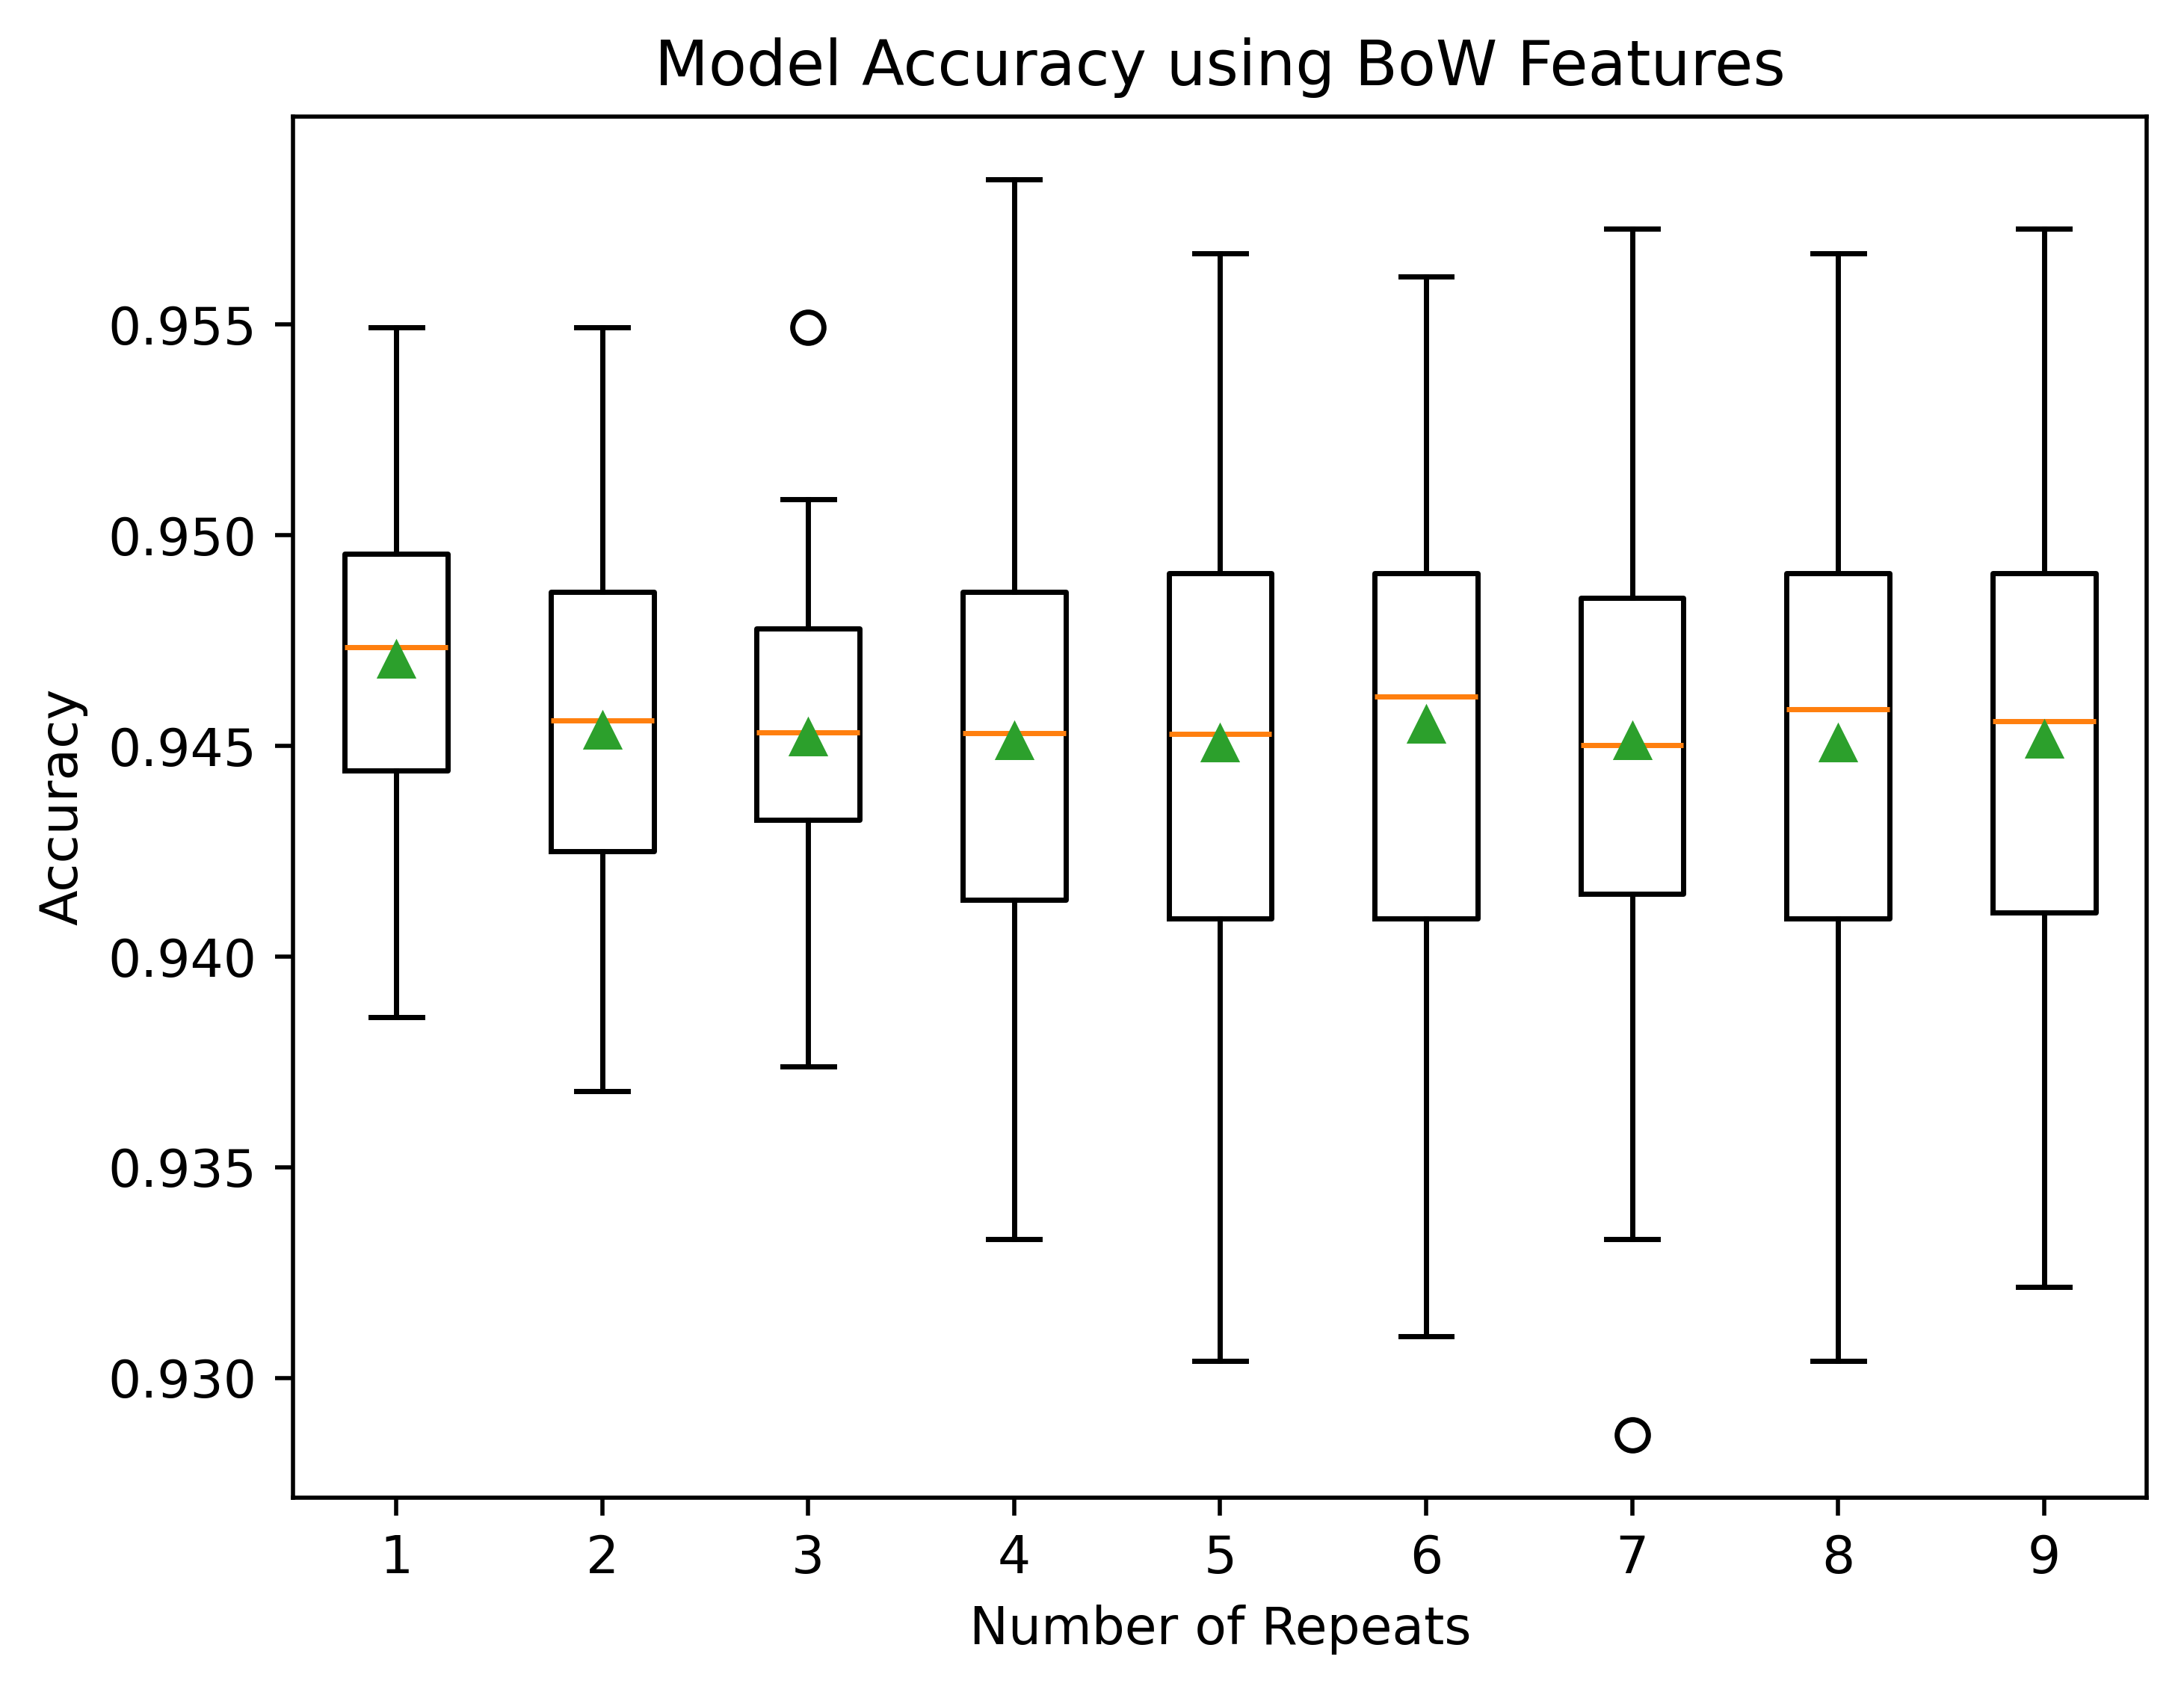

In [16]:
results = []  # List to store the results of each evaluation
mean_scores = []  # Store mean scores to summarize

# Evaluate the model using BoW combined features
for r in repeats:
    # Evaluate the model using a specific number of repeats
    scores = evaluate_model(features_train_bow_combined, target_train, r)
    # Summarize and print the mean accuracy and SEM
    mean_accuracy = np.mean(scores)
    accuracy_sem = sem(scores)
    print(f'Cross-Validation Repeats: {r}, Mean Accuracy: {mean_accuracy:.4f}, SEM: {accuracy_sem:.3f}')
    # Store the results
    results.append(scores)
    mean_scores.append(mean_accuracy)

# Plot the results of the evaluations
plt.boxplot(results, labels=[str(r) for r in repeats], showmeans=True)
plt.title('Model Accuracy using BoW Features')
plt.ylabel('Accuracy')
plt.xlabel('Number of Repeats')
plt.show()

# Save results
model = "rf_gradient_bow"
results = pd.DataFrame(results)
results.to_csv(f'k-fold_results/1/{model}.csv', index=False)

## Voting Classifier

### TF-IDF

In [17]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import RepeatedKFold, cross_val_score
import numpy as np
from scipy.stats import sem
import matplotlib.pyplot as plt

def evaluate_model(features, target, num_repeats):
    # Initialize the Voting Classifier with different Random Forest models
    rf_classifier1 = RandomForestClassifier(n_estimators=100)
    rf_classifier2 = RandomForestClassifier(n_estimators=70)
    rf_classifier3 = RandomForestClassifier(n_estimators=80)
    
    model = VotingClassifier(estimators=[
        ('rf1', rf_classifier1),
        ('rf2', rf_classifier2),
        ('rf3', rf_classifier3)
    ])
    
    # Prepare the cross-validation procedure
    cv = RepeatedKFold(n_splits=10, n_repeats=num_repeats, random_state=1)
    
    # Evaluate the model
    scores = cross_val_score(model, features, target, scoring='accuracy', cv=cv, n_jobs=-1)
    
    # Fit the model (optional if you want to use it after training)
    model.fit(features, target)
    
    return scores

# Evaluation parameters
repeats = range(1, 10)  # Number of repeats for cross-validation

Cross-Validation Repeats: 1, Mean Accuracy: 0.9436, SEM: 0.001
Cross-Validation Repeats: 2, Mean Accuracy: 0.9436, SEM: 0.001
Cross-Validation Repeats: 3, Mean Accuracy: 0.9435, SEM: 0.001
Cross-Validation Repeats: 4, Mean Accuracy: 0.9436, SEM: 0.001
Cross-Validation Repeats: 5, Mean Accuracy: 0.9437, SEM: 0.001
Cross-Validation Repeats: 6, Mean Accuracy: 0.9438, SEM: 0.001
Cross-Validation Repeats: 7, Mean Accuracy: 0.9433, SEM: 0.001
Cross-Validation Repeats: 8, Mean Accuracy: 0.9436, SEM: 0.001
Cross-Validation Repeats: 9, Mean Accuracy: 0.9435, SEM: 0.001


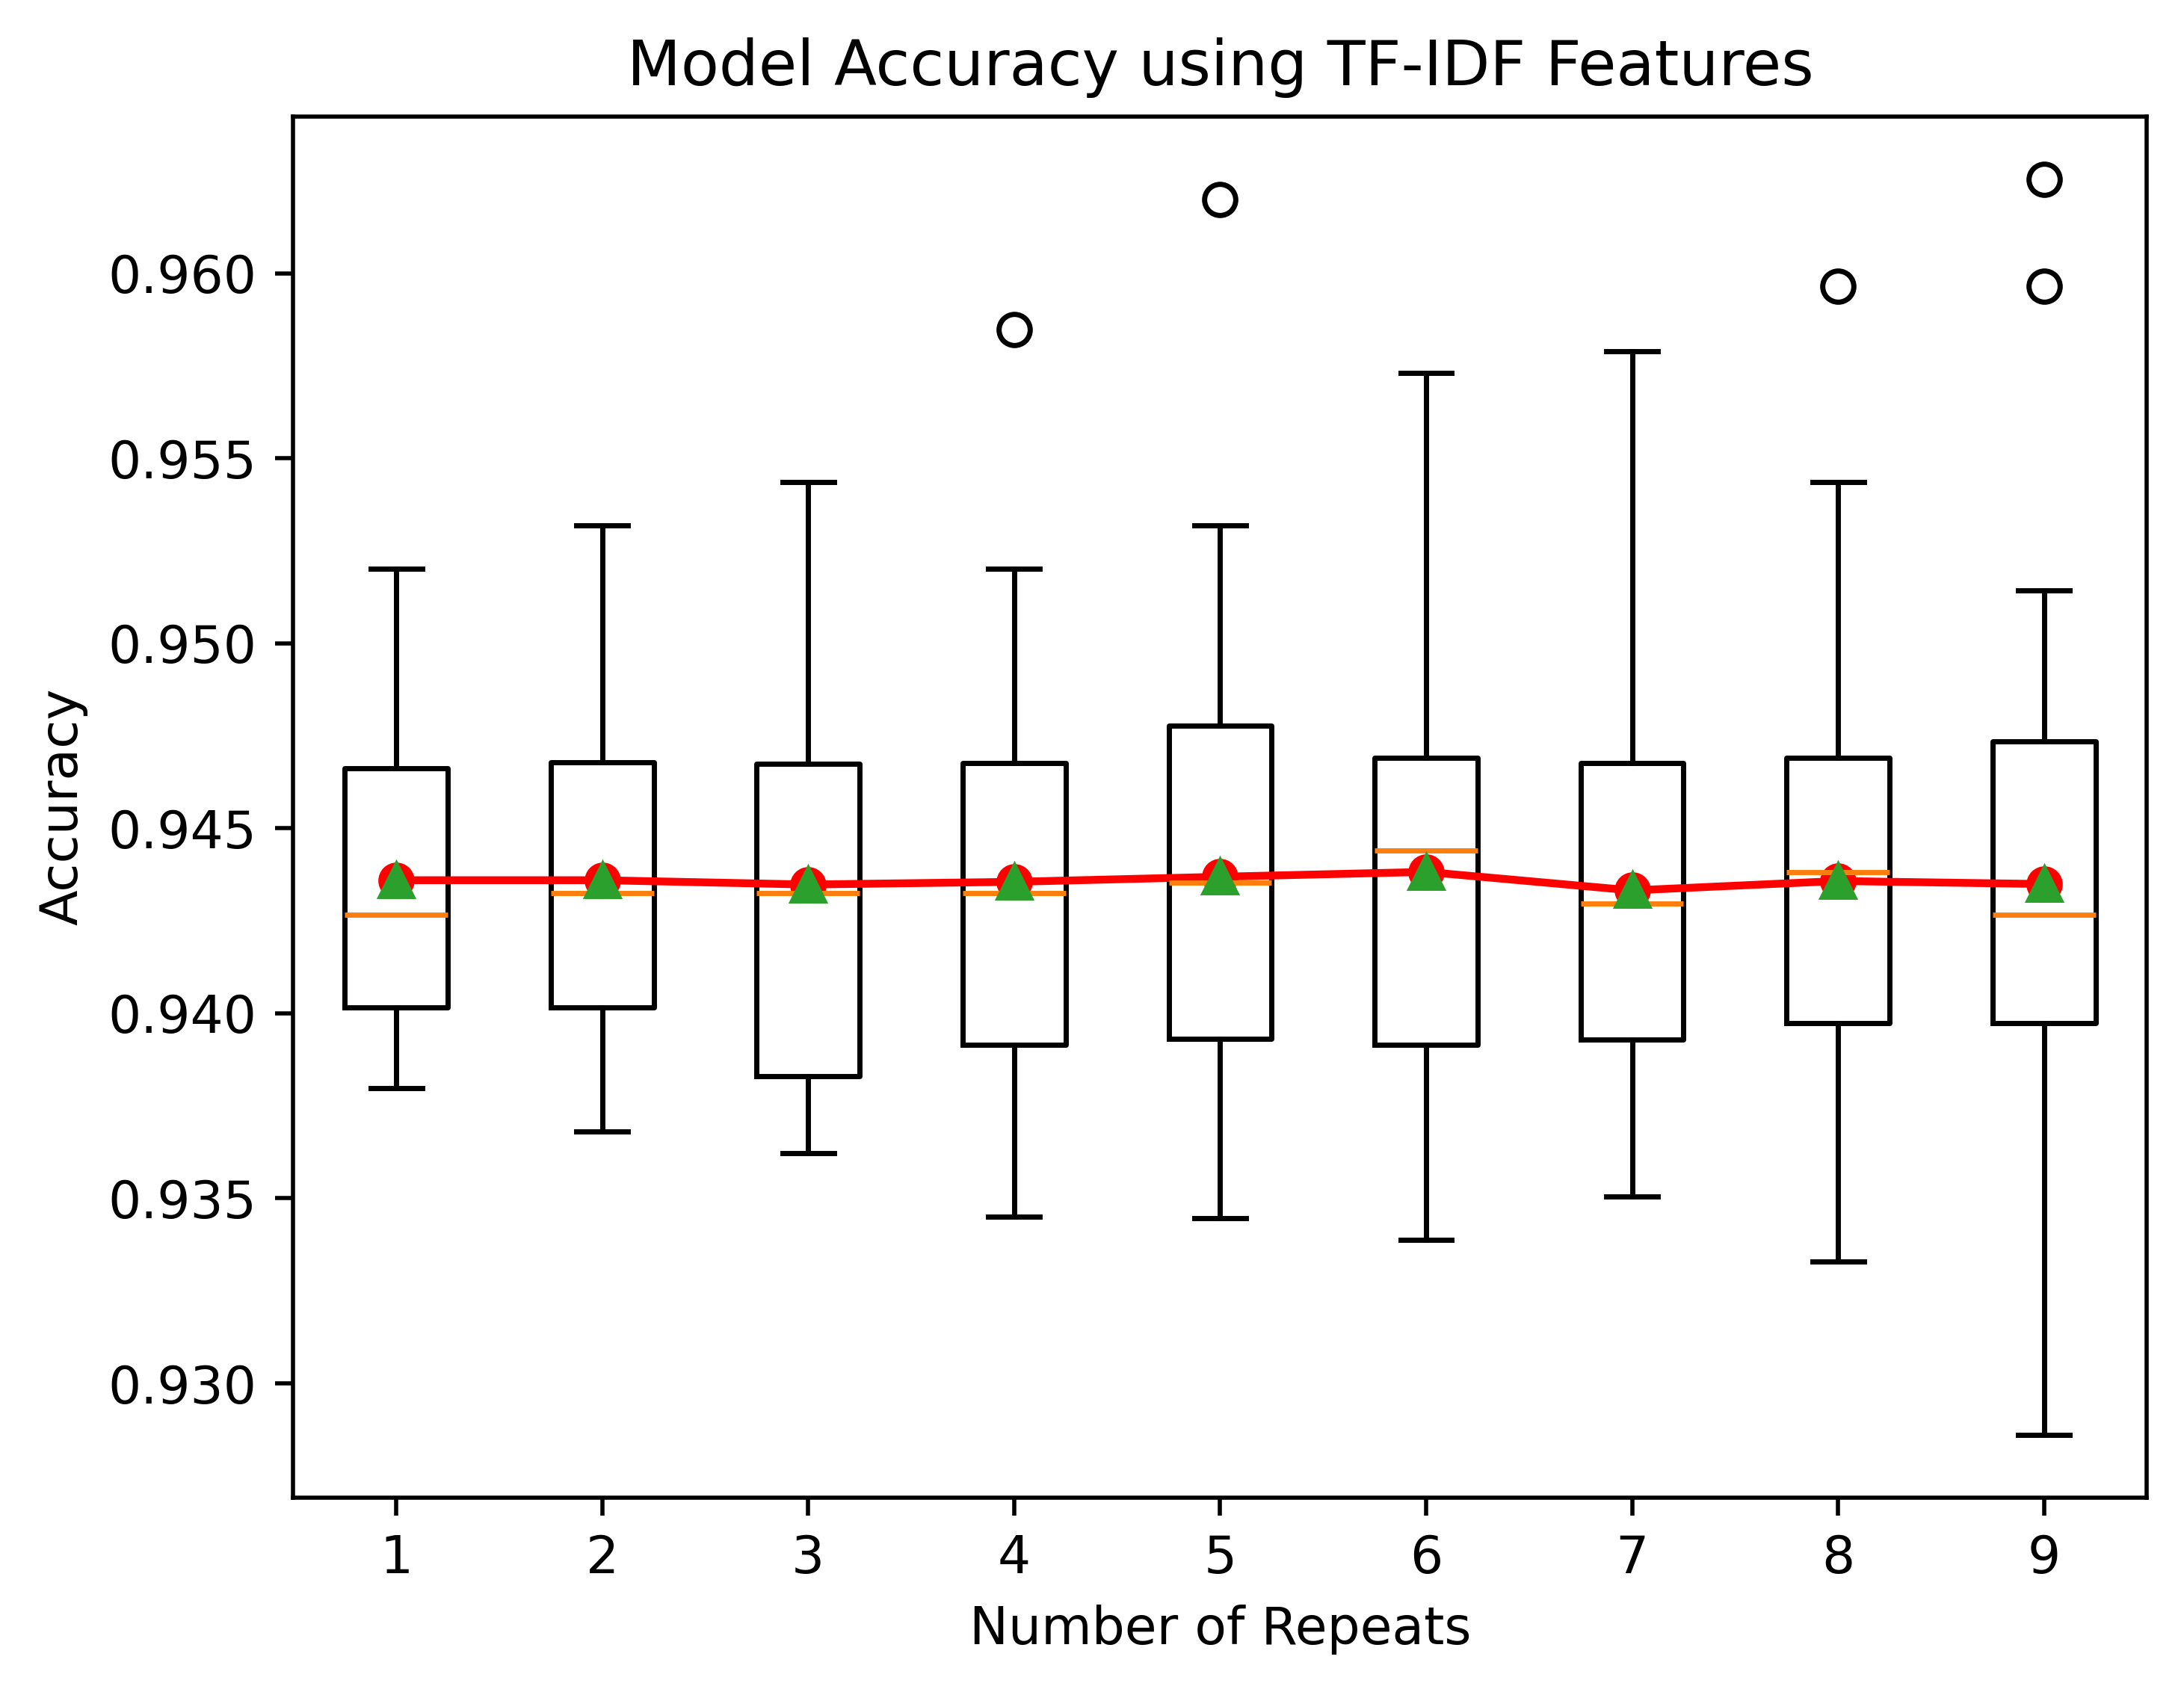

In [18]:
results = []  # List to store the results of each evaluation
mean_scores = []  # List to store mean accuracy for plotting

# Assume 'features_train_tfidf_combined' and 'target_train' are defined elsewhere
features = features_train_tfidf_combined
target = target_train

# Evaluate the model using TF-IDF combined features
for r in repeats:
    # Evaluate the model using a specific number of repeats
    scores = evaluate_model(features, target, r)
    # Summarize and print the mean accuracy and SEM
    mean_accuracy = np.mean(scores)
    accuracy_sem = sem(scores)
    print(f'Cross-Validation Repeats: {r}, Mean Accuracy: {mean_accuracy:.4f}, SEM: {accuracy_sem:.3f}')
    # Store the results
    results.append(scores)
    mean_scores.append(mean_accuracy)

# Plot the results of the evaluations
plt.boxplot(results, labels=[str(r) for r in repeats], showmeans=True)
plt.plot(range(1, 10), mean_scores, 'o-', color='red')  # Mean accuracy trend line
plt.title('Model Accuracy using TF-IDF Features')
plt.ylabel('Accuracy')
plt.xlabel('Number of Repeats')
plt.show()

# Save results
model = "rf_voting_tfidf"
results = pd.DataFrame(results)
results.to_csv(f'k-fold_results/1/{model}.csv', index=False)

### BoW

Cross-Validation Repeats: 1, Mean Accuracy: 0.9451, SEM: 0.002
Cross-Validation Repeats: 2, Mean Accuracy: 0.9447, SEM: 0.001
Cross-Validation Repeats: 3, Mean Accuracy: 0.9445, SEM: 0.001
Cross-Validation Repeats: 4, Mean Accuracy: 0.9455, SEM: 0.001
Cross-Validation Repeats: 5, Mean Accuracy: 0.9452, SEM: 0.001
Cross-Validation Repeats: 6, Mean Accuracy: 0.9453, SEM: 0.001
Cross-Validation Repeats: 7, Mean Accuracy: 0.9451, SEM: 0.001
Cross-Validation Repeats: 8, Mean Accuracy: 0.9453, SEM: 0.001
Cross-Validation Repeats: 9, Mean Accuracy: 0.9449, SEM: 0.001


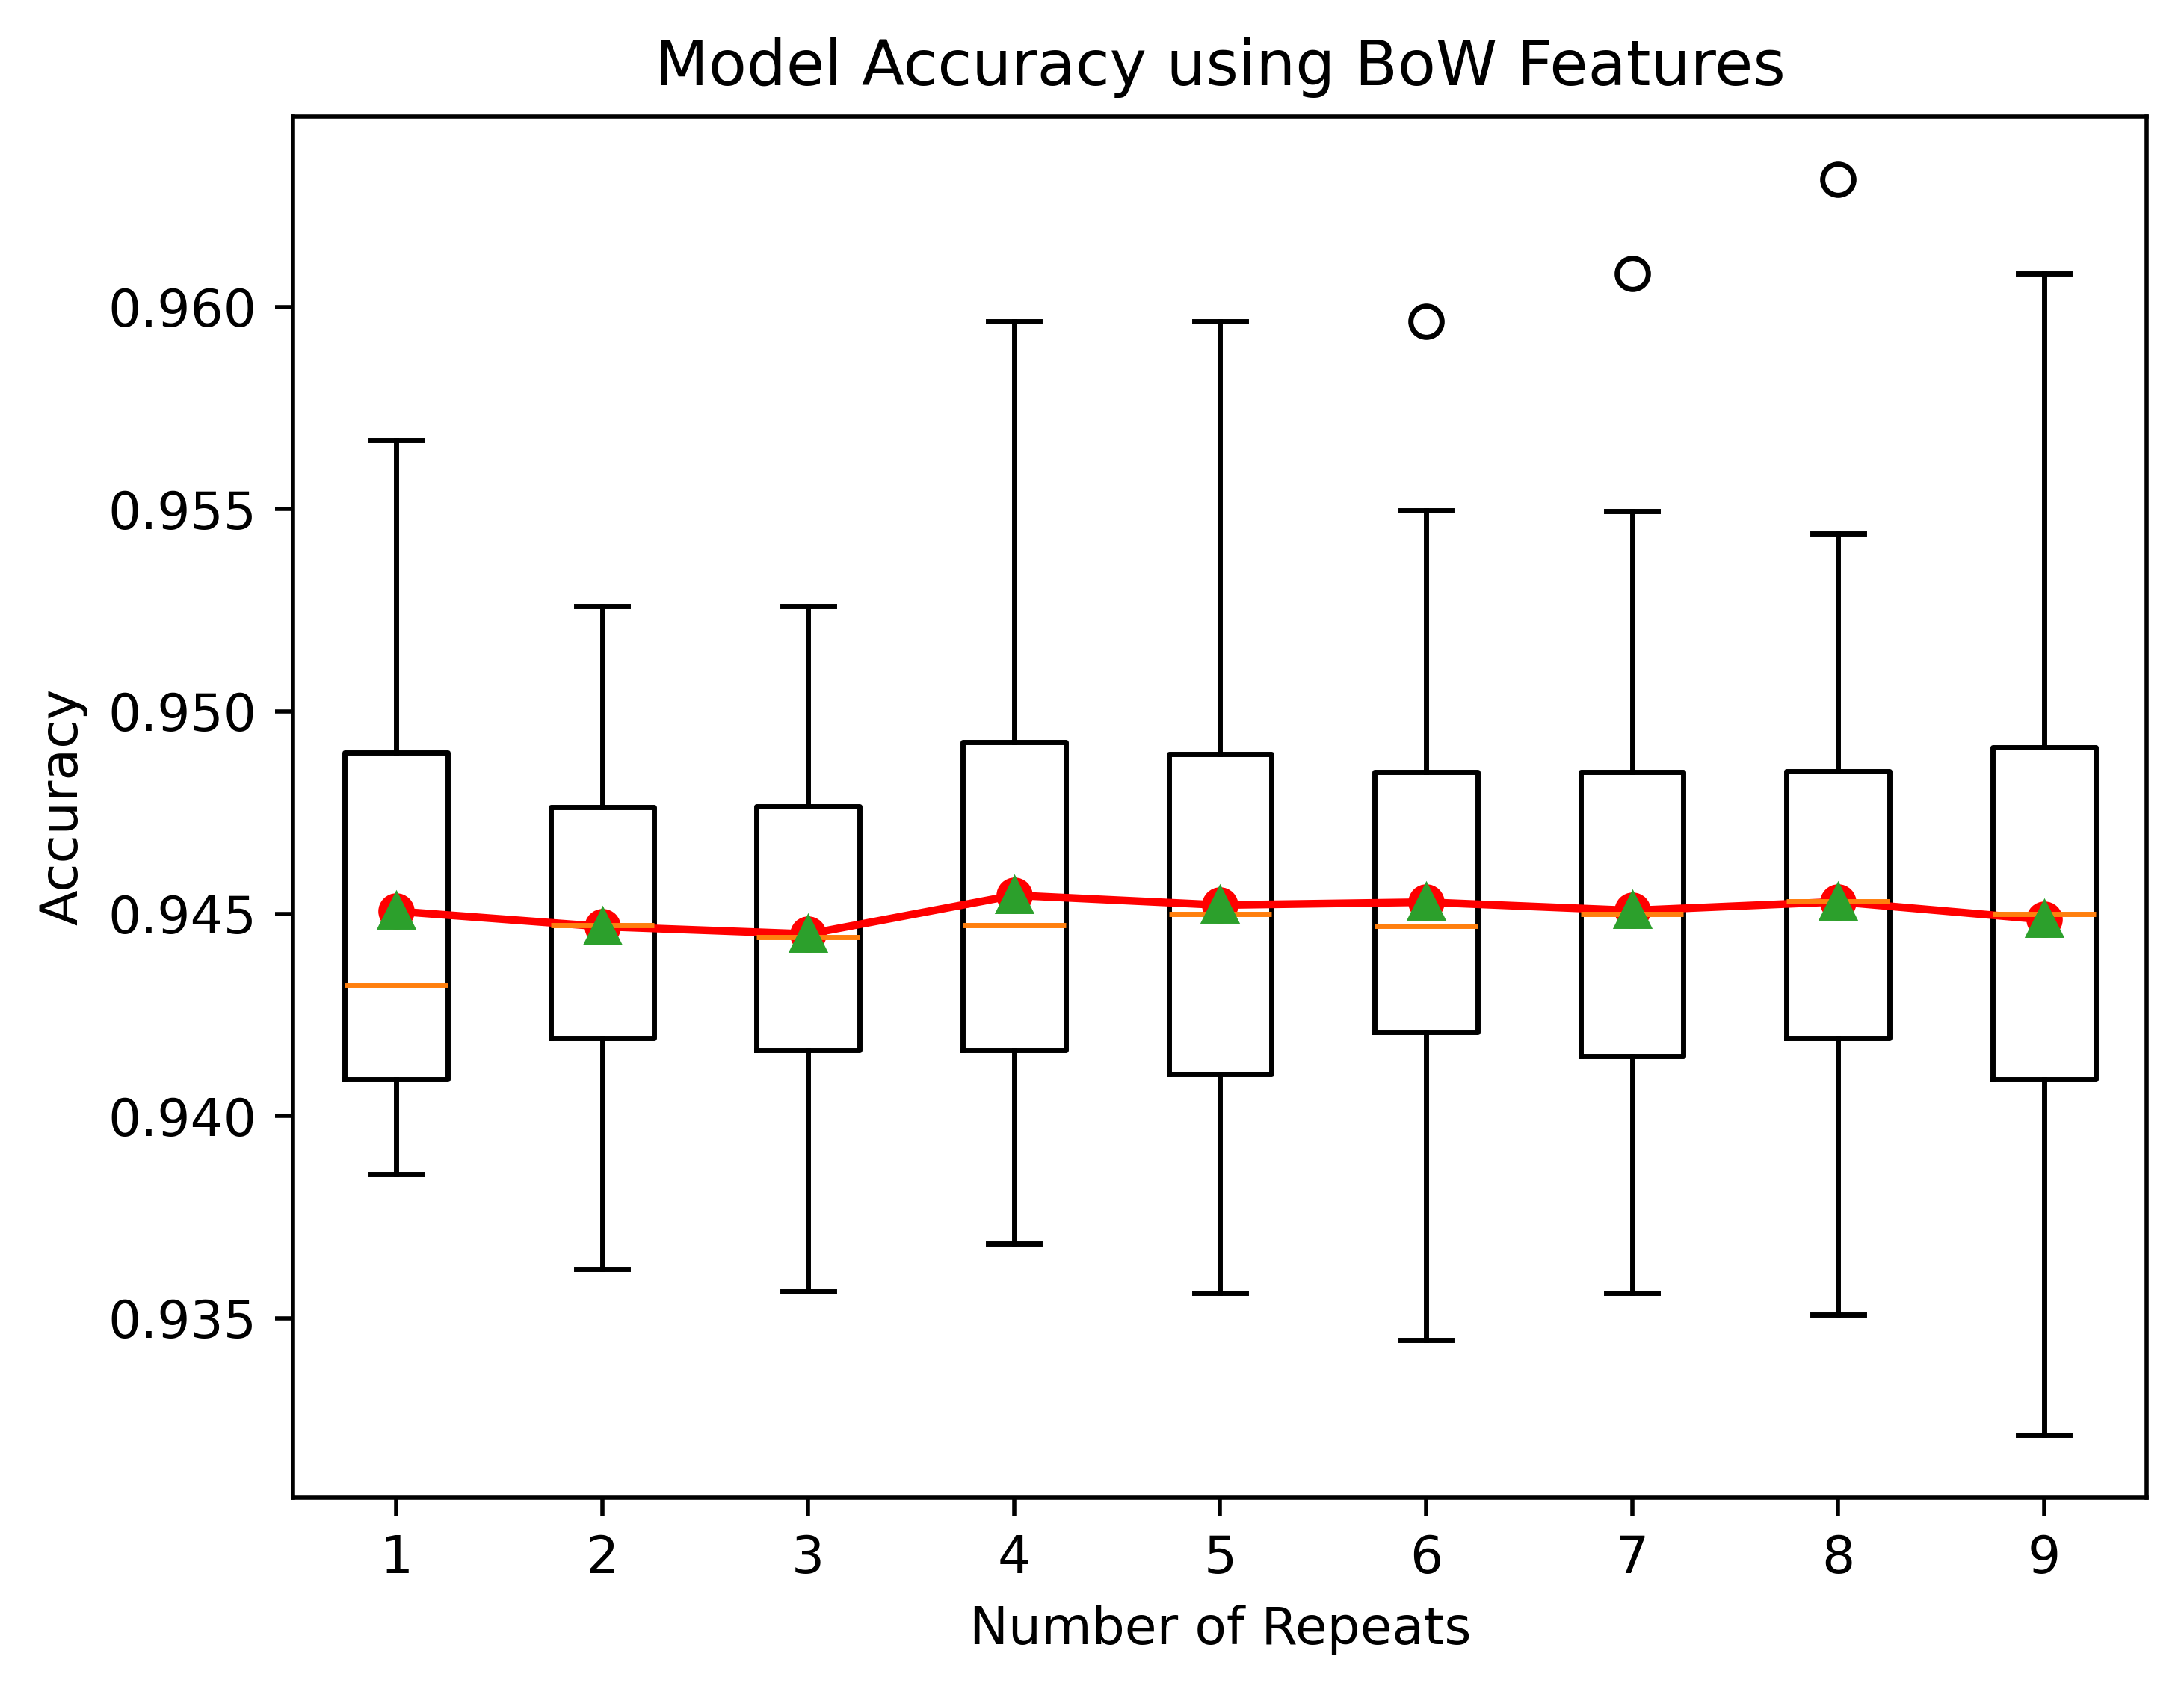

In [19]:
results = []  # List to store the results of each evaluation
mean_scores = []  # List to store mean accuracy for plotting

# Assume 'features_train_tfidf_combined' and 'target_train' are defined elsewhere
features = features_train_bow_combined
target = target_train

# Evaluate the model using BoW combined features
for r in repeats:
    # Evaluate the model using a specific number of repeats
    scores = evaluate_model(features, target, r)
    # Summarize and print the mean accuracy and SEM
    mean_accuracy = np.mean(scores)
    accuracy_sem = sem(scores)
    print(f'Cross-Validation Repeats: {r}, Mean Accuracy: {mean_accuracy:.4f}, SEM: {accuracy_sem:.3f}')
    # Store the results
    results.append(scores)
    mean_scores.append(mean_accuracy)

# Plot the results of the evaluations
plt.boxplot(results, labels=[str(r) for r in repeats], showmeans=True)
plt.plot(range(1, 10), mean_scores, 'o-', color='red')  # Mean accuracy trend line
plt.title('Model Accuracy using BoW Features')
plt.ylabel('Accuracy')
plt.xlabel('Number of Repeats')
plt.show()

# Save results
model = "rf_voting_bow"
results = pd.DataFrame(results)
results.to_csv(f'k-fold_results/1/{model}.csv', index=False)

In [25]:
# stop executing
import sys
sys.exit()

SystemExit: 

/Users/josh/Desktop/Coding 👨🏽‍💻/sentiment_analysis/venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3558: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# Hyperparameter Tuning

In [20]:
# Define the parameter grid for GridSearchCV
grid_search_params = {
    'n_estimators': [50, 70, 100],  # List of numbers of trees in the forest
    'max_depth': [20, 50, 100, 120],  # Maximum depth of each tree
    'min_samples_split': [2, 5],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [2, 4, 6]  # Minimum number of samples required to be at a leaf node
}

## Grid Search

In [21]:
# Initialize a RandomForestClassifier for grid search
forest_classifier_grid = RandomForestClassifier(random_state=43)

# Create the GridSearchCV object with predefined parameters and 10-fold cross-validation
grid_search = GridSearchCV(
    estimator=forest_classifier_grid,
    param_grid=grid_search_params,
    cv=10,
    n_jobs=-1,
    verbose=True,
    scoring='accuracy'
)

# Fit the GridSearchCV object to the data
grid_search.fit(features_train_bow_combined, target_train)

Fitting 10 folds for each of 72 candidates, totalling 720 fits


GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=43),
             n_jobs=-1,
             param_grid={'max_depth': [20, 50, 100, 120],
                         'min_samples_leaf': [2, 4, 6],
                         'min_samples_split': [2, 5],
                         'n_estimators': [50, 70, 100]},
             scoring='accuracy', verbose=True)

Best Parameters: {'max_depth': 120, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 70}

Accuracy: 0.9351743505733676



OOB Score: 0.9452375380294875

Classification Report: 
               precision    recall  f1-score   support

          -1       0.94      0.75      0.83       389
           0       0.93      0.98      0.95      2584
           1       0.95      0.90      0.93      1300

    accuracy                           0.94      4273
   macro avg       0.94      0.88      0.90      4273
weighted avg       0.94      0.94      0.93      4273

Confusion Matrix:
      -1     0     1
-1  290    84    15
0    10  2531    43
1     7   118  1175


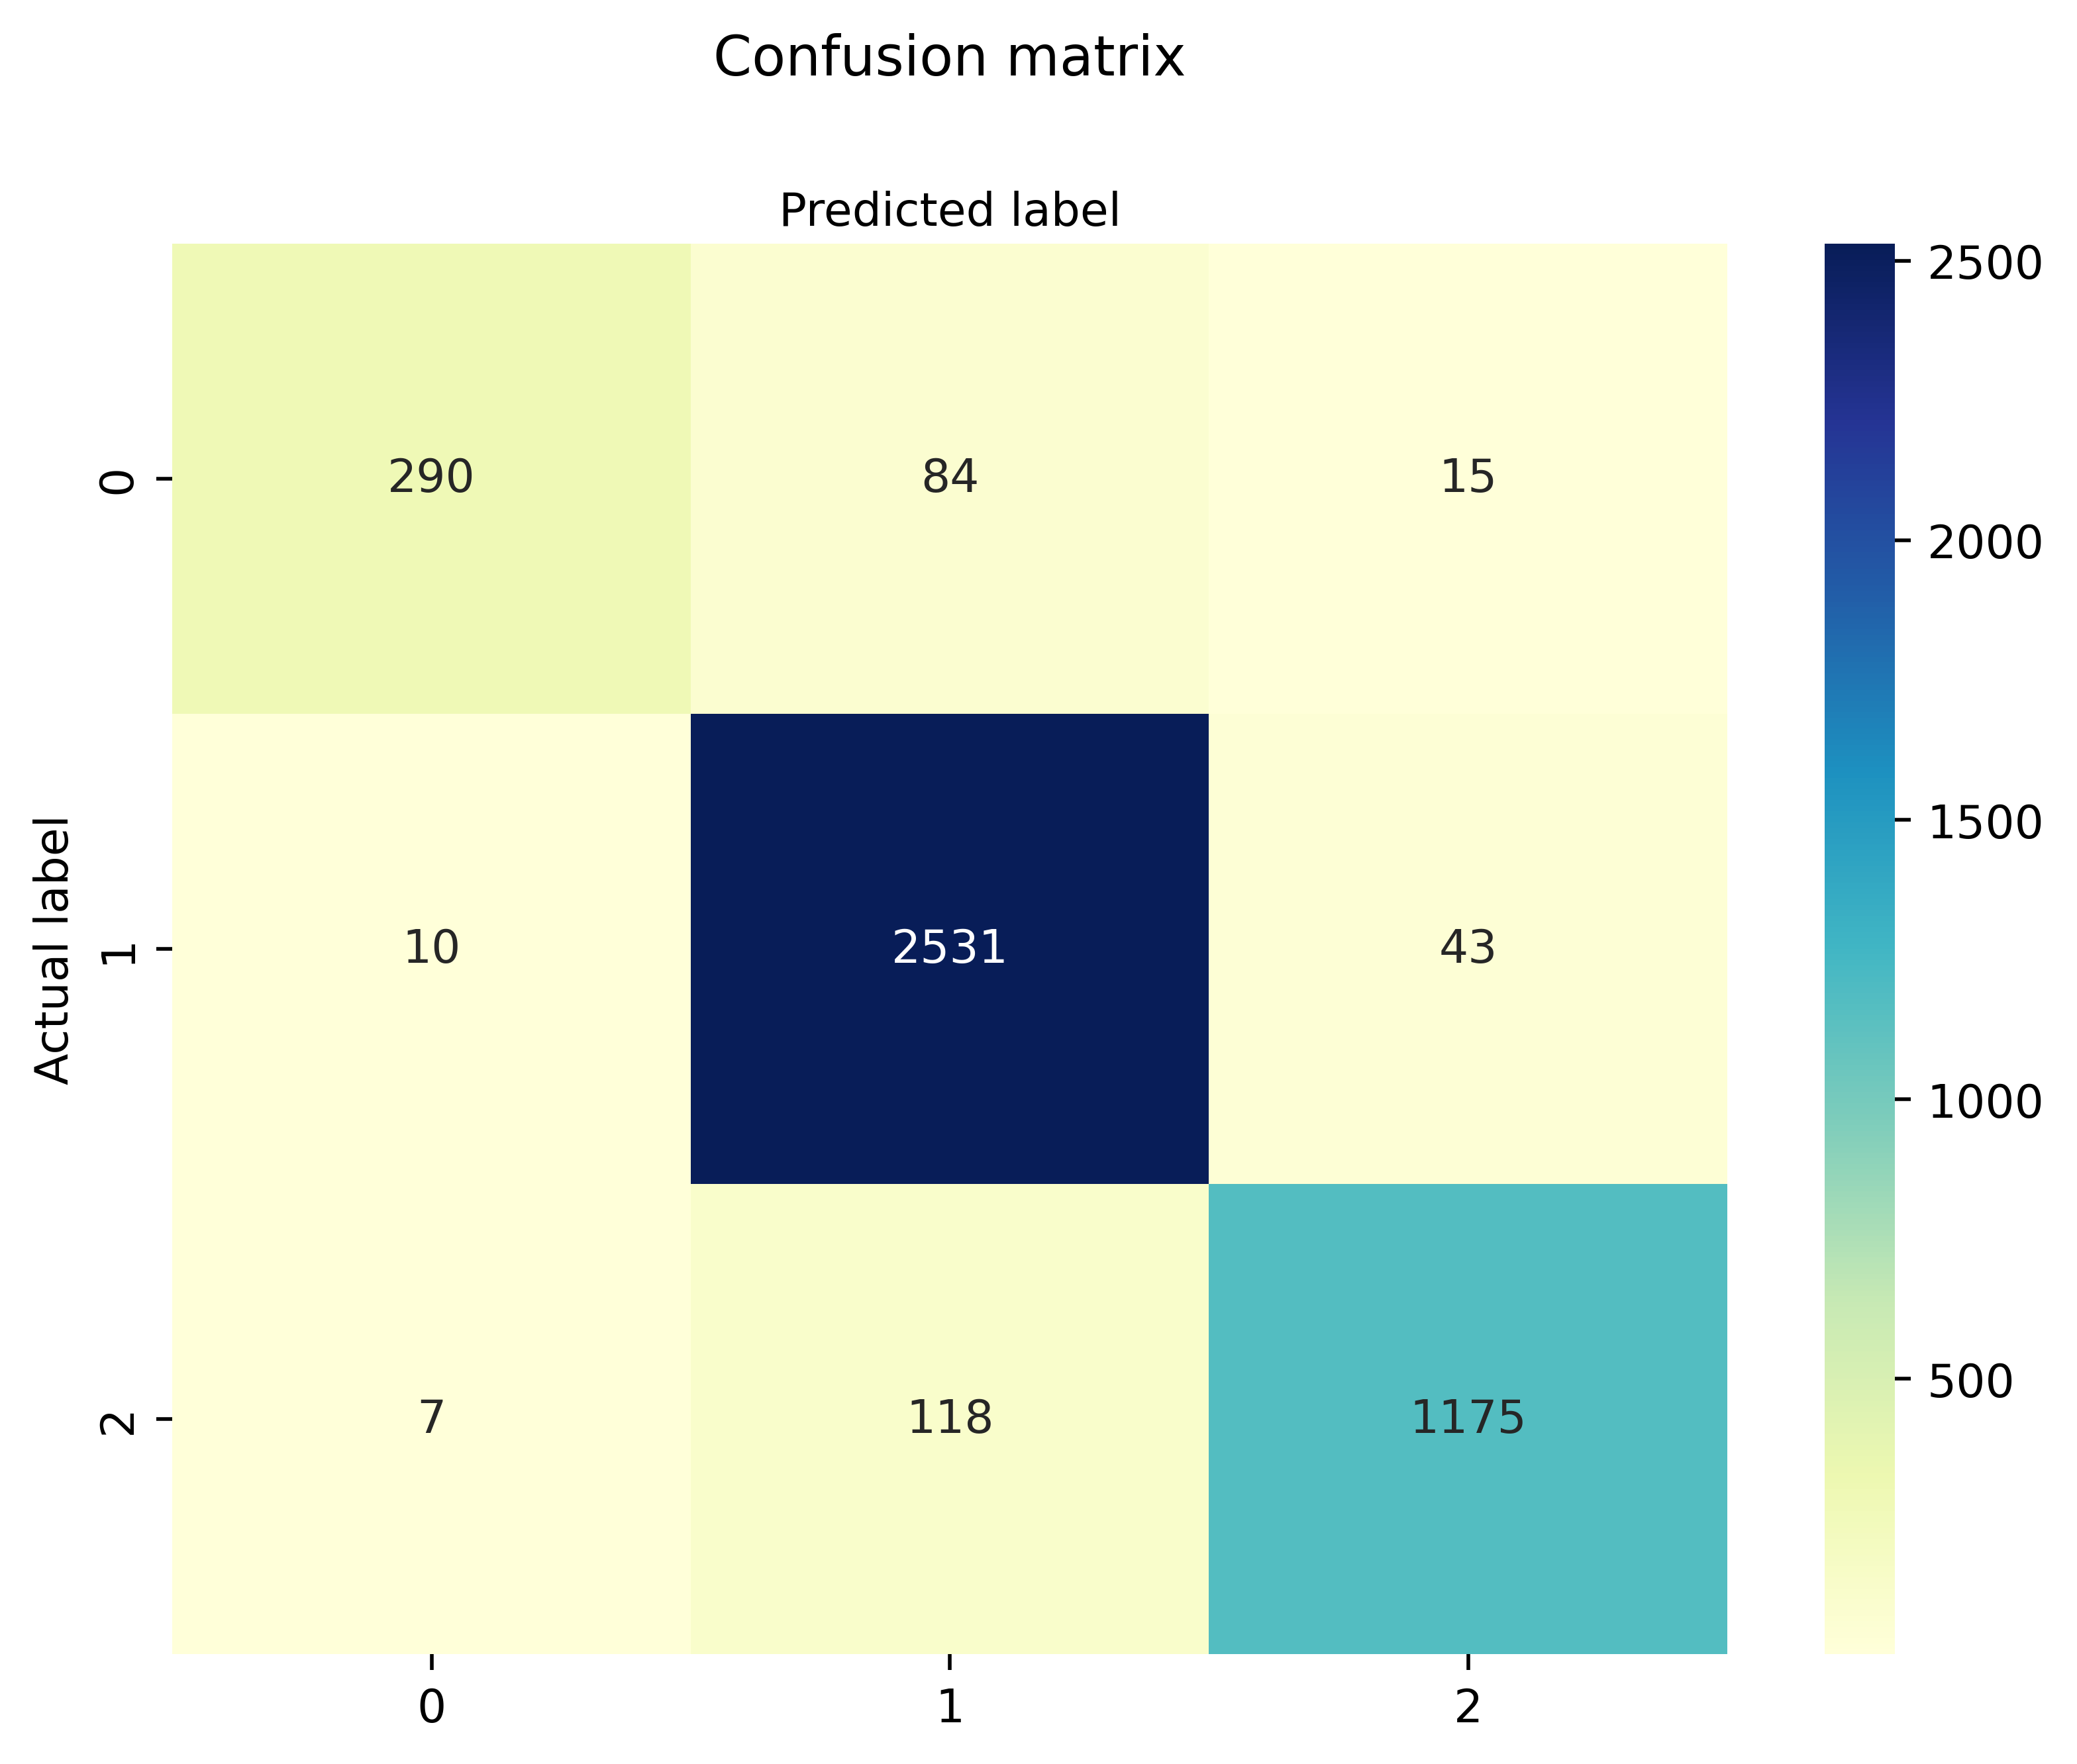

In [22]:
# Output the best parameters and score from GridSearchCV
best_model_grid = grid_search.best_estimator_
print('Best Parameters:', grid_search.best_params_, end='\n\n')

# Predict and evaluate the model
predictions_grid = best_model_grid.predict(features_test_bow_combined)

accuracy_voting = accuracy_score(target_test, predictions_grid)
print(f"Accuracy: {accuracy_voting}")

# Calculate OOB Score
oob_score_voting = best_model_grid.score(features_train_bow_combined, target_train)
print(f"\nOOB Score: {oob_score_voting}")

# Detailed classification report for GridSearchCV
print("\nClassification Report: \n", classification_report(target_test, predictions_grid))

# Print and Plot Confusion Matrix for GridSearchCV
cm_voting = confusion_matrix(target_test, predictions_grid)
df_cm_voting = pd.DataFrame(cm_voting, index=['-1', '0', '1'], columns=['-1', '0', '1'])
print("Confusion Matrix:\n", df_cm_voting)
plot_conf_mat(cm_voting)

## Random Search

In [23]:
# Initialize a RandomForestClassifier for randomized search
forest_classifier_random = RandomForestClassifier(random_state=43)

# Create the RandomizedSearchCV object with the same parameters as the GridSearchCV
random_search = RandomizedSearchCV(
    estimator=forest_classifier_random,
    param_distributions=grid_search_params,
    n_iter=300,
    cv=10,
    n_jobs=-1,
    verbose=True,
    scoring='accuracy'
)

# Fit the RandomizedSearchCV object to the data
random_search.fit(features_train_bow_combined, target_train)

/Users/josh/Desktop/Coding 👨🏽‍💻/sentiment_analysis/venv/lib/python3.11/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 72 is smaller than n_iter=300. Running 72 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 10 folds for each of 72 candidates, totalling 720 fits


RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(random_state=43),
                   n_iter=300, n_jobs=-1,
                   param_distributions={'max_depth': [20, 50, 100, 120],
                                        'min_samples_leaf': [2, 4, 6],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [50, 70, 100]},
                   scoring='accuracy', verbose=True)

Best Parameters: {'n_estimators': 70, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 120}

Accuracy: 0.9351743505733676



OOB Score: 0.9452375380294875

Classification Report: 
               precision    recall  f1-score   support

          -1       0.94      0.75      0.83       389
           0       0.93      0.98      0.95      2584
           1       0.95      0.90      0.93      1300

    accuracy                           0.94      4273
   macro avg       0.94      0.88      0.90      4273
weighted avg       0.94      0.94      0.93      4273

Confusion Matrix:
      -1     0     1
-1  290    84    15
0    10  2531    43
1     7   118  1175


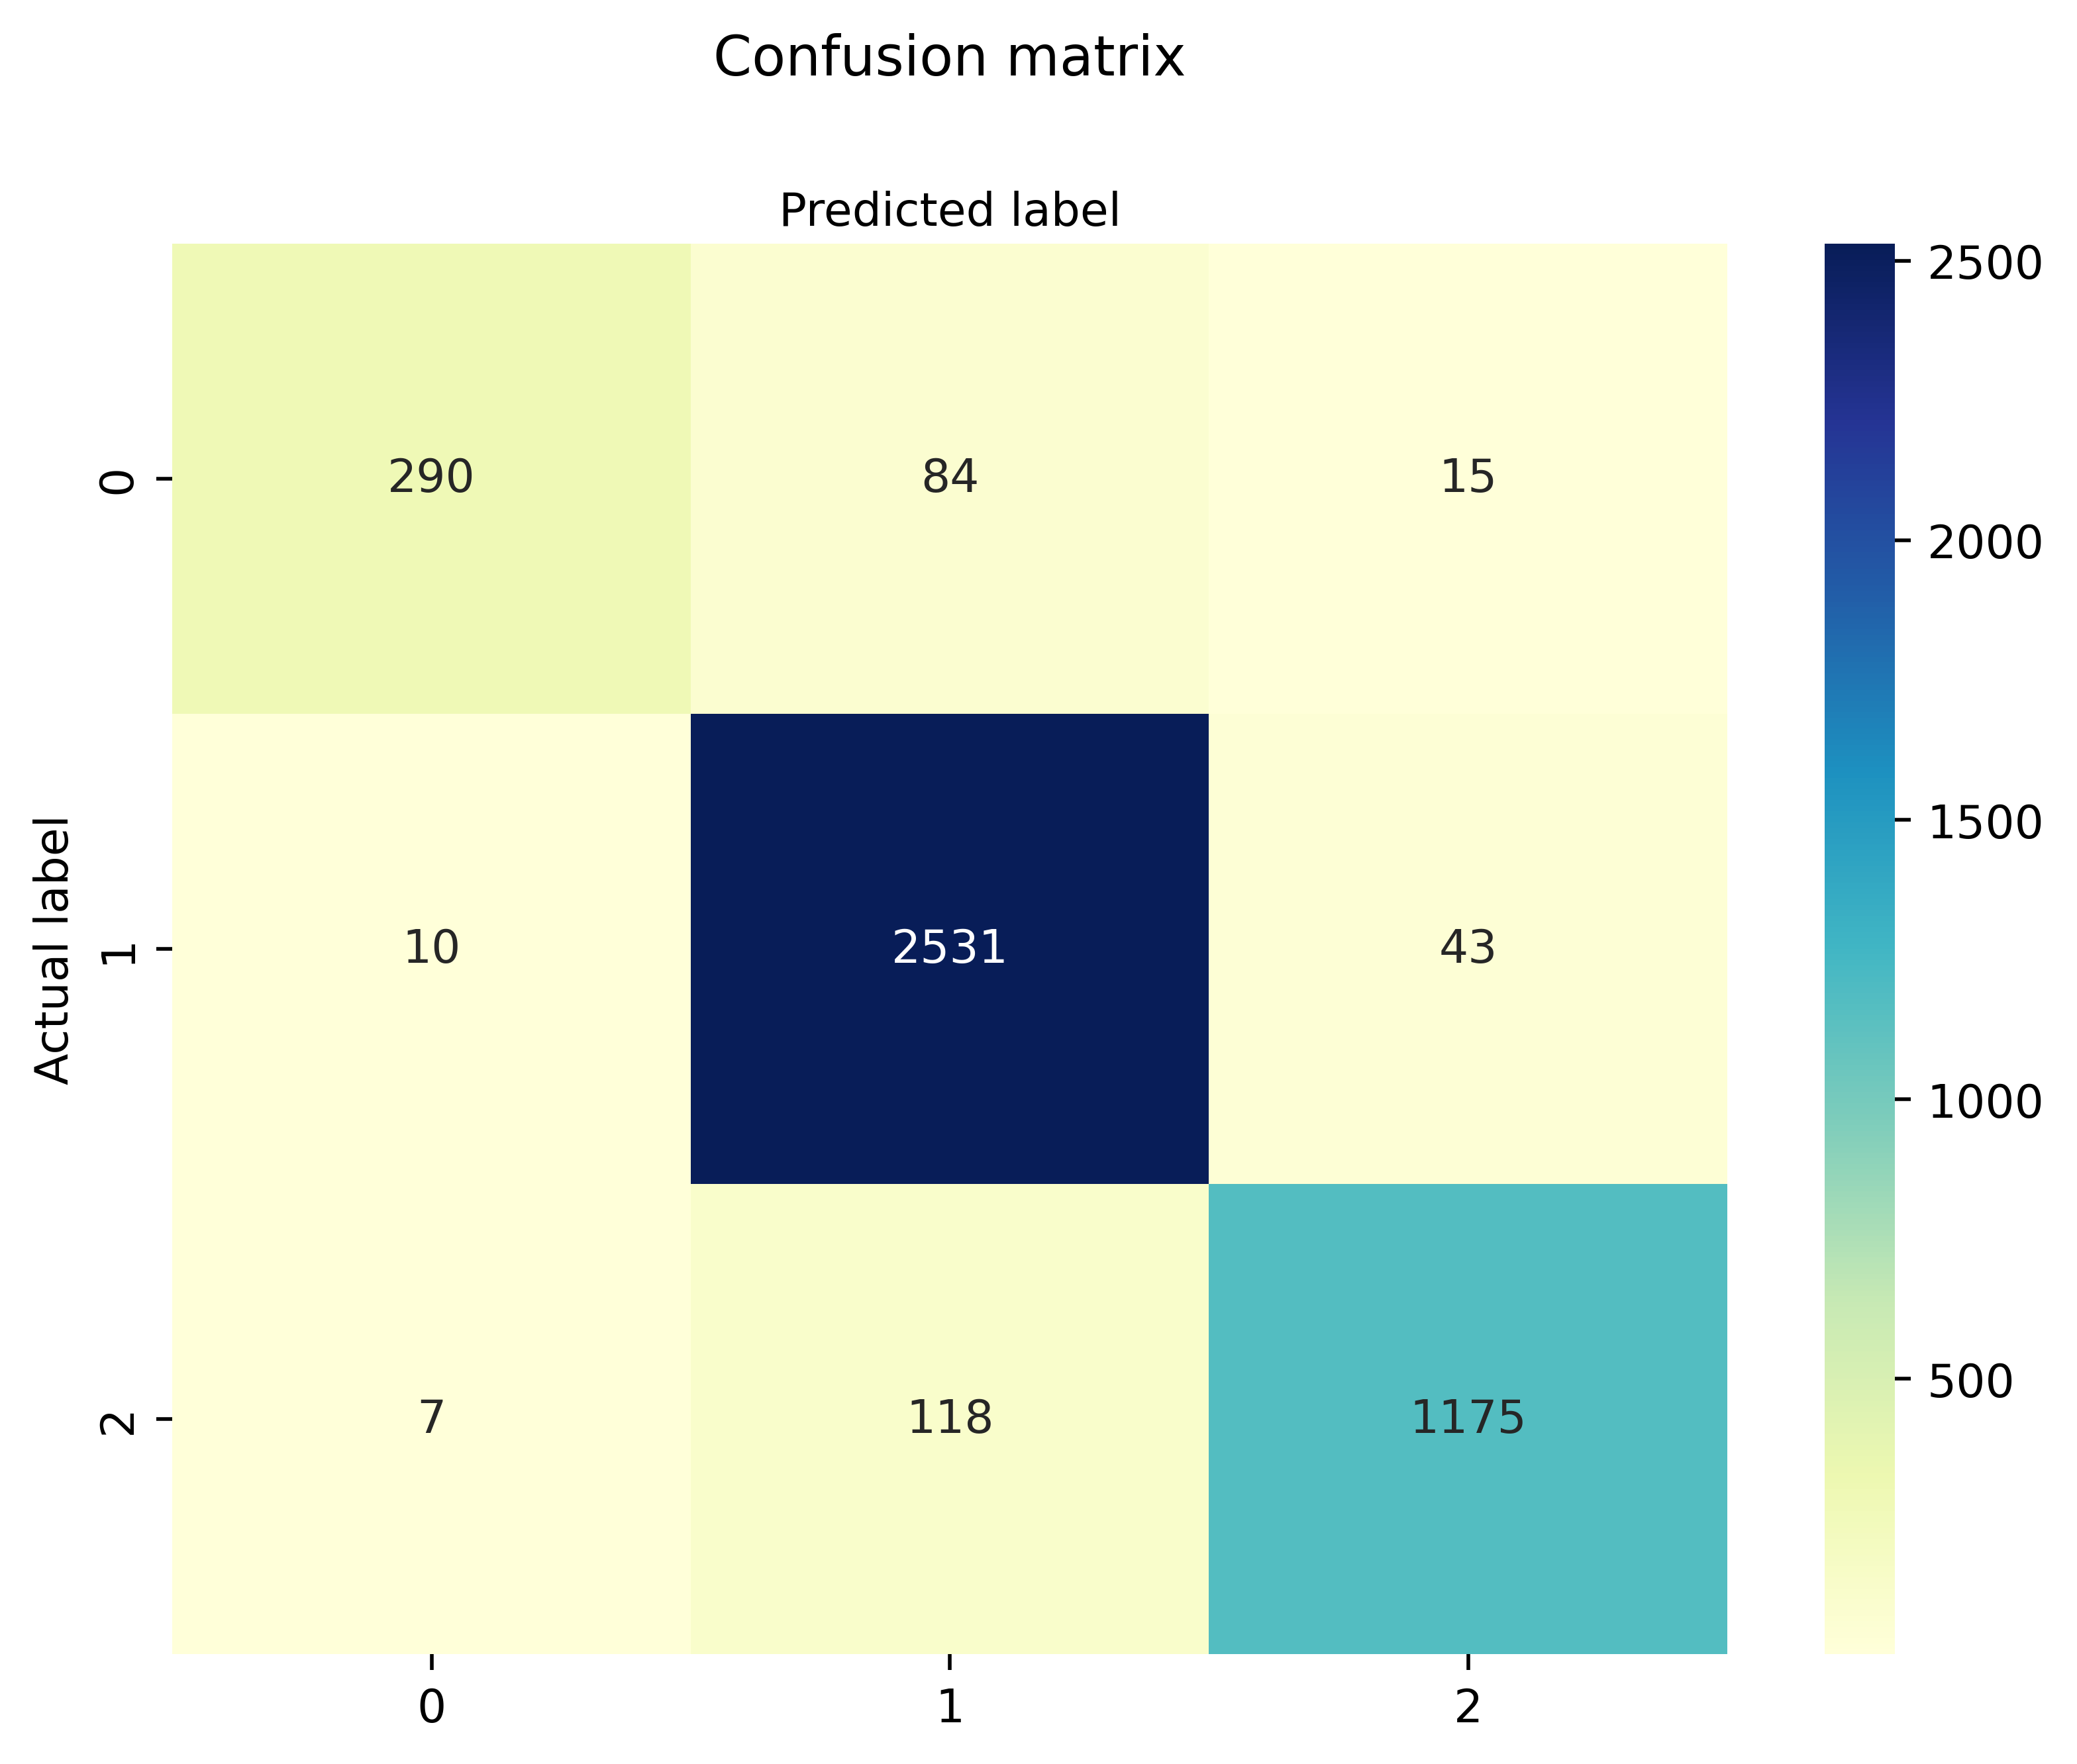

In [24]:
# Output the best parameters and score from RandomizedSearchCV
best_model_random = random_search.best_estimator_
print('Best Parameters:', random_search.best_params_, end='\n\n')

# Predict and evaluate the model
predictions_random = best_model_random.predict(features_test_bow_combined)

accuracy_voting = accuracy_score(target_test, predictions_random)
print(f"Accuracy: {accuracy_voting}")

# Calculate OOB Score
oob_score_voting = best_model_random.score(features_train_bow_combined, target_train)
print(f"\nOOB Score: {oob_score_voting}")

# Detailed classification report for RandomizedSearchCV
print("\nClassification Report: \n", classification_report(target_test, predictions_random))

# Print and Plot Confusion Matrix for RandomizedSearchCV
cm_voting = confusion_matrix(target_test, predictions_random)
df_cm_voting = pd.DataFrame(cm_voting, index=['-1', '0', '1'], columns=['-1', '0', '1'])
print("Confusion Matrix:\n", df_cm_voting)
plot_conf_mat(cm_voting)